# Examples of ordinary differential equation discovery with EPDE framework

This notebook presents an overview of the evolutionary discovery of ODE on examples... 

In [1]:
import numpy as np
import os
import sys
from typing import Union, Callable

import matplotlib.pyplot as plt
import matplotlib as mpl

ADD SOME LINK TO ARTICLE ON EPDE PRINCIPLES

In [2]:
import sys
sys.path.append('..')
import helpers

In [3]:
import epde

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['text.usetex'] = True

SMALL_SIZE = 12
mpl.rc('font', size=SMALL_SIZE)
mpl.rc('axes', titlesize=SMALL_SIZE)


## First order ODE with trigonometric functions

Principles of equation discovery can be illustrated by a simple example of reconstruction of first-order equation:

\begin{equation}
\label{eq:ODE1}
x \sin{t} + \frac{d x}{d t} \cos{t} = 1,
\end{equation}

where the general solution for an arbitrary constant $C$ is:

\begin{equation}
\label{eq:ODE1_solution}
x = \sin{t} + C \cos{t}.
\end{equation}

To generate the data we will use an analytical particular solution, matching initial condition of $x(0) = 1.3$ (thus, $C = 1.3$) on the interval of $(0, 4 \pi)$:

\begin{equation}
\label{eq:ODE1_part_solution}
x = \sin{t} + 1.3 \cos{t}.
\end{equation}

Furthermore, we will provide an example of using a priori known derivatvies, that can be easily calculated by differentiating the solution:

\begin{equation}
\label{eq:ODE1_deriv_solution}
x' = \cos{t} - 1.3 \sin{t}.
\end{equation}

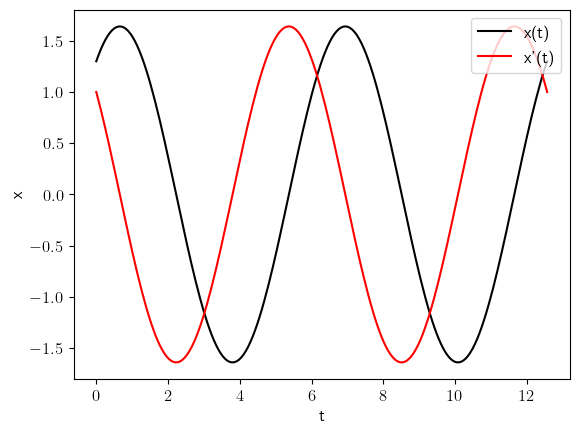

In [4]:
C = 1.3
t = np.linspace(0, 4*np.pi, 200)
x = np.sin(t) + C * np.cos(t)
x_dot = np.cos(t) - C * np.sin(t)

max_axis_idx = x.ndim - 1

plt.plot(t, x, color = 'k', label = 'x(t)')
plt.plot(t, x_dot, color = 'r', label = "x'(t)")

plt.legend(loc = 'upper right')
plt.xlabel('t')
plt.ylabel('x')
plt.show()

Next, we shall initialize the equation search object. Here we are using multiobjective optimization (here, it i denoted explicitly, despite it being the default option). Non-defalut parameter is the size of the boundary: $s_{bnd} = 20$.

Additional parameters will be as follows  population size number of optimziation epochs: ``n_epochs = 30``.

To be able to discovery the correct governing equation, the set of elementary functions (i.e. tokens) (in addition to the derivatives, that are always used) has to include the trigonometric functions. Furthermore, we will include grid as elementary block to provide diversity of the tokens.

In [5]:
bnd = 20
n_epochs = 50
popsize = 8

epde_search_obj = epde.EpdeSearch(multiobjective_mode = True, boundary = bnd, 
                                  dimensionality = max_axis_idx, coordinate_tensors = [t,])

trig_tokens = epde.TrigonometricTokens(freq = (0.95, 1.05), dimensionality=max_axis_idx)
grid_tokens = epde.GridTokens(['x_0',], dimensionality = max_axis_idx)

epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=n_epochs)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fc1b510b610>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fc1b510b610>
trig_token_params: VALUES = (0, 0)
OrderedDict([('power', (1, 1)), ('dim', (0, 0))])


The detection of differential equations is initiated with ``EpdeSearch.fit()`` method. Data is passed in the ``data`` argument, where the elements of the argument list are numpy.ndarrays, describing individual variables. The derivatives can be passed explicity in the argument ``derivs`` with the same logic: the argument has to be a list with numpy.ndarrays of derivatives for each variable. The dimensionality of such arrays has to be $n\_points \; \times \; deriv\_ords$, where $n\_points$ is the total number of points in the domain, and $deriv\_ords$ is the number of passed derivatives. With ``derivs = None``, the derivatives are calculated numerically.

Additional elementary functions, that we expect to have in the resulting equations, are passed in the ``additional_tokens`` argument. 

We define equation structure properties with the following settings:

- Argument ``max_deriv_order`` sets the highest order of derivatives, that can be used in equation search. 
- Number of terms, accepted into the structure before regularization is regulated by argument ``equation_terms_max_number``.
- Argument ``equation_factors_max_number`` defined number of terms in the term can be set as integer (in this case, the number of factors for the particular term is selected from a uniform distribution $U(1, equation\_factors\_max\_number)$), or by dictionary, as in our example.
- Argument ``data_fun_pow`` indicates the highest power of derivative-like token in the equation. With ``data_fun_pow = 2``, supported by sufficiently high ``equation_factors_max_number`` and ``equation_terms_max_number``, the terms like $u^2 u'$ and $(u')^2 \cdot u^2$ can appear in the equation, while terms like $u^3$ won't be allowed in structures.
- Sparsity constant range ``eq_sparsity_interval`` controls the complexities of the initially created candidate equations: the argument has to be a tuple of $(a_{left}, a_{right})$. Each candidate during the population initialization is given a value $\lambda = \exp{l}; \; l \sim U(\ln a_{left}, \ln a_{right})$. With the boundaries shifted to 0, the equation is regularized less, while with high values of $ a_{left} \; \& \; a_{right}$ the majority of terms will be filtered out.

In [6]:
factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.65, 0.35]} # 1 factor with P = 0.65, 2 with P = 0.35

epde_search_obj.fit(data=[x,], variable_names=['u',], max_deriv_order=(1,), derivs=[x_dot.reshape((-1, 1)),],
                    equation_terms_max_number=4, data_fun_pow = 1,
                    additional_tokens=[trig_tokens, grid_tokens],
                    equation_factors_max_number=factors_max_number,
                    eq_sparsity_interval=(1e-6, 1e-2))

Deriv orders after definition [[None], [0]]
initial_shape (200,) derivs_tensor.shape (200, 1)
self.tokens is ['u', 'du/dx0']
Here, derivs order is {'u': [None], 'du/dx0': [0]}
The cardinality of defined token pool is [2 2 1]
Among them, the pool contains [2 1]
Creating new equation, sparsity value [0.00013173]
New solution accepted, confirmed 1/8 solutions.
Creating new equation, sparsity value [0.00041759]
New solution accepted, confirmed 2/8 solutions.
Creating new equation, sparsity value [0.00025425]
Creating new equation, sparsity value [0.00017177]
New solution accepted, confirmed 3/8 solutions.
Creating new equation, sparsity value [2.06723287e-06]
New solution accepted, confirmed 4/8 solutions.
Creating new equation, sparsity value [0.00086434]
New solution accepted, confirmed 5/8 solutions.
Creating new equation, sparsity value [4.96260272e-05]
New solution accepted, confirmed 6/8 solutions.
Creating new equation, sparsity value [3.79898092e-05]
New solution accepted, confirme

During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 22-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 23-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 24-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During 

During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 47-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 48-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 49-th epoch.
During MO : processing 0-th weight.
During 

The discovered equations can be accessed with ``EpdeSearch.equations()`` method. If the ``only_print = True``, than the equations will be printed in their text forms. 

Otherwise, they will be return: if the followup argument ``only_str`` is ``True``, than the equations are returned only in their symbolic string-form. If ``only_str = False``, than the equation in its program implementation ``epde.structure.main_structures.SoEq`` are returned.

In [7]:
epde_search_obj.equations(only_print = True)
res = epde_search_obj.equations(False, only_str = False)



0-th non-dominated level


0.0 * x_0{power: 1.0, dim: 0.0} + 0.025217005432275823 * u{power: 1.0} + 0.0 * x_0{power: 1.0, dim: 0.0} * u{power: 1.0} + 0.6669677405245148 = du/dx0{power: 1.0} * cos{power: 1.0, freq: 1.0499000873630582, dim: 0.0}
{'terms_number': {'optimizable': False, 'value': 4}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.005657086033085299}} , with objective function values of [5.89152992 2.        ] 

0.00888228979551941 * x_0{power: 1.0, dim: 0.0} + 0.006798153402721441 * u{power: 1.0} * cos{power: 1.0, freq: 0.9974444910634812, dim: 0.0} + -1.0004120960660567 * u{power: 1.0} * sin{power: 1.0, freq: 1.0076995322921416, dim: 0.0} + 0.9973172059164307 = du/dx0{power: 1.0} * cos{power: 1.0, freq: 1.006623183604285, dim: 0.0}
{'terms_number': {'optimizable': False, 'value': 4}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], '

The particular solution of the ODE in addition to the governing equation $x \sin{(t)} + x' \cos{(t)} = 1,$ also matches the solution of equation $x' \sin{(t)}  - x \cos{(t)} = - 1.3$. With them having (in ideal case) the same fitness functions values, we can expect presence of at least one type of such results in the equation.

We can use visual analysis of the Pareto-optimal set of candidate equations, placed in the complexity-quality criteria space, to select the optimal equation. Method ``EpdeSearch.visualize_solutions()`` illustrates the first non-dominated set of solutions (i.e. Pareto frontier). With its help we can see, that equations like $x' \cdot \sin{(1.001 \; t)} = 9.997\cdot 10^{-1} x \cdot cos{(1.006 \; t)} + -1.274$ (due to stochastic nature of evolutionary optimization) matches the knee point of a Pareto frontier curve.

$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot cos^{1.0}(1.05 x_{0.0}) = 2.522\cdot 10^{-2} u + 6.67\cdot 10^{-1}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot cos^{1.0}(1.007 x_{0.0}) = 8.882\cdot 10^{-3} x_0 + 6.798\cdot 10^{-3} u \cdot cos^{1.0}(9.974\cdot 10^{-1}  x_{0.0}) + -1.0u \cdot sin^{1.0}(1.008 x_{0.0}) + 9.973\cdot 10^{-1}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot cos^{1.0}(1.002 x_{0.0}) = -9.99\cdot 10^{-1} u \cdot sin^{1.0}(1.0 x_{0.0}) + 1.008 \end{eqnarray*}$


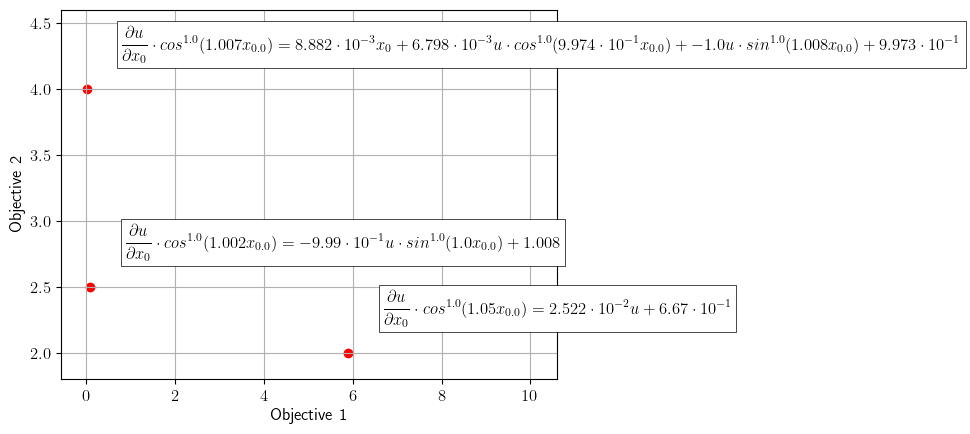

In [8]:
epde_search_obj.visualize_solutions()

## Second order non-linear ODE

A more complex example of the problem can be posed by a linear non-homogeneous equation $x'' + \sin{(2t)} x' + 4 x = 1.5 t$. To get a synthetic dataset we can solve it with Runge-Kutta fourth order method. The particular solution matches the initial problem of $x|_{t = 0} = 0.8$, $x''|_{t = 0} = 2.0$ for domain $t \in [0, 16)$.

In [4]:
def second_order_lODE_by_RK(initial : tuple, timestep : float, steps : int, g1 : Callable, 
                           g2 : Callable, g3 : Callable, g4 : Callable):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    for step in range(steps-1):
        t = step*timestep
        k1 = res[step, 1] ; x1 = res[step, 0] + timestep/2. * k1
        l1 = (g4(t) - g3(t)*res[step, 0] - g2(t)*res[step, 1]) / g1(t); y1 = res[step, 1] + timestep/2. * l1

        k2 = y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = (g4(t) - g3(t)*x1 - g2(t)*y1) / g1(t); y2 = res[step, 1] + timestep/2. * l2

        k3 = y2
        l3 = (g4(t) - g3(t)*x2 - g2(t)*y2) / g1(t);
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = y3
        l4 = (g4(t) - g3(t)*x3 - g2(t)*y3) / g1(t)
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

In [5]:
g1 = lambda x: 1.
g2 = lambda x: np.sin(2*x)
g3 = lambda x: 4.
g4 = lambda x: 1.5*x

step = 0.05; steps_num = 320
t = np.arange(start = 0., stop = step * steps_num, step = step)
solution = second_order_lODE_by_RK(initial=(0.8, 2.), timestep=step, steps=steps_num, 
                                  g1=g1, g2=g2, g3=g3, g4=g4)

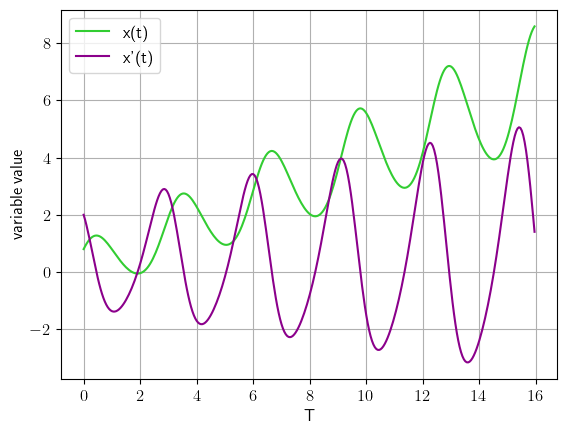

In [6]:
plt.plot(t, solution[:, 0], label = 'x(t)', color = 'limegreen')
plt.plot(t, solution[:, 1], label = "x'(t)", color = 'darkmagenta')
plt.grid(); plt.legend()
plt.xlabel('T'); plt.ylabel('variable value')
plt.show()

While it can be insightful to analyze the process with the data-driven differential equation, occasionally it will be needed to predict the future state of the system, based on the equation. In this experiment we will split the input dataset into train ($t \in [0, 8)$) and test ($t \in [8, 16)$) parts. To validate the predicitive ability, the best equation will be integrated over the domain, using internal automaitic differential equation solution methods.

In [7]:
def epde_discovery(t, x, use_ann = False):
    dimensionality = x.ndim - 1
    

    epde_search_obj = epde.EpdeSearch(use_solver = False, dimensionality = dimensionality, boundary = 30,
                                      coordinate_tensors = [t,])
    if use_ann:
        epde_search_obj.set_preprocessor(default_preprocessor_type='ANN', # use_smoothing = True poly
                                         preprocessor_kwargs={'epochs_max' : 50000})# 
    else:
        epde_search_obj.set_preprocessor(default_preprocessor_type='poly', # use_smoothing = True poly
                                         preprocessor_kwargs={'use_smoothing' : False, 'sigma' : 1, 
                                                              'polynomial_window' : 3, 'poly_order' : 3}) 
                                                            # 'epochs_max' : 10000})
    eps = 5e-7
    popsize = 8
    epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=55)
    trig_tokens = epde.TrigonometricTokens(freq = (2 - eps, 2 + eps), 
                                      dimensionality = dimensionality)
    factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.65, 0.35]}

    custom_grid_tokens = epde.GridTokens(dimensionality = dimensionality)
    
    epde_search_obj.fit(data=[x,], variable_names=['u',], max_deriv_order=(2,),
                        equation_terms_max_number=6, data_fun_pow = 1, 
                        additional_tokens=[trig_tokens, custom_grid_tokens], 
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=(1e-6, 1e-2))

    epde_search_obj.equations(only_print = True, num = 1)
    
    '''
    Having insight about the initial ODE structure, we are extracting the equation with complexity of 5
    
    In other cases, you should call epde_search_obj.equations(only_print = True), or epde_search_obj.
    where the algorithm presents Pareto frontier of optimal equations.
    '''

    return epde_search_obj

In [8]:
t_max = 160
t_train = t[:t_max]; t_test = t[t_max:] 
x_train = solution[:t_max, 0]; x_test = solution[t_max:, 0]

epde_search_obj = epde_discovery(t_train, x_train, True)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f2788616e20>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f2788616e20>
trig_token_params: VALUES = (0, 0)
OrderedDict([('power', (1, 1)), ('dim', (0, 0))])
Deriv orders after definition [[None], [0], [0, 0]]
initial_shape (160,) derivs_tensor.shape (160, 2)
self.tokens is ['u', 'du/dx0', 'd^2u/dx0^2']
Here, derivs order is {'u': [None], 'du/dx0': [0], 'd^2u/dx0^2': [0, 0]}
The cardinality of defined token pool is [3 2 1]
Among them, the pool contains [3 1]
Creating new equation, sparsity value [4.04371548e-06]
New solution accepted, confirmed 1/8 solutions.
Creating new equation, sparsity value [0.00581916]
New solution accepted, confirmed 2/8 solutions.
Creating new equation, sparsity value [6.99509856e-05]
New solution accepted, confirmed 3/8 solutions.
Creating new equation, sparsity value [5.32778731e-06]
New solution accepted, confirmed 4/8 solutions.
Creating new equation, spa

During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 21-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 22-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 23-th epoch.
During MO : processing 0-th weight.
During 

Multiobjective optimization : 45-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 46-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 47-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiob

$\begin{eqnarray*} \frac{\partial u}{\partial x_0} = -1.185\cdot 10^{-1} t + 3.658\cdot 10^{-1} t \cdot cos^{1.0}(2.0 x_{0.0}) + -9.803\cdot 10^{-1} u \cdot sin^{1.0}(2.0 x_{0.0}) + 1.225 \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot sin^{1.0}(2.0 x_{0.0}) = -2.055\cdot 10^{-1} \frac{\partial u}{\partial x_0} + -3.531\cdot 10^{-3} \frac{\partial ^2u}{\partial x_0^2} \cdot t + -7.794\cdot 10^{-1} t \cdot cos^{1.0}(2.0 x_{0.0}) + -2.877\cdot 10^{-1} u + 2.009u \cdot cos^{1.0}(2.0 x_{0.0}) + -1.203 \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot sin^{1.0}(2.0 x_{0.0}) = -3.951u + -9.901\cdot 10^{-1} \frac{\partial ^2u}{\partial x_0^2} + 1.477t + 1.496\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = -3.973u + 1.481t + -9.923\cdot 10^{-1} \frac{\partial u}{\partial x_0} \cdot sin^{1.0}(2.0 x_{0.0}) + -2.49\cdot 10^{-2} u \cdot sin^{1.0}(2.0 x_{0.0}) + 4.837\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eq

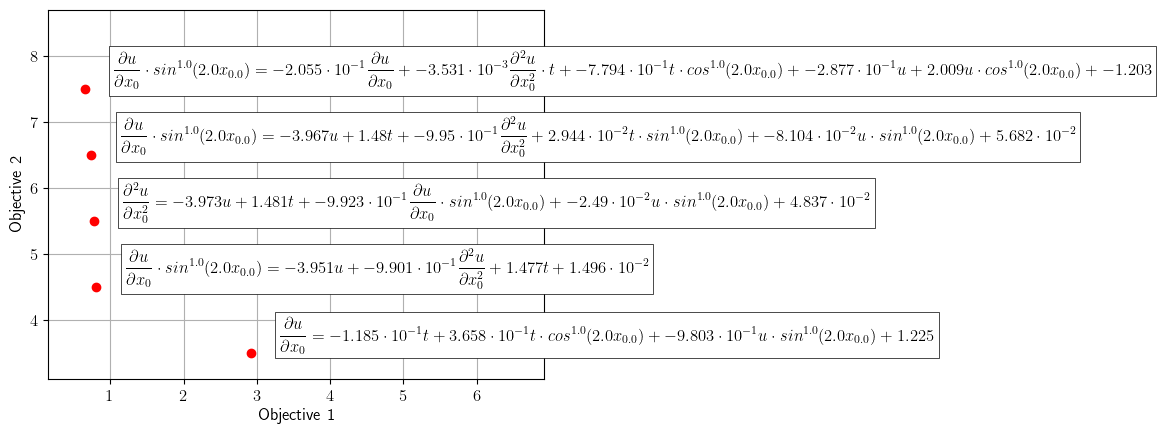

In [9]:
epde_search_obj.visualize_solutions()

In [10]:
system = epde_search_obj.get_equations_by_complexity(4.5)[0]

In [11]:
system.text_form

"-3.951218144289313 * u{power: 1.0} + 0.0 * t{power: 1.0, dim: 0.0} * sin{power: 1.0, freq: 1.9999995807630981, dim: 0.0} + 0.0 * u{power: 1.0} * cos{power: 1.0, freq: 2.000000378681952, dim: 0.0} + -0.9900591677672463 * d^2u/dx0^2{power: 1.0} + 1.4766602719611732 * t{power: 1.0, dim: 0.0} + 0.014961528346664596 = du/dx0{power: 1.0} * sin{power: 1.0, freq: 1.9999995886960809, dim: 0.0}\n{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.004122473023559842}}"

While there are multiple equations on the Pareto frontier, we can establish two candidates for the knee-points (for brevity they are denoted by their complexities: 4 and 4.5). The further increase in complexity does not provide significant error decrease, thus is not necessary. We shall analyze the process representation quality on the test dataset by solving initial value problem.

The equation with complexity of 4.5 is second-order, thus to solve it we need the function value and the solution derivatve

In [12]:
import torch
from epde.interface.solver_integration import BoundaryConditions, BOPElement

eq_1 = epde_search_obj.get_equations_by_complexity(4.5)[0]
print(eq_1.text_form)

-3.951218144289313 * u{power: 1.0} + 0.0 * t{power: 1.0, dim: 0.0} * sin{power: 1.0, freq: 1.9999995807630981, dim: 0.0} + 0.0 * u{power: 1.0} * cos{power: 1.0, freq: 2.000000378681952, dim: 0.0} + -0.9900591677672463 * d^2u/dx0^2{power: 1.0} + 1.4766602719611732 * t{power: 1.0, dim: 0.0} + 0.014961528346664596 = du/dx0{power: 1.0} * sin{power: 1.0, freq: 1.9999995886960809, dim: 0.0}
{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.004122473023559842}}


In [13]:
def get_ode_bop(key, var, term, grid_loc, value):
    bop = BOPElement(axis = 0, key = key, term = term, power = 1, var = var)
    bop_grd_np = np.array([[grid_loc,]])
    bop.set_grid(torch.from_numpy(bop_grd_np).type(torch.FloatTensor))
    bop.values = torch.from_numpy(np.array([[value,]])).float()
    return bop

bop_u = get_ode_bop('u', 0, [None], t_test[0], x_test[0])
# Set derivative with central finite difference 
bop_du = get_ode_bop('dudt', 0, [0,], t_test[0], (x_test[1] - x_train[-1])/(2*(t_test[1] - t_test[0])))   

In [14]:
pred_u = epde_search_obj.predict(system=eq_1, boundary_conditions = [bop_u(), bop_du()],
                                 grid = [t_test,], strategy='autograd', solver_kwargs = {'use_cache':False, 'step_plot_save':False})
pred_u = pred_u.reshape(-1)

Using explicitly sent system of equations.
dimensionality is 1
grid.shape is (160,)
Shape of the grid for solver torch.Size([160, 1])
Grid is  <class 'torch.Tensor'> torch.Size([160, 1])
torch.Size([1])
[2023-11-17 14:22:25.884183] initial (min) loss is 158.1117401123047
[2023-11-17 14:22:26.021060] Print every 5000 step
Step = 0 loss = 158.111740 normalized loss line= -0.000000x+1.000000. There was 1 stop dings already.
[2023-11-17 14:23:14.018034] No improvement in 100 steps
Step = 1003 loss = 0.000193 normalized loss line= -1.568164x+154.301719. There was 1 stop dings already.
[2023-11-17 14:23:18.626122] No improvement in 100 steps
Step = 1105 loss = 0.001660 normalized loss line= -0.034247x+7.008235. There was 2 stop dings already.
[2023-11-17 14:23:23.117335] No improvement in 100 steps
Step = 1205 loss = 0.035738 normalized loss line= -0.001361x+0.462532. There was 3 stop dings already.
[2023-11-17 14:23:29.748140] No improvement in 100 steps
Step = 1349 loss = 0.000676 normaliz

To evaluate the quality of obtained equation, we will check the MAPE error and visualize the solution oftest domain.

MAPE on the test dataset is 0.006158279444752504


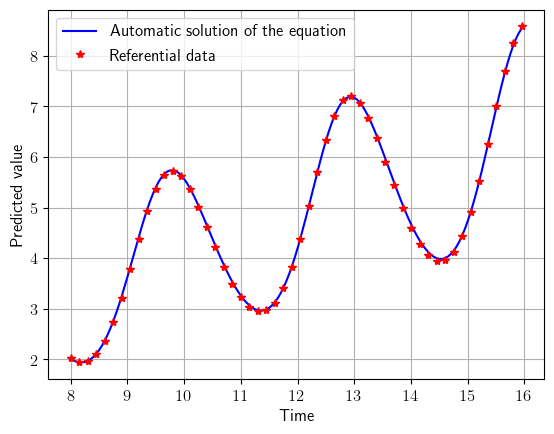

In [17]:
print(f'MAPE on the test dataset is {np.mean(np.abs((pred_u - x_test)/x_test))}')

plt.plot(t_test, pred_u, color = 'b', label = 'Automatic solution of the equation')
plt.plot(t_test[::3], x_test[::3], '*', color = 'r', label = 'Referential data')
plt.xlabel('Time'); plt.ylabel('Predicted value') 
plt.grid()
plt.legend()
plt.show()

In [89]:
eq2 = epde_search_obj.get_equations_by_complexity(4)[0]
eq2.text_form

"0.0 * d^2u/dx0^2{power: 1.0} + 0.6334141886464264 * u{power: 1.0} + -0.4036802767762263 * t{power: 1.0, dim: 0.0} + -0.5265121291057969 * t{power: 1.0, dim: 0.0} * sin{power: 1.0, freq: 2.000000359965463, dim: 0.0} + 0.2596251993636941 * t{power: 1.0, dim: 0.0} * cos{power: 1.0, freq: 1.9999999936069808, dim: 0.0} + 0.9225210424019804 = du/dx0{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.005910228093653957}}"

This equation has the first order, thus only a single initial condition $u|_{t = t_{val, 0}}$ is needed, and we get it from the data.

In [90]:
bop_u = get_ode_bop('u', 0, [None], t_test[0], x_test[0])
pred_u = epde_search_obj.predict(system=eq2, 
                                 boundary_conditions = [bop_u(),],# bop_du()],
                                 grid = [t_test,], strategy='autograd')
pred_u = pred_u.reshape(-1)

Using explicitly sent system of equations.
dimensionality is 1
grid.shape is (160,)
Shape of the grid for solver torch.Size([160, 1])
Grid is  <class 'torch.Tensor'> torch.Size([160, 1])
torch.Size([1])
[2023-10-27 13:26:06.629574] initial (min) loss is 314.85504150390625
[2023-10-27 13:26:06.673411] Print every 1000 step
Step = 0 loss = 314.855042 normalized loss line= -0.000000x+1.000000. There was 1 stop dings already.
[2023-10-27 13:26:13.090162] No improvement in 100 steps
Step = 175 loss = 0.681533 normalized loss line= -0.670408x+46.723266. There was 1 stop dings already.
[2023-10-27 13:26:16.941645] No improvement in 100 steps
Step = 275 loss = 0.661911 normalized loss line= 0.000372x+1.001404. There was 2 stop dings already.
[2023-10-27 13:26:21.296751] No improvement in 100 steps
Step = 389 loss = 0.673448 normalized loss line= -0.000640x+1.035446. There was 3 stop dings already.
[2023-10-27 13:26:35.747094] No improvement in 100 steps
Step = 799 loss = 0.036245 normalized lo

MAPE on the test dataset is 0.40879904876947004


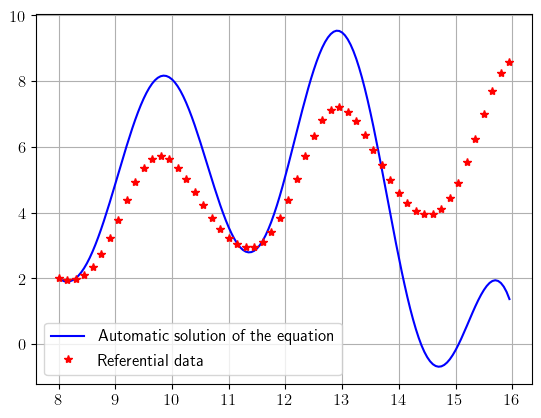

In [91]:
print(f'MAPE on the test dataset is {np.mean(np.abs((pred_u - x_test)/x_test))}')

plt.plot(t_test, pred_u, color = 'b', label = 'Automatic solution of the equation')
plt.plot(t_test[::3], x_test[::3], '*', color = 'r', label = 'Referential data')
plt.grid()
plt.legend()
plt.show()

In the result we can see, that the equation $1.42 t - 3.81 u -0.96 u'' + 0.007 = u' \sin{(2.0 t)}$ can decently describe the process, while the alternative equation is not representative enough.

## Van der Pol oscillator

The problem of non-linear ordinary differential equations discovery can be demonstrated with the Van der Pol oscillator. Initially introduced to describe the relaxation-oscillation cycle produced by the electromagnetic field, the model has found applications in other spheres of science, such as biology or seismology. Its state is governed by equation $u'' + \mathcal{E}(u^2 - 1)u' + u = 0$, where $\mathcal{E}$ is a positive constant (in the example we will use $\mathcal{E} = 0.2$). To prepare synthetic dataset we will again use Runge-Kutta method:

In [98]:
def VdP_by_RK(initial: tuple, timestep: float, steps: int, epsilon: float):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    for step in range(steps-1):
        t = step*timestep
        k1 = res[step, 1] ; x1 = res[step, 0] + timestep/2. * k1
        l1 =  - epsilon*(res[step, 0]**2 - 1)*res[step, 1] - res[step, 0]; y1 = res[step, 1] + timestep/2. * l1

        k2 = y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = - epsilon*(x1**2 - 1)*y1 - x1; y2 = res[step, 1] + timestep/2. * l2

        k3 = y2
        l3 = - epsilon*(x2**2 - 1)*y2 - x2
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = y3
        l4 = - epsilon*(x3**2 - 1)*y3 - x3
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

def prepare_VdP_data(initial = (np.sqrt(3)/2., 1./2.), step = 0.05, steps_num = 640, epsilon = 0.2):
    t = np.arange(start = 0., stop = step * steps_num, step = step)
    solution = VdP_by_RK(initial=initial, timestep=step, steps=steps_num, 
                                      epsilon=epsilon)
    return t, solution

In [126]:
def epde_discovery_as_ode(t, x, use_ann:bool = False):
    dimensionality = x.ndim - 1
    epde_search_obj = epde.EpdeSearch(use_solver = False, dimensionality = dimensionality, boundary = 50,
                                           coordinate_tensors = [t,])
    if use_ann:
        epde_search_obj.set_preprocessor(default_preprocessor_type='ANN',
                                         preprocessor_kwargs={'epochs_max' : 35000})
    else:
        epde_search_obj.set_preprocessor(default_preprocessor_type='poly',
                                         preprocessor_kwargs={'use_smoothing' : True, 'sigma' : 1, 
                                                              'polynomial_window' : 3, 'poly_order' : 3})
    popsize = 12
    epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=100)
    
    factors_max_number = {'factors_num' : [1, 2, 3], 'probas' : [0.4, 0.3, 0.3]}
    
    epde_search_obj.fit(data=[x,], variable_names=['u',], max_deriv_order=(2,),
                        equation_terms_max_number=6, data_fun_pow = 2,
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=(1e-12, 1e1))
    
    epde_search_obj.equations(only_print = True, num = 1)
    
    return epde_search_obj

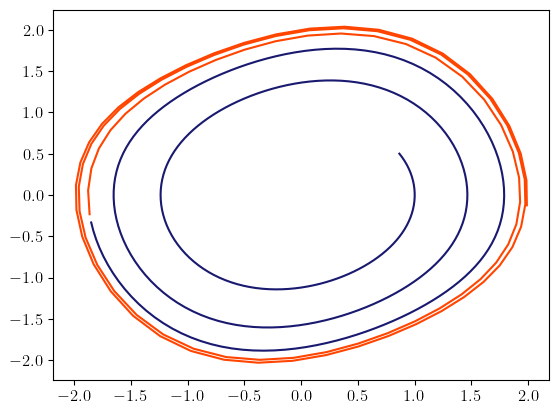

In [127]:
t, x_stacked = prepare_VdP_data()
t_max = 320
x, y = x_stacked[:, 0], x_stacked[:, 1]
t_train, t_test = t[:t_max], t[:t_max]
x_train, x_test = x[:t_max], x[t_max:]
y_train, y_test = y[:t_max], y[t_max:]
plt.plot(x_train, y_train, color = 'midnightblue')
plt.plot(x_test[::3], y_test[::3], color = 'orangered')
plt.show()

In [129]:
epde_search_obj = epde_discovery_as_ode(t_train, x_train, True)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fc1da55e7f0>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fc1da55e7f0>
Deriv orders after definition [[None], [0], [0, 0]]
Surface training t=0, loss=0.9886471033096313
Surface training t=1, loss=0.9427707195281982
Surface training t=2, loss=0.9672328531742096
Surface training t=3, loss=0.9703816771507263
Surface training t=4, loss=0.9534877836704254
Surface training t=5, loss=0.8831912577152252
Surface training t=6, loss=0.9205136001110077
Surface training t=7, loss=0.9216731786727905
Surface training t=8, loss=0.8929721117019653
Surface training t=9, loss=0.9314711689949036
Surface training t=10, loss=0.9022430181503296
Surface training t=11, loss=0.9095550775527954
Surface training t=12, loss=0.9485109448432922
Surface training t=13, loss=0.8985200524330139
Surface training t=14, loss=0.8988443613052368
Surface training t=15, loss=0.9079181849956512
Surface training t=16, loss=0.

Surface training t=183, loss=0.8311417400836945
Surface training t=184, loss=0.8251111507415771
Surface training t=185, loss=0.8179400861263275
Surface training t=186, loss=0.750582754611969
Surface training t=187, loss=0.822142630815506
Surface training t=188, loss=0.8134550452232361
Surface training t=189, loss=0.7724684178829193
Surface training t=190, loss=0.7809622287750244
Surface training t=191, loss=0.775101512670517
Surface training t=192, loss=0.8266279101371765
Surface training t=193, loss=0.825160562992096
Surface training t=194, loss=0.7346524298191071
Surface training t=195, loss=0.805948406457901
Surface training t=196, loss=0.8062301874160767
Surface training t=197, loss=0.8098877668380737
Surface training t=198, loss=0.7856581807136536
Surface training t=199, loss=0.8060660362243652
Surface training t=200, loss=0.831815093755722
Surface training t=201, loss=0.817896157503128
Surface training t=202, loss=0.8262318670749664
Surface training t=203, loss=0.8007483184337616

Surface training t=369, loss=0.7493490278720856
Surface training t=370, loss=0.728399395942688
Surface training t=371, loss=0.7533872723579407
Surface training t=372, loss=0.7769631445407867
Surface training t=373, loss=0.7208417057991028
Surface training t=374, loss=0.7503263652324677
Surface training t=375, loss=0.773250162601471
Surface training t=376, loss=0.6970821917057037
Surface training t=377, loss=0.7650207579135895
Surface training t=378, loss=0.7724440693855286
Surface training t=379, loss=0.7594838440418243
Surface training t=380, loss=0.7592717409133911
Surface training t=381, loss=0.7685916125774384
Surface training t=382, loss=0.7049773037433624
Surface training t=383, loss=0.721996009349823
Surface training t=384, loss=0.7028826177120209
Surface training t=385, loss=0.7391636669635773
Surface training t=386, loss=0.7510725557804108
Surface training t=387, loss=0.7712835669517517
Surface training t=388, loss=0.7432951629161835
Surface training t=389, loss=0.750451982021

Surface training t=557, loss=0.7335785627365112
Surface training t=558, loss=0.7996465563774109
Surface training t=559, loss=0.7331822216510773
Surface training t=560, loss=0.7303139567375183
Surface training t=561, loss=0.753900557756424
Surface training t=562, loss=0.7240837812423706
Surface training t=563, loss=0.7379560172557831
Surface training t=564, loss=0.7360164523124695
Surface training t=565, loss=0.706916332244873
Surface training t=566, loss=0.7648134827613831
Surface training t=567, loss=0.6997851133346558
Surface training t=568, loss=0.6866654753684998
Surface training t=569, loss=0.7547954320907593
Surface training t=570, loss=0.6889091730117798
Surface training t=571, loss=0.7452556788921356
Surface training t=572, loss=0.7430039644241333
Surface training t=573, loss=0.7243649363517761
Surface training t=574, loss=0.7281731069087982
Surface training t=575, loss=0.6830784380435944
Surface training t=576, loss=0.7264013886451721
Surface training t=577, loss=0.71924614906

Surface training t=749, loss=0.7543063461780548
Surface training t=750, loss=0.7194603085517883
Surface training t=751, loss=0.7463642358779907
Surface training t=752, loss=0.7197608053684235
Surface training t=753, loss=0.6490496098995209
Surface training t=754, loss=0.718960702419281
Surface training t=755, loss=0.6767506003379822
Surface training t=756, loss=0.7567952573299408
Surface training t=757, loss=0.6940947473049164
Surface training t=758, loss=0.7004585564136505
Surface training t=759, loss=0.731511265039444
Surface training t=760, loss=0.719746470451355
Surface training t=761, loss=0.7286590337753296
Surface training t=762, loss=0.6941852271556854
Surface training t=763, loss=0.713170737028122
Surface training t=764, loss=0.6698143482208252
Surface training t=765, loss=0.7449012100696564
Surface training t=766, loss=0.6817027926445007
Surface training t=767, loss=0.7364096641540527
Surface training t=768, loss=0.7369137108325958
Surface training t=769, loss=0.7455627322196

Surface training t=942, loss=0.6883070468902588
Surface training t=943, loss=0.7097288966178894
Surface training t=944, loss=0.6895450353622437
Surface training t=945, loss=0.6643058657646179
Surface training t=946, loss=0.7045563459396362
Surface training t=947, loss=0.7344096302986145
Surface training t=948, loss=0.7063700556755066
Surface training t=949, loss=0.7125669717788696
Surface training t=950, loss=0.6978897750377655
Surface training t=951, loss=0.7154608368873596
Surface training t=952, loss=0.6837054193019867
Surface training t=953, loss=0.736769437789917
Surface training t=954, loss=0.702972948551178
Surface training t=955, loss=0.6433483064174652
Surface training t=956, loss=0.6924918293952942
Surface training t=957, loss=0.7022729218006134
Surface training t=958, loss=0.6861046850681305
Surface training t=959, loss=0.6925418674945831
Surface training t=960, loss=0.7304800748825073
Surface training t=961, loss=0.6652023792266846
Surface training t=962, loss=0.65015295147

Surface training t=1122, loss=0.7075830101966858
Surface training t=1123, loss=0.6628279685974121
Surface training t=1124, loss=0.6975196897983551
Surface training t=1125, loss=0.7008666396141052
Surface training t=1126, loss=0.6622483730316162
Surface training t=1127, loss=0.7012901306152344
Surface training t=1128, loss=0.7001358866691589
Surface training t=1129, loss=0.694210022687912
Surface training t=1130, loss=0.6750964522361755
Surface training t=1131, loss=0.7082045078277588
Surface training t=1132, loss=0.6631987690925598
Surface training t=1133, loss=0.655221700668335
Surface training t=1134, loss=0.6902758777141571
Surface training t=1135, loss=0.6910734474658966
Surface training t=1136, loss=0.6668674051761627
Surface training t=1137, loss=0.7298831939697266
Surface training t=1138, loss=0.7263806760311127
Surface training t=1139, loss=0.651524007320404
Surface training t=1140, loss=0.7008337676525116
Surface training t=1141, loss=0.6203329265117645
Surface training t=1142

Surface training t=1300, loss=0.6603861153125763
Surface training t=1301, loss=0.6215182542800903
Surface training t=1302, loss=0.6846041083335876
Surface training t=1303, loss=0.625732958316803
Surface training t=1304, loss=0.7239500284194946
Surface training t=1305, loss=0.6646137833595276
Surface training t=1306, loss=0.6074694097042084
Surface training t=1307, loss=0.6691764295101166
Surface training t=1308, loss=0.6534204483032227
Surface training t=1309, loss=0.6594311594963074
Surface training t=1310, loss=0.5915285497903824
Surface training t=1311, loss=0.6616460978984833
Surface training t=1312, loss=0.6456650197505951
Surface training t=1313, loss=0.685455858707428
Surface training t=1314, loss=0.6400328278541565
Surface training t=1315, loss=0.6523101031780243
Surface training t=1316, loss=0.6646439731121063
Surface training t=1317, loss=0.6451307237148285
Surface training t=1318, loss=0.6849786341190338
Surface training t=1319, loss=0.6363668143749237
Surface training t=132

Surface training t=1487, loss=0.5689104199409485
Surface training t=1488, loss=0.5585772395133972
Surface training t=1489, loss=0.5979010462760925
Surface training t=1490, loss=0.6223300993442535
Surface training t=1491, loss=0.6123720705509186
Surface training t=1492, loss=0.5621511340141296
Surface training t=1493, loss=0.6119587123394012
Surface training t=1494, loss=0.6314526796340942
Surface training t=1495, loss=0.5961701273918152
Surface training t=1496, loss=0.6131268441677094
Surface training t=1497, loss=0.578490674495697
Surface training t=1498, loss=0.6054146587848663
Surface training t=1499, loss=0.5906876027584076
Surface training t=1500, loss=0.6114715337753296
Surface training t=1501, loss=0.5967662036418915
Surface training t=1502, loss=0.6745475828647614
Surface training t=1503, loss=0.6350761651992798
Surface training t=1504, loss=0.5549453496932983
Surface training t=1505, loss=0.5673704743385315
Surface training t=1506, loss=0.6004814207553864
Surface training t=15

Surface training t=1675, loss=0.546603798866272
Surface training t=1676, loss=0.5410367250442505
Surface training t=1677, loss=0.580089271068573
Surface training t=1678, loss=0.5583784282207489
Surface training t=1679, loss=0.5700943171977997
Surface training t=1680, loss=0.5673936307430267
Surface training t=1681, loss=0.5926579535007477
Surface training t=1682, loss=0.5694858133792877
Surface training t=1683, loss=0.5569345951080322
Surface training t=1684, loss=0.5718838572502136
Surface training t=1685, loss=0.5598309934139252
Surface training t=1686, loss=0.5310629606246948
Surface training t=1687, loss=0.5134412497282028
Surface training t=1688, loss=0.5408430099487305
Surface training t=1689, loss=0.4971855580806732
Surface training t=1690, loss=0.5153980553150177
Surface training t=1691, loss=0.5599159002304077
Surface training t=1692, loss=0.5497987568378448
Surface training t=1693, loss=0.5258941054344177
Surface training t=1694, loss=0.5803600549697876
Surface training t=169

Surface training t=1874, loss=0.5379021018743515
Surface training t=1875, loss=0.4973258078098297
Surface training t=1876, loss=0.5177575051784515
Surface training t=1877, loss=0.531436949968338
Surface training t=1878, loss=0.49741213023662567
Surface training t=1879, loss=0.5623323917388916
Surface training t=1880, loss=0.5434858798980713
Surface training t=1881, loss=0.49501122534275055
Surface training t=1882, loss=0.4742158502340317
Surface training t=1883, loss=0.5006833970546722
Surface training t=1884, loss=0.4963088482618332
Surface training t=1885, loss=0.49148157238960266
Surface training t=1886, loss=0.49665313959121704
Surface training t=1887, loss=0.47965218126773834
Surface training t=1888, loss=0.4791076332330704
Surface training t=1889, loss=0.47329235076904297
Surface training t=1890, loss=0.47605228424072266
Surface training t=1891, loss=0.5830558985471725
Surface training t=1892, loss=0.49355660378932953
Surface training t=1893, loss=0.4998473972082138
Surface train

Surface training t=2075, loss=0.46488356590270996
Surface training t=2076, loss=0.5423241406679153
Surface training t=2077, loss=0.5007453411817551
Surface training t=2078, loss=0.4987400025129318
Surface training t=2079, loss=0.4745458662509918
Surface training t=2080, loss=0.4694027155637741
Surface training t=2081, loss=0.4929600656032562
Surface training t=2082, loss=0.46064721047878265
Surface training t=2083, loss=0.4592372477054596
Surface training t=2084, loss=0.4927379935979843
Surface training t=2085, loss=0.48948240280151367
Surface training t=2086, loss=0.4784228354692459
Surface training t=2087, loss=0.5000792443752289
Surface training t=2088, loss=0.43505507707595825
Surface training t=2089, loss=0.42575179040431976
Surface training t=2090, loss=0.4874122589826584
Surface training t=2091, loss=0.4729376435279846
Surface training t=2092, loss=0.5162804424762726
Surface training t=2093, loss=0.45672507584095
Surface training t=2094, loss=0.45309972763061523
Surface training

Surface training t=2277, loss=0.5093806087970734
Surface training t=2278, loss=0.4217377305030823
Surface training t=2279, loss=0.45689284801483154
Surface training t=2280, loss=0.450832262635231
Surface training t=2281, loss=0.4928884506225586
Surface training t=2282, loss=0.46605396270751953
Surface training t=2283, loss=0.44463157653808594
Surface training t=2284, loss=0.43005968630313873
Surface training t=2285, loss=0.4916885495185852
Surface training t=2286, loss=0.4701341986656189
Surface training t=2287, loss=0.47022195160388947
Surface training t=2288, loss=0.4440317451953888
Surface training t=2289, loss=0.43848271667957306
Surface training t=2290, loss=0.44702258706092834
Surface training t=2291, loss=0.51389579474926
Surface training t=2292, loss=0.4566081017255783
Surface training t=2293, loss=0.48316872119903564
Surface training t=2294, loss=0.45359261333942413
Surface training t=2295, loss=0.46988068521022797
Surface training t=2296, loss=0.47830232977867126
Surface trai

Surface training t=2477, loss=0.4280197471380234
Surface training t=2478, loss=0.4886616915464401
Surface training t=2479, loss=0.44441643357276917
Surface training t=2480, loss=0.4214712530374527
Surface training t=2481, loss=0.4630506932735443
Surface training t=2482, loss=0.48081274330616
Surface training t=2483, loss=0.44096820056438446
Surface training t=2484, loss=0.49130500853061676
Surface training t=2485, loss=0.4279588311910629
Surface training t=2486, loss=0.46644924581050873
Surface training t=2487, loss=0.4289615750312805
Surface training t=2488, loss=0.48505645990371704
Surface training t=2489, loss=0.4006112962961197
Surface training t=2490, loss=0.45519615709781647
Surface training t=2491, loss=0.4473772495985031
Surface training t=2492, loss=0.4332427978515625
Surface training t=2493, loss=0.4443042278289795
Surface training t=2494, loss=0.44020161032676697
Surface training t=2495, loss=0.4436393976211548
Surface training t=2496, loss=0.5029331296682358
Surface trainin

Surface training t=2675, loss=0.40685024857521057
Surface training t=2676, loss=0.4492455869913101
Surface training t=2677, loss=0.45587649941444397
Surface training t=2678, loss=0.4870077818632126
Surface training t=2679, loss=0.4429570734500885
Surface training t=2680, loss=0.40543481707572937
Surface training t=2681, loss=0.4968390315771103
Surface training t=2682, loss=0.4439271092414856
Surface training t=2683, loss=0.410059317946434
Surface training t=2684, loss=0.4116511791944504
Surface training t=2685, loss=0.47885146737098694
Surface training t=2686, loss=0.4134751111268997
Surface training t=2687, loss=0.44608037173748016
Surface training t=2688, loss=0.434186726808548
Surface training t=2689, loss=0.4574678838253021
Surface training t=2690, loss=0.4294685274362564
Surface training t=2691, loss=0.5232710242271423
Surface training t=2692, loss=0.4624559134244919
Surface training t=2693, loss=0.4327257573604584
Surface training t=2694, loss=0.44765983521938324
Surface training

Surface training t=2877, loss=0.48279042541980743
Surface training t=2878, loss=0.4419693797826767
Surface training t=2879, loss=0.4657391756772995
Surface training t=2880, loss=0.43593497574329376
Surface training t=2881, loss=0.42491425573825836
Surface training t=2882, loss=0.46391403675079346
Surface training t=2883, loss=0.4265882819890976
Surface training t=2884, loss=0.4214331656694412
Surface training t=2885, loss=0.4486294090747833
Surface training t=2886, loss=0.4373985081911087
Surface training t=2887, loss=0.41185885667800903
Surface training t=2888, loss=0.39825139939785004
Surface training t=2889, loss=0.4791064113378525
Surface training t=2890, loss=0.44182732701301575
Surface training t=2891, loss=0.46555787324905396
Surface training t=2892, loss=0.44631753861904144
Surface training t=2893, loss=0.4982694685459137
Surface training t=2894, loss=0.4083549827337265
Surface training t=2895, loss=0.44999605417251587
Surface training t=2896, loss=0.4513818323612213
Surface tr

Surface training t=3079, loss=0.42405180633068085
Surface training t=3080, loss=0.4115127772092819
Surface training t=3081, loss=0.38243745267391205
Surface training t=3082, loss=0.44410568475723267
Surface training t=3083, loss=0.42696329951286316
Surface training t=3084, loss=0.4374200403690338
Surface training t=3085, loss=0.43699538707733154
Surface training t=3086, loss=0.38679561018943787
Surface training t=3087, loss=0.47015997767448425
Surface training t=3088, loss=0.43570704758167267
Surface training t=3089, loss=0.42498932778835297
Surface training t=3090, loss=0.4007487893104553
Surface training t=3091, loss=0.4019118845462799
Surface training t=3092, loss=0.44524966180324554
Surface training t=3093, loss=0.384991392493248
Surface training t=3094, loss=0.4535289704799652
Surface training t=3095, loss=0.4595429003238678
Surface training t=3096, loss=0.3837016224861145
Surface training t=3097, loss=0.43622009456157684
Surface training t=3098, loss=0.41728827357292175
Surface t

Surface training t=3286, loss=0.4345614016056061
Surface training t=3287, loss=0.4541679620742798
Surface training t=3288, loss=0.4129186272621155
Surface training t=3289, loss=0.38835692405700684
Surface training t=3290, loss=0.438097208738327
Surface training t=3291, loss=0.46631211042404175
Surface training t=3292, loss=0.4509003013372421
Surface training t=3293, loss=0.4177183210849762
Surface training t=3294, loss=0.43794526159763336
Surface training t=3295, loss=0.3999045193195343
Surface training t=3296, loss=0.46429985761642456
Surface training t=3297, loss=0.4278258979320526
Surface training t=3298, loss=0.4046638607978821
Surface training t=3299, loss=0.3725349009037018
Surface training t=3300, loss=0.4927196353673935
Surface training t=3301, loss=0.4291251301765442
Surface training t=3302, loss=0.40412183105945587
Surface training t=3303, loss=0.442422479391098
Surface training t=3304, loss=0.38035283982753754
Surface training t=3305, loss=0.3921457976102829
Surface training

Surface training t=3487, loss=0.40228308737277985
Surface training t=3488, loss=0.41720297932624817
Surface training t=3489, loss=0.3733544796705246
Surface training t=3490, loss=0.3727937191724777
Surface training t=3491, loss=0.4424431622028351
Surface training t=3492, loss=0.40957750380039215
Surface training t=3493, loss=0.4078883230686188
Surface training t=3494, loss=0.40270504355430603
Surface training t=3495, loss=0.41943252086639404
Surface training t=3496, loss=0.3980149030685425
Surface training t=3497, loss=0.47766514122486115
Surface training t=3498, loss=0.39800719916820526
Surface training t=3499, loss=0.38983073830604553
Surface training t=3500, loss=0.4042108952999115
Surface training t=3501, loss=0.4414053410291672
Surface training t=3502, loss=0.41442902386188507
Surface training t=3503, loss=0.3841669261455536
Surface training t=3504, loss=0.3712655305862427
Surface training t=3505, loss=0.42662693560123444
Surface training t=3506, loss=0.40665242075920105
Surface t

Surface training t=3686, loss=0.4614860564470291
Surface training t=3687, loss=0.4128866344690323
Surface training t=3688, loss=0.4465310871601105
Surface training t=3689, loss=0.35154400765895844
Surface training t=3690, loss=0.418986976146698
Surface training t=3691, loss=0.40213197469711304
Surface training t=3692, loss=0.39991454780101776
Surface training t=3693, loss=0.4119623899459839
Surface training t=3694, loss=0.3798840641975403
Surface training t=3695, loss=0.35434170067310333
Surface training t=3696, loss=0.40182188153266907
Surface training t=3697, loss=0.3714784234762192
Surface training t=3698, loss=0.34777551889419556
Surface training t=3699, loss=0.36471064388751984
Surface training t=3700, loss=0.38661518692970276
Surface training t=3701, loss=0.36750657856464386
Surface training t=3702, loss=0.43145619332790375
Surface training t=3703, loss=0.41595734655857086
Surface training t=3704, loss=0.41410768032073975
Surface training t=3705, loss=0.3772621303796768
Surface t

Surface training t=3891, loss=0.382595494389534
Surface training t=3892, loss=0.3566640615463257
Surface training t=3893, loss=0.3998414874076843
Surface training t=3894, loss=0.42439933121204376
Surface training t=3895, loss=0.4387615919113159
Surface training t=3896, loss=0.3908649682998657
Surface training t=3897, loss=0.3950778990983963
Surface training t=3898, loss=0.4337518513202667
Surface training t=3899, loss=0.365881010890007
Surface training t=3900, loss=0.3963879197835922
Surface training t=3901, loss=0.3779745548963547
Surface training t=3902, loss=0.4579348564147949
Surface training t=3903, loss=0.37012559175491333
Surface training t=3904, loss=0.3796849548816681
Surface training t=3905, loss=0.39015568792819977
Surface training t=3906, loss=0.43914443254470825
Surface training t=3907, loss=0.4375288188457489
Surface training t=3908, loss=0.4303712546825409
Surface training t=3909, loss=0.3774087727069855
Surface training t=3910, loss=0.37381233274936676
Surface training 

Surface training t=4095, loss=0.41994403302669525
Surface training t=4096, loss=0.39601004123687744
Surface training t=4097, loss=0.3545200079679489
Surface training t=4098, loss=0.4010414034128189
Surface training t=4099, loss=0.4276617467403412
Surface training t=4100, loss=0.36783313751220703
Surface training t=4101, loss=0.4488302767276764
Surface training t=4102, loss=0.35793887078762054
Surface training t=4103, loss=0.43075820803642273
Surface training t=4104, loss=0.43811123073101044
Surface training t=4105, loss=0.4268387407064438
Surface training t=4106, loss=0.349450945854187
Surface training t=4107, loss=0.43594884872436523
Surface training t=4108, loss=0.4391603618860245
Surface training t=4109, loss=0.4291580021381378
Surface training t=4110, loss=0.4475468695163727
Surface training t=4111, loss=0.47509847581386566
Surface training t=4112, loss=0.41697831451892853
Surface training t=4113, loss=0.3822086751461029
Surface training t=4114, loss=0.39252781867980957
Surface tra

Surface training t=4302, loss=0.37416818737983704
Surface training t=4303, loss=0.38134732842445374
Surface training t=4304, loss=0.3781530112028122
Surface training t=4305, loss=0.3643421232700348
Surface training t=4306, loss=0.3680584281682968
Surface training t=4307, loss=0.3986388146877289
Surface training t=4308, loss=0.38962027430534363
Surface training t=4309, loss=0.3907150626182556
Surface training t=4310, loss=0.3817341476678848
Surface training t=4311, loss=0.3531882166862488
Surface training t=4312, loss=0.3760717958211899
Surface training t=4313, loss=0.40734662115573883
Surface training t=4314, loss=0.3628798723220825
Surface training t=4315, loss=0.4091508239507675
Surface training t=4316, loss=0.34178614616394043
Surface training t=4317, loss=0.40241488814353943
Surface training t=4318, loss=0.398468941450119
Surface training t=4319, loss=0.36917728185653687
Surface training t=4320, loss=0.3768483102321625
Surface training t=4321, loss=0.4205663800239563
Surface traini

Surface training t=4508, loss=0.35294489562511444
Surface training t=4509, loss=0.30525777488946915
Surface training t=4510, loss=0.39752982556819916
Surface training t=4511, loss=0.34861883521080017
Surface training t=4512, loss=0.39940160512924194
Surface training t=4513, loss=0.336132749915123
Surface training t=4514, loss=0.36138124763965607
Surface training t=4515, loss=0.3972701132297516
Surface training t=4516, loss=0.32293180376291275
Surface training t=4517, loss=0.3962497413158417
Surface training t=4518, loss=0.382998526096344
Surface training t=4519, loss=0.3656099736690521
Surface training t=4520, loss=0.33271750807762146
Surface training t=4521, loss=0.3487425446510315
Surface training t=4522, loss=0.3864799439907074
Surface training t=4523, loss=0.35701726377010345
Surface training t=4524, loss=0.32848595082759857
Surface training t=4525, loss=0.3744707256555557
Surface training t=4526, loss=0.34485067427158356
Surface training t=4527, loss=0.39946161210536957
Surface tr

Surface training t=4706, loss=0.36817994713783264
Surface training t=4707, loss=0.2991291359066963
Surface training t=4708, loss=0.36672520637512207
Surface training t=4709, loss=0.34427401423454285
Surface training t=4710, loss=0.36321890354156494
Surface training t=4711, loss=0.35722239315509796
Surface training t=4712, loss=0.3541698157787323
Surface training t=4713, loss=0.33795951306819916
Surface training t=4714, loss=0.32648633420467377
Surface training t=4715, loss=0.35048262774944305
Surface training t=4716, loss=0.36070995032787323
Surface training t=4717, loss=0.32955893874168396
Surface training t=4718, loss=0.3447103053331375
Surface training t=4719, loss=0.38561876118183136
Surface training t=4720, loss=0.32803651690483093
Surface training t=4721, loss=0.31871648132801056
Surface training t=4722, loss=0.35296526551246643
Surface training t=4723, loss=0.35386501252651215
Surface training t=4724, loss=0.34947003424167633
Surface training t=4725, loss=0.3464714288711548
Surf

Surface training t=4907, loss=0.3308414816856384
Surface training t=4908, loss=0.31015458703041077
Surface training t=4909, loss=0.30463728308677673
Surface training t=4910, loss=0.32008279860019684
Surface training t=4911, loss=0.2951040714979172
Surface training t=4912, loss=0.33702829480171204
Surface training t=4913, loss=0.35228487849235535
Surface training t=4914, loss=0.3253467530012131
Surface training t=4915, loss=0.31549473106861115
Surface training t=4916, loss=0.3241606503725052
Surface training t=4917, loss=0.3779056668281555
Surface training t=4918, loss=0.3728039711713791
Surface training t=4919, loss=0.3220500349998474
Surface training t=4920, loss=0.30301307141780853
Surface training t=4921, loss=0.340562641620636
Surface training t=4922, loss=0.3344928175210953
Surface training t=4923, loss=0.32043473422527313
Surface training t=4924, loss=0.34644582867622375
Surface training t=4925, loss=0.3452429920434952
Surface training t=4926, loss=0.3113253712654114
Surface trai

Surface training t=5127, loss=0.31235918402671814
Surface training t=5128, loss=0.2967495620250702
Surface training t=5129, loss=0.3284297585487366
Surface training t=5130, loss=0.32267408072948456
Surface training t=5131, loss=0.3147778809070587
Surface training t=5132, loss=0.3006099611520767
Surface training t=5133, loss=0.3322066217660904
Surface training t=5134, loss=0.3064575344324112
Surface training t=5135, loss=0.32586970925331116
Surface training t=5136, loss=0.3398517370223999
Surface training t=5137, loss=0.3024972528219223
Surface training t=5138, loss=0.3421929031610489
Surface training t=5139, loss=0.37816308438777924
Surface training t=5140, loss=0.33107152581214905
Surface training t=5141, loss=0.3079499751329422
Surface training t=5142, loss=0.33051906526088715
Surface training t=5143, loss=0.31433480978012085
Surface training t=5144, loss=0.37207408249378204
Surface training t=5145, loss=0.3656528890132904
Surface training t=5146, loss=0.28585386276245117
Surface tra

Surface training t=5336, loss=0.3154228627681732
Surface training t=5337, loss=0.3168509304523468
Surface training t=5338, loss=0.28224068880081177
Surface training t=5339, loss=0.2504410520195961
Surface training t=5340, loss=0.32608552277088165
Surface training t=5341, loss=0.30940762162208557
Surface training t=5342, loss=0.27408795058727264
Surface training t=5343, loss=0.3019694983959198
Surface training t=5344, loss=0.2762930616736412
Surface training t=5345, loss=0.31256940960884094
Surface training t=5346, loss=0.3233474940061569
Surface training t=5347, loss=0.2736572101712227
Surface training t=5348, loss=0.3227270543575287
Surface training t=5349, loss=0.3103865683078766
Surface training t=5350, loss=0.3080551028251648
Surface training t=5351, loss=0.26782675832509995
Surface training t=5352, loss=0.30565614998340607
Surface training t=5353, loss=0.26875555515289307
Surface training t=5354, loss=0.31428076326847076
Surface training t=5355, loss=0.27720676362514496
Surface tr

Surface training t=5542, loss=0.27138882875442505
Surface training t=5543, loss=0.2844187170267105
Surface training t=5544, loss=0.31356102228164673
Surface training t=5545, loss=0.292723685503006
Surface training t=5546, loss=0.25311287492513657
Surface training t=5547, loss=0.27689386904239655
Surface training t=5548, loss=0.232448011636734
Surface training t=5549, loss=0.2797639071941376
Surface training t=5550, loss=0.28144100308418274
Surface training t=5551, loss=0.2877567410469055
Surface training t=5552, loss=0.2668849527835846
Surface training t=5553, loss=0.2677518427371979
Surface training t=5554, loss=0.2960076481103897
Surface training t=5555, loss=0.26236240565776825
Surface training t=5556, loss=0.294985368847847
Surface training t=5557, loss=0.2961774542927742
Surface training t=5558, loss=0.24526813626289368
Surface training t=5559, loss=0.25140950083732605
Surface training t=5560, loss=0.2658272981643677
Surface training t=5561, loss=0.2498021125793457
Surface trainin

Surface training t=5756, loss=0.28181685507297516
Surface training t=5757, loss=0.26344049721956253
Surface training t=5758, loss=0.29710108041763306
Surface training t=5759, loss=0.26785653829574585
Surface training t=5760, loss=0.2803667336702347
Surface training t=5761, loss=0.2631390243768692
Surface training t=5762, loss=0.24363144487142563
Surface training t=5763, loss=0.2489042654633522
Surface training t=5764, loss=0.23085515946149826
Surface training t=5765, loss=0.25608067214488983
Surface training t=5766, loss=0.22413869947195053
Surface training t=5767, loss=0.25395335257053375
Surface training t=5768, loss=0.22599677741527557
Surface training t=5769, loss=0.24030011147260666
Surface training t=5770, loss=0.24892005324363708
Surface training t=5771, loss=0.23929309844970703
Surface training t=5772, loss=0.2633812129497528
Surface training t=5773, loss=0.24674811959266663
Surface training t=5774, loss=0.26250315457582474
Surface training t=5775, loss=0.29356078058481216
Surf

Surface training t=5965, loss=0.18715417385101318
Surface training t=5966, loss=0.18970079720020294
Surface training t=5967, loss=0.20867151021957397
Surface training t=5968, loss=0.19249319285154343
Surface training t=5969, loss=0.18866565078496933
Surface training t=5970, loss=0.18043142557144165
Surface training t=5971, loss=0.1899040788412094
Surface training t=5972, loss=0.19732214510440826
Surface training t=5973, loss=0.20987335592508316
Surface training t=5974, loss=0.1936940923333168
Surface training t=5975, loss=0.18381508439779282
Surface training t=5976, loss=0.20701026171445847
Surface training t=5977, loss=0.18307068198919296
Surface training t=5978, loss=0.1885962411761284
Surface training t=5979, loss=0.1919693499803543
Surface training t=5980, loss=0.18375688791275024
Surface training t=5981, loss=0.1890314668416977
Surface training t=5982, loss=0.20804809033870697
Surface training t=5983, loss=0.19155900925397873
Surface training t=5984, loss=0.15697254985570908
Surfa

Surface training t=6165, loss=0.14169222116470337
Surface training t=6166, loss=0.13859302550554276
Surface training t=6167, loss=0.1399461254477501
Surface training t=6168, loss=0.13400553166866302
Surface training t=6169, loss=0.12007201462984085
Surface training t=6170, loss=0.12699957191944122
Surface training t=6171, loss=0.13865924626588821
Surface training t=6172, loss=0.13573505729436874
Surface training t=6173, loss=0.1321863755583763
Surface training t=6174, loss=0.12254073843359947
Surface training t=6175, loss=0.1411471739411354
Surface training t=6176, loss=0.15004030615091324
Surface training t=6177, loss=0.14053325355052948
Surface training t=6178, loss=0.11494629085063934
Surface training t=6179, loss=0.1549944281578064
Surface training t=6180, loss=0.17885801196098328
Surface training t=6181, loss=0.16520866751670837
Surface training t=6182, loss=0.19184453040361404
Surface training t=6183, loss=0.1764288693666458
Surface training t=6184, loss=0.1491750255227089
Surfac

Surface training t=6367, loss=0.0787622518837452
Surface training t=6368, loss=0.06521524488925934
Surface training t=6369, loss=0.07176929339766502
Surface training t=6370, loss=0.07974477857351303
Surface training t=6371, loss=0.07878698408603668
Surface training t=6372, loss=0.09860457479953766
Surface training t=6373, loss=0.10441012680530548
Surface training t=6374, loss=0.11296579614281654
Surface training t=6375, loss=0.12415020167827606
Surface training t=6376, loss=0.09233628585934639
Surface training t=6377, loss=0.10202889889478683
Surface training t=6378, loss=0.09441499039530754
Surface training t=6379, loss=0.08965088799595833
Surface training t=6380, loss=0.09817822650074959
Surface training t=6381, loss=0.08105646818876266
Surface training t=6382, loss=0.07835578918457031
Surface training t=6383, loss=0.09217649698257446
Surface training t=6384, loss=0.10457371547818184
Surface training t=6385, loss=0.08166946284472942
Surface training t=6386, loss=0.08332228660583496
S

Surface training t=6535, loss=0.08263273909687996
Surface training t=6536, loss=0.07509677484631538
Surface training t=6537, loss=0.06775899045169353
Surface training t=6538, loss=0.05697708763182163
Surface training t=6539, loss=0.062465643510222435
Surface training t=6540, loss=0.06831344403326511
Surface training t=6541, loss=0.0691518783569336
Surface training t=6542, loss=0.07015266828238964
Surface training t=6543, loss=0.07522526755928993
Surface training t=6544, loss=0.05927532911300659
Surface training t=6545, loss=0.09363263100385666
Surface training t=6546, loss=0.06246895156800747
Surface training t=6547, loss=0.06279245391488075
Surface training t=6548, loss=0.08215402066707611
Surface training t=6549, loss=0.0809592455625534
Surface training t=6550, loss=0.06643397733569145
Surface training t=6551, loss=0.055719420313835144
Surface training t=6552, loss=0.08855758607387543
Surface training t=6553, loss=0.06214790791273117
Surface training t=6554, loss=0.06904836371541023


Surface training t=6750, loss=0.05680453963577747
Surface training t=6751, loss=0.05918400548398495
Surface training t=6752, loss=0.06044897437095642
Surface training t=6753, loss=0.05117589421570301
Surface training t=6754, loss=0.04509519226849079
Surface training t=6755, loss=0.0514133982360363
Surface training t=6756, loss=0.06894635036587715
Surface training t=6757, loss=0.0689119566231966
Surface training t=6758, loss=0.06560586765408516
Surface training t=6759, loss=0.05514034256339073
Surface training t=6760, loss=0.05582304298877716
Surface training t=6761, loss=0.04877492040395737
Surface training t=6762, loss=0.0577834527939558
Surface training t=6763, loss=0.047458846122026443
Surface training t=6764, loss=0.04555273987352848
Surface training t=6765, loss=0.046605708077549934
Surface training t=6766, loss=0.04774414375424385
Surface training t=6767, loss=0.04327121935784817
Surface training t=6768, loss=0.046833792701363564
Surface training t=6769, loss=0.039917461574077606

Surface training t=6958, loss=0.03997540660202503
Surface training t=6959, loss=0.034204003401100636
Surface training t=6960, loss=0.03698467090725899
Surface training t=6961, loss=0.031872011721134186
Surface training t=6962, loss=0.03813878819346428
Surface training t=6963, loss=0.039637716487050056
Surface training t=6964, loss=0.04164249636232853
Surface training t=6965, loss=0.03388249687850475
Surface training t=6966, loss=0.03253595717251301
Surface training t=6967, loss=0.0301474342122674
Surface training t=6968, loss=0.033372364938259125
Surface training t=6969, loss=0.0355071984231472
Surface training t=6970, loss=0.04580157622694969
Surface training t=6971, loss=0.05048590898513794
Surface training t=6972, loss=0.04722149111330509
Surface training t=6973, loss=0.04344245605170727
Surface training t=6974, loss=0.04829563573002815
Surface training t=6975, loss=0.04401862807571888
Surface training t=6976, loss=0.040138816460967064
Surface training t=6977, loss=0.055313291028141

Surface training t=7158, loss=0.039857013151049614
Surface training t=7159, loss=0.03572567366063595
Surface training t=7160, loss=0.040665747597813606
Surface training t=7161, loss=0.04028290510177612
Surface training t=7162, loss=0.0505054946988821
Surface training t=7163, loss=0.048755815252661705
Surface training t=7164, loss=0.04793514311313629
Surface training t=7165, loss=0.05106751434504986
Surface training t=7166, loss=0.06215151026844978
Surface training t=7167, loss=0.05996991507709026
Surface training t=7168, loss=0.05185800604522228
Surface training t=7169, loss=0.05069417878985405
Surface training t=7170, loss=0.05913340672850609
Surface training t=7171, loss=0.05077727138996124
Surface training t=7172, loss=0.045458871871232986
Surface training t=7173, loss=0.0415475033223629
Surface training t=7174, loss=0.048806801438331604
Surface training t=7175, loss=0.056321464478969574
Surface training t=7176, loss=0.0650075227022171
Surface training t=7177, loss=0.045565878972411

Surface training t=7351, loss=0.03671680763363838
Surface training t=7352, loss=0.04072875529527664
Surface training t=7353, loss=0.06944437138736248
Surface training t=7354, loss=0.06746687740087509
Surface training t=7355, loss=0.05263223499059677
Surface training t=7356, loss=0.060009174048900604
Surface training t=7357, loss=0.066951435059309
Surface training t=7358, loss=0.05759923905134201
Surface training t=7359, loss=0.0676748976111412
Surface training t=7360, loss=0.054337095469236374
Surface training t=7361, loss=0.05804967321455479
Surface training t=7362, loss=0.06469338946044445
Surface training t=7363, loss=0.05915950797498226
Surface training t=7364, loss=0.049072328954935074
Surface training t=7365, loss=0.0506149735301733
Surface training t=7366, loss=0.05781533569097519
Surface training t=7367, loss=0.07533631101250648
Surface training t=7368, loss=0.06476636230945587
Surface training t=7369, loss=0.04850519262254238
Surface training t=7370, loss=0.04039045795798302
S

Surface training t=7559, loss=0.03752314858138561
Surface training t=7560, loss=0.03702545911073685
Surface training t=7561, loss=0.07589799910783768
Surface training t=7562, loss=0.07456863671541214
Surface training t=7563, loss=0.03838946111500263
Surface training t=7564, loss=0.056856902316212654
Surface training t=7565, loss=0.03406102769076824
Surface training t=7566, loss=0.028543181717395782
Surface training t=7567, loss=0.0268198074772954
Surface training t=7568, loss=0.029810383915901184
Surface training t=7569, loss=0.033697815611958504
Surface training t=7570, loss=0.041385771706700325
Surface training t=7571, loss=0.10010123625397682
Surface training t=7572, loss=0.07220340333878994
Surface training t=7573, loss=0.06700139120221138
Surface training t=7574, loss=0.07772399485111237
Surface training t=7575, loss=0.12788764387369156
Surface training t=7576, loss=0.08751999959349632
Surface training t=7577, loss=0.09235880337655544
Surface training t=7578, loss=0.15938981622457

Surface training t=7777, loss=0.044762369245290756
Surface training t=7778, loss=0.04742545820772648
Surface training t=7779, loss=0.03678876906633377
Surface training t=7780, loss=0.0387073690071702
Surface training t=7781, loss=0.04501793719828129
Surface training t=7782, loss=0.041009822860360146
Surface training t=7783, loss=0.03657203633338213
Surface training t=7784, loss=0.03992369957268238
Surface training t=7785, loss=0.05063782446086407
Surface training t=7786, loss=0.04253164678812027
Surface training t=7787, loss=0.03677576594054699
Surface training t=7788, loss=0.039170049130916595
Surface training t=7789, loss=0.04646126180887222
Surface training t=7790, loss=0.05096246302127838
Surface training t=7791, loss=0.051091439090669155
Surface training t=7792, loss=0.08685633167624474
Surface training t=7793, loss=0.06547893956303596
Surface training t=7794, loss=0.054038478061556816
Surface training t=7795, loss=0.06512981653213501
Surface training t=7796, loss=0.06663591600954

Surface training t=7996, loss=0.046960316598415375
Surface training t=7997, loss=0.044606005772948265
Surface training t=7998, loss=0.05748092383146286
Surface training t=7999, loss=0.05876355990767479
Surface training t=8000, loss=0.05244305171072483
Surface training t=8001, loss=0.066917534917593
Surface training t=8002, loss=0.056591471657156944
Surface training t=8003, loss=0.052410783246159554
Surface training t=8004, loss=0.04822654463350773
Surface training t=8005, loss=0.0535406693816185
Surface training t=8006, loss=0.0480313915759325
Surface training t=8007, loss=0.04356429539620876
Surface training t=8008, loss=0.07724859192967415
Surface training t=8009, loss=0.06835866905748844
Surface training t=8010, loss=0.06696313433349133
Surface training t=8011, loss=0.05365658365190029
Surface training t=8012, loss=0.06329476088285446
Surface training t=8013, loss=0.06599670276045799
Surface training t=8014, loss=0.051139770075678825
Surface training t=8015, loss=0.04681192897260189

Surface training t=8203, loss=0.1050790511071682
Surface training t=8204, loss=0.06701423786580563
Surface training t=8205, loss=0.051142552867531776
Surface training t=8206, loss=0.06305070035159588
Surface training t=8207, loss=0.05264591798186302
Surface training t=8208, loss=0.041321054100990295
Surface training t=8209, loss=0.037438973784446716
Surface training t=8210, loss=0.028422240167856216
Surface training t=8211, loss=0.029197183437645435
Surface training t=8212, loss=0.02552660834044218
Surface training t=8213, loss=0.02770450245589018
Surface training t=8214, loss=0.026722535490989685
Surface training t=8215, loss=0.025469756685197353
Surface training t=8216, loss=0.03209039755165577
Surface training t=8217, loss=0.03133351635187864
Surface training t=8218, loss=0.03225865215063095
Surface training t=8219, loss=0.035759568214416504
Surface training t=8220, loss=0.04295361787080765
Surface training t=8221, loss=0.050283435732126236
Surface training t=8222, loss=0.0407656952

Surface training t=8421, loss=0.03806858882308006
Surface training t=8422, loss=0.03419074974954128
Surface training t=8423, loss=0.03777211345732212
Surface training t=8424, loss=0.050778916105628014
Surface training t=8425, loss=0.052591562271118164
Surface training t=8426, loss=0.0322908740490675
Surface training t=8427, loss=0.037472331896424294
Surface training t=8428, loss=0.045466091483831406
Surface training t=8429, loss=0.032402606680989265
Surface training t=8430, loss=0.027437803335487843
Surface training t=8431, loss=0.023364226333796978
Surface training t=8432, loss=0.03125680051743984
Surface training t=8433, loss=0.04286826401948929
Surface training t=8434, loss=0.03168961778283119
Surface training t=8435, loss=0.03529270365834236
Surface training t=8436, loss=0.04103880934417248
Surface training t=8437, loss=0.033197845332324505
Surface training t=8438, loss=0.042486466467380524
Surface training t=8439, loss=0.03246404882520437
Surface training t=8440, loss=0.0348375756

Surface training t=8590, loss=0.04120366647839546
Surface training t=8591, loss=0.04495367035269737
Surface training t=8592, loss=0.06304826959967613
Surface training t=8593, loss=0.040725940838456154
Surface training t=8594, loss=0.04425687901675701
Surface training t=8595, loss=0.050428127869963646
Surface training t=8596, loss=0.03355045057833195
Surface training t=8597, loss=0.034738507121801376
Surface training t=8598, loss=0.04613933898508549
Surface training t=8599, loss=0.04045627452433109
Surface training t=8600, loss=0.04175115469843149
Surface training t=8601, loss=0.045630889013409615
Surface training t=8602, loss=0.03943430818617344
Surface training t=8603, loss=0.045000456273555756
Surface training t=8604, loss=0.061066970229148865
Surface training t=8605, loss=0.043608732521533966
Surface training t=8606, loss=0.05655316822230816
Surface training t=8607, loss=0.05448123812675476
Surface training t=8608, loss=0.07207123935222626
Surface training t=8609, loss=0.06199603155

Surface training t=8790, loss=0.03267552703619003
Surface training t=8791, loss=0.04127473570406437
Surface training t=8792, loss=0.05244019255042076
Surface training t=8793, loss=0.058395497500896454
Surface training t=8794, loss=0.0414341539144516
Surface training t=8795, loss=0.03466613404452801
Surface training t=8796, loss=0.049307992681860924
Surface training t=8797, loss=0.024167467840015888
Surface training t=8798, loss=0.04487140476703644
Surface training t=8799, loss=0.06434222310781479
Surface training t=8800, loss=0.06342291086912155
Surface training t=8801, loss=0.046335915103554726
Surface training t=8802, loss=0.05392441060394049
Surface training t=8803, loss=0.06154932640492916
Surface training t=8804, loss=0.06527073122560978
Surface training t=8805, loss=0.08735622093081474
Surface training t=8806, loss=0.054115382954478264
Surface training t=8807, loss=0.05083785019814968
Surface training t=8808, loss=0.047687262296676636
Surface training t=8809, loss=0.0600924901664

Surface training t=8997, loss=0.06467096880078316
Surface training t=8998, loss=0.052940307185053825
Surface training t=8999, loss=0.03787241503596306
Surface training t=9000, loss=0.033488526940345764
Surface training t=9001, loss=0.03219687845557928
Surface training t=9002, loss=0.03747228439897299
Surface training t=9003, loss=0.03788110613822937
Surface training t=9004, loss=0.03870030306279659
Surface training t=9005, loss=0.041955405846238136
Surface training t=9006, loss=0.04036170430481434
Surface training t=9007, loss=0.040683429688215256
Surface training t=9008, loss=0.043087467551231384
Surface training t=9009, loss=0.04776549153029919
Surface training t=9010, loss=0.05009455792605877
Surface training t=9011, loss=0.03985644690692425
Surface training t=9012, loss=0.04667816869914532
Surface training t=9013, loss=0.04011625424027443
Surface training t=9014, loss=0.034620506688952446
Surface training t=9015, loss=0.02624970953911543
Surface training t=9016, loss=0.027836056426

Surface training t=9203, loss=0.036486171185970306
Surface training t=9204, loss=0.043193329125642776
Surface training t=9205, loss=0.0495010893791914
Surface training t=9206, loss=0.06461868435144424
Surface training t=9207, loss=0.06637059524655342
Surface training t=9208, loss=0.07368624582886696
Surface training t=9209, loss=0.0578827690333128
Surface training t=9210, loss=0.07283424213528633
Surface training t=9211, loss=0.06037662923336029
Surface training t=9212, loss=0.053349947556853294
Surface training t=9213, loss=0.042936135083436966
Surface training t=9214, loss=0.04430665820837021
Surface training t=9215, loss=0.04387260787189007
Surface training t=9216, loss=0.04928137548267841
Surface training t=9217, loss=0.03875306900590658
Surface training t=9218, loss=0.037214649841189384
Surface training t=9219, loss=0.033042967319488525
Surface training t=9220, loss=0.03553689271211624
Surface training t=9221, loss=0.030580446124076843
Surface training t=9222, loss=0.0263682380318

Surface training t=9411, loss=0.04531131125986576
Surface training t=9412, loss=0.040717482566833496
Surface training t=9413, loss=0.039907658472657204
Surface training t=9414, loss=0.034401108510792255
Surface training t=9415, loss=0.03297878336161375
Surface training t=9416, loss=0.03137690760195255
Surface training t=9417, loss=0.05117006041109562
Surface training t=9418, loss=0.039555517956614494
Surface training t=9419, loss=0.036402941681444645
Surface training t=9420, loss=0.04861992411315441
Surface training t=9421, loss=0.03445363789796829
Surface training t=9422, loss=0.052827904000878334
Surface training t=9423, loss=0.03459468297660351
Surface training t=9424, loss=0.03765659686177969
Surface training t=9425, loss=0.046241870149970055
Surface training t=9426, loss=0.03740713093429804
Surface training t=9427, loss=0.045330965891480446
Surface training t=9428, loss=0.05775504559278488
Surface training t=9429, loss=0.03484032861888409
Surface training t=9430, loss=0.0442508626

Surface training t=9576, loss=0.061697859317064285
Surface training t=9577, loss=0.050147656351327896
Surface training t=9578, loss=0.04457305930554867
Surface training t=9579, loss=0.040787141770124435
Surface training t=9580, loss=0.05068940483033657
Surface training t=9581, loss=0.03779012709856033
Surface training t=9582, loss=0.04037729650735855
Surface training t=9583, loss=0.03928259201347828
Surface training t=9584, loss=0.029398612678050995
Surface training t=9585, loss=0.021959098055958748
Surface training t=9586, loss=0.027613315731287003
Surface training t=9587, loss=0.03114286530762911
Surface training t=9588, loss=0.029583580791950226
Surface training t=9589, loss=0.02349835354834795
Surface training t=9590, loss=0.023457981646060944
Surface training t=9591, loss=0.029532795771956444
Surface training t=9592, loss=0.03228394128382206
Surface training t=9593, loss=0.05022148974239826
Surface training t=9594, loss=0.08519252017140388
Surface training t=9595, loss=0.057154994

Surface training t=9781, loss=0.046845052391290665
Surface training t=9782, loss=0.05558740720152855
Surface training t=9783, loss=0.042470917105674744
Surface training t=9784, loss=0.04015364404767752
Surface training t=9785, loss=0.05125902406871319
Surface training t=9786, loss=0.03614345006644726
Surface training t=9787, loss=0.034554870799183846
Surface training t=9788, loss=0.03435451164841652
Surface training t=9789, loss=0.03089738730341196
Surface training t=9790, loss=0.031422413885593414
Surface training t=9791, loss=0.02586725540459156
Surface training t=9792, loss=0.027485317550599575
Surface training t=9793, loss=0.028855178505182266
Surface training t=9794, loss=0.025477871298789978
Surface training t=9795, loss=0.024517958983778954
Surface training t=9796, loss=0.03277725912630558
Surface training t=9797, loss=0.03995757922530174
Surface training t=9798, loss=0.02935598697513342
Surface training t=9799, loss=0.04120850935578346
Surface training t=9800, loss=0.0323500363

Surface training t=9979, loss=0.03513842076063156
Surface training t=9980, loss=0.02911230083554983
Surface training t=9981, loss=0.03213627636432648
Surface training t=9982, loss=0.035955335944890976
Surface training t=9983, loss=0.026778013445436954
Surface training t=9984, loss=0.028628237545490265
Surface training t=9985, loss=0.019306113477796316
Surface training t=9986, loss=0.021754919551312923
Surface training t=9987, loss=0.021722011268138885
Surface training t=9988, loss=0.02328298892825842
Surface training t=9989, loss=0.03128358907997608
Surface training t=9990, loss=0.031944140791893005
Surface training t=9991, loss=0.03851511888206005
Surface training t=9992, loss=0.045129429548978806
Surface training t=9993, loss=0.04487387277185917
Surface training t=9994, loss=0.04326272942125797
Surface training t=9995, loss=0.0630657747387886
Surface training t=9996, loss=0.061392663046717644
Surface training t=9997, loss=0.05690637230873108
Surface training t=9998, loss=0.0686158444

Surface training t=10142, loss=0.05164557881653309
Surface training t=10143, loss=0.050653401762247086
Surface training t=10144, loss=0.05137175880372524
Surface training t=10145, loss=0.08287498354911804
Surface training t=10146, loss=0.047613443806767464
Surface training t=10147, loss=0.04886421002447605
Surface training t=10148, loss=0.03512655571103096
Surface training t=10149, loss=0.030551722273230553
Surface training t=10150, loss=0.03185121342539787
Surface training t=10151, loss=0.03168782405555248
Surface training t=10152, loss=0.026615488342940807
Surface training t=10153, loss=0.024617253802716732
Surface training t=10154, loss=0.02414338756352663
Surface training t=10155, loss=0.02661123964935541
Surface training t=10156, loss=0.03253814112395048
Surface training t=10157, loss=0.0468501690775156
Surface training t=10158, loss=0.04174484871327877
Surface training t=10159, loss=0.039210086688399315
Surface training t=10160, loss=0.0551311019808054
Surface training t=10161, l

Surface training t=10308, loss=0.022264442406594753
Surface training t=10309, loss=0.034806784242391586
Surface training t=10310, loss=0.029838894493877888
Surface training t=10311, loss=0.01955081894993782
Surface training t=10312, loss=0.025854877196252346
Surface training t=10313, loss=0.021305694244801998
Surface training t=10314, loss=0.019803152419626713
Surface training t=10315, loss=0.02099719177931547
Surface training t=10316, loss=0.021786095574498177
Surface training t=10317, loss=0.031986369751393795
Surface training t=10318, loss=0.02350609190762043
Surface training t=10319, loss=0.025771548971533775
Surface training t=10320, loss=0.022226085886359215
Surface training t=10321, loss=0.025358865037560463
Surface training t=10322, loss=0.03148622810840607
Surface training t=10323, loss=0.042726971209049225
Surface training t=10324, loss=0.0317647960036993
Surface training t=10325, loss=0.04019859805703163
Surface training t=10326, loss=0.041154056787490845
Surface training t=

Surface training t=10473, loss=0.02667766809463501
Surface training t=10474, loss=0.02154628373682499
Surface training t=10475, loss=0.023650379851460457
Surface training t=10476, loss=0.027034244500100613
Surface training t=10477, loss=0.027596281841397285
Surface training t=10478, loss=0.03154455218464136
Surface training t=10479, loss=0.04870262183248997
Surface training t=10480, loss=0.03482109121978283
Surface training t=10481, loss=0.026511293835937977
Surface training t=10482, loss=0.048429735004901886
Surface training t=10483, loss=0.03266201540827751
Surface training t=10484, loss=0.0327626820653677
Surface training t=10485, loss=0.03288419172167778
Surface training t=10486, loss=0.02870188932865858
Surface training t=10487, loss=0.03912295773625374
Surface training t=10488, loss=0.036443707533180714
Surface training t=10489, loss=0.04158764239400625
Surface training t=10490, loss=0.04852004162967205
Surface training t=10491, loss=0.04033356253057718
Surface training t=10492, 

Surface training t=10639, loss=0.03135202545672655
Surface training t=10640, loss=0.0339801786467433
Surface training t=10641, loss=0.04048769734799862
Surface training t=10642, loss=0.029940308071672916
Surface training t=10643, loss=0.02939990535378456
Surface training t=10644, loss=0.04992597550153732
Surface training t=10645, loss=0.03702995181083679
Surface training t=10646, loss=0.04777006804943085
Surface training t=10647, loss=0.037252962589263916
Surface training t=10648, loss=0.03960291109979153
Surface training t=10649, loss=0.03490830771625042
Surface training t=10650, loss=0.03681675344705582
Surface training t=10651, loss=0.030155791901051998
Surface training t=10652, loss=0.04036552272737026
Surface training t=10653, loss=0.03737049363553524
Surface training t=10654, loss=0.034311854280531406
Surface training t=10655, loss=0.038804154843091965
Surface training t=10656, loss=0.046590808779001236
Surface training t=10657, loss=0.035832544788718224
Surface training t=10658,

Surface training t=10804, loss=0.02182989288121462
Surface training t=10805, loss=0.02125230897217989
Surface training t=10806, loss=0.02671710727736354
Surface training t=10807, loss=0.026030404958873987
Surface training t=10808, loss=0.030275175347924232
Surface training t=10809, loss=0.03423696104437113
Surface training t=10810, loss=0.031982299871742725
Surface training t=10811, loss=0.027277909219264984
Surface training t=10812, loss=0.024952255189418793
Surface training t=10813, loss=0.028680535964667797
Surface training t=10814, loss=0.018084790091961622
Surface training t=10815, loss=0.020466486923396587
Surface training t=10816, loss=0.022014047019183636
Surface training t=10817, loss=0.016064967960119247
Surface training t=10818, loss=0.01880833599716425
Surface training t=10819, loss=0.027507459744811058
Surface training t=10820, loss=0.02903564739972353
Surface training t=10821, loss=0.018083248287439346
Surface training t=10822, loss=0.02270052209496498
Surface training t=

Surface training t=10974, loss=0.05945497378706932
Surface training t=10975, loss=0.05200235918164253
Surface training t=10976, loss=0.05681310594081879
Surface training t=10977, loss=0.052025919780135155
Surface training t=10978, loss=0.04708333872258663
Surface training t=10979, loss=0.04061117768287659
Surface training t=10980, loss=0.03346690535545349
Surface training t=10981, loss=0.04556695744395256
Surface training t=10982, loss=0.035431066527962685
Surface training t=10983, loss=0.033076317980885506
Surface training t=10984, loss=0.04061114601790905
Surface training t=10985, loss=0.037828246131539345
Surface training t=10986, loss=0.027516289614140987
Surface training t=10987, loss=0.03378842584788799
Surface training t=10988, loss=0.0381292849779129
Surface training t=10989, loss=0.03625165857374668
Surface training t=10990, loss=0.0380301745608449
Surface training t=10991, loss=0.030732966028153896
Surface training t=10992, loss=0.02800859697163105
Surface training t=10993, l

Surface training t=11179, loss=0.027279495261609554
Surface training t=11180, loss=0.028030581772327423
Surface training t=11181, loss=0.028657400980591774
Surface training t=11182, loss=0.029748951084911823
Surface training t=11183, loss=0.025320883840322495
Surface training t=11184, loss=0.026166697964072227
Surface training t=11185, loss=0.0335750300437212
Surface training t=11186, loss=0.0441119447350502
Surface training t=11187, loss=0.03149466495960951
Surface training t=11188, loss=0.025491079315543175
Surface training t=11189, loss=0.038921624422073364
Surface training t=11190, loss=0.04754873551428318
Surface training t=11191, loss=0.0407584011554718
Surface training t=11192, loss=0.04826445318758488
Surface training t=11193, loss=0.0325331874191761
Surface training t=11194, loss=0.039123523980379105
Surface training t=11195, loss=0.029299885034561157
Surface training t=11196, loss=0.04828532412648201
Surface training t=11197, loss=0.058950796723365784
Surface training t=11198

Surface training t=11340, loss=0.06256229057908058
Surface training t=11341, loss=0.04694327898323536
Surface training t=11342, loss=0.03773123025894165
Surface training t=11343, loss=0.04292144253849983
Surface training t=11344, loss=0.029991980642080307
Surface training t=11345, loss=0.037470631301403046
Surface training t=11346, loss=0.06253634765744209
Surface training t=11347, loss=0.05321370251476765
Surface training t=11348, loss=0.04693162068724632
Surface training t=11349, loss=0.05876714177429676
Surface training t=11350, loss=0.06851114518940449
Surface training t=11351, loss=0.055448682978749275
Surface training t=11352, loss=0.04551924951374531
Surface training t=11353, loss=0.06917238980531693
Surface training t=11354, loss=0.05489119328558445
Surface training t=11355, loss=0.048664407804608345
Surface training t=11356, loss=0.048825453966856
Surface training t=11357, loss=0.07866957038640976
Surface training t=11358, loss=0.05562827177345753
Surface training t=11359, los

Surface training t=11502, loss=0.03170387912541628
Surface training t=11503, loss=0.033174825832247734
Surface training t=11504, loss=0.04536721855401993
Surface training t=11505, loss=0.02996735367923975
Surface training t=11506, loss=0.030127701349556446
Surface training t=11507, loss=0.03330632112920284
Surface training t=11508, loss=0.022919845767319202
Surface training t=11509, loss=0.024318912997841835
Surface training t=11510, loss=0.024303052574396133
Surface training t=11511, loss=0.023393738083541393
Surface training t=11512, loss=0.02820400707423687
Surface training t=11513, loss=0.021071147173643112
Surface training t=11514, loss=0.025568410754203796
Surface training t=11515, loss=0.04192521050572395
Surface training t=11516, loss=0.04976092278957367
Surface training t=11517, loss=0.05072609521448612
Surface training t=11518, loss=0.04664454981684685
Surface training t=11519, loss=0.05941338464617729
Surface training t=11520, loss=0.06736944615840912
Surface training t=1152

Surface training t=11712, loss=0.042710280045866966
Surface training t=11713, loss=0.059450024738907814
Surface training t=11714, loss=0.03601620998233557
Surface training t=11715, loss=0.03714335151016712
Surface training t=11716, loss=0.0394566934555769
Surface training t=11717, loss=0.04432694800198078
Surface training t=11718, loss=0.04593280889093876
Surface training t=11719, loss=0.040461814031004906
Surface training t=11720, loss=0.03269823081791401
Surface training t=11721, loss=0.03867927007377148
Surface training t=11722, loss=0.03909553214907646
Surface training t=11723, loss=0.05760508216917515
Surface training t=11724, loss=0.04119596257805824
Surface training t=11725, loss=0.03418806288391352
Surface training t=11726, loss=0.03500501997768879
Surface training t=11727, loss=0.03264998272061348
Surface training t=11728, loss=0.038870006799697876
Surface training t=11729, loss=0.034182919189333916
Surface training t=11730, loss=0.03857816196978092
Surface training t=11731, l

Surface training t=11913, loss=0.024479073472321033
Surface training t=11914, loss=0.022586770355701447
Surface training t=11915, loss=0.030523259192705154
Surface training t=11916, loss=0.023419145494699478
Surface training t=11917, loss=0.025082840584218502
Surface training t=11918, loss=0.022244537249207497
Surface training t=11919, loss=0.025134348310530186
Surface training t=11920, loss=0.025856126099824905
Surface training t=11921, loss=0.03041317407041788
Surface training t=11922, loss=0.03146866615861654
Surface training t=11923, loss=0.027355159632861614
Surface training t=11924, loss=0.034088971093297005
Surface training t=11925, loss=0.025132829323410988
Surface training t=11926, loss=0.028605466708540916
Surface training t=11927, loss=0.025487948209047318
Surface training t=11928, loss=0.030843224376440048
Surface training t=11929, loss=0.030605856329202652
Surface training t=11930, loss=0.02792974840849638
Surface training t=11931, loss=0.03469162434339523
Surface training

Surface training t=12111, loss=0.037007471546530724
Surface training t=12112, loss=0.032898133620619774
Surface training t=12113, loss=0.040839679539203644
Surface training t=12114, loss=0.03845112584531307
Surface training t=12115, loss=0.041061434894800186
Surface training t=12116, loss=0.04091397114098072
Surface training t=12117, loss=0.053684353828430176
Surface training t=12118, loss=0.048611389473080635
Surface training t=12119, loss=0.04987514764070511
Surface training t=12120, loss=0.04526483453810215
Surface training t=12121, loss=0.04402361065149307
Surface training t=12122, loss=0.0339730279520154
Surface training t=12123, loss=0.02605330105870962
Surface training t=12124, loss=0.031103357672691345
Surface training t=12125, loss=0.03080659918487072
Surface training t=12126, loss=0.024456007406115532
Surface training t=12127, loss=0.024383360520005226
Surface training t=12128, loss=0.025348429568111897
Surface training t=12129, loss=0.024710568599402905
Surface training t=12

Surface training t=12315, loss=0.0307550011202693
Surface training t=12316, loss=0.0297624496743083
Surface training t=12317, loss=0.02910312358289957
Surface training t=12318, loss=0.03625021409243345
Surface training t=12319, loss=0.028089764527976513
Surface training t=12320, loss=0.03050406277179718
Surface training t=12321, loss=0.04387149214744568
Surface training t=12322, loss=0.03292839974164963
Surface training t=12323, loss=0.04163946956396103
Surface training t=12324, loss=0.03223246615380049
Surface training t=12325, loss=0.029054217040538788
Surface training t=12326, loss=0.041308676823973656
Surface training t=12327, loss=0.02895650640130043
Surface training t=12328, loss=0.026150323450565338
Surface training t=12329, loss=0.032121023163199425
Surface training t=12330, loss=0.026767240837216377
Surface training t=12331, loss=0.03386533632874489
Surface training t=12332, loss=0.029870194382965565
Surface training t=12333, loss=0.03341282531619072
Surface training t=12334, 

Surface training t=12523, loss=0.03374988678842783
Surface training t=12524, loss=0.040968263521790504
Surface training t=12525, loss=0.03870909661054611
Surface training t=12526, loss=0.0413967315107584
Surface training t=12527, loss=0.06196424178779125
Surface training t=12528, loss=0.04351839516311884
Surface training t=12529, loss=0.046451106667518616
Surface training t=12530, loss=0.037822870537638664
Surface training t=12531, loss=0.04206354729831219
Surface training t=12532, loss=0.036365268751978874
Surface training t=12533, loss=0.040509020909667015
Surface training t=12534, loss=0.042407382279634476
Surface training t=12535, loss=0.03541755676269531
Surface training t=12536, loss=0.03127353452146053
Surface training t=12537, loss=0.03553757630288601
Surface training t=12538, loss=0.03150209505110979
Surface training t=12539, loss=0.025195199064910412
Surface training t=12540, loss=0.029726143926382065
Surface training t=12541, loss=0.03773801028728485
Surface training t=12542

Surface training t=12733, loss=0.02895941585302353
Surface training t=12734, loss=0.02385057881474495
Surface training t=12735, loss=0.029258674941956997
Surface training t=12736, loss=0.02244978304952383
Surface training t=12737, loss=0.026740011759102345
Surface training t=12738, loss=0.0251816650852561
Surface training t=12739, loss=0.025284024886786938
Surface training t=12740, loss=0.024090062826871872
Surface training t=12741, loss=0.02036570105701685
Surface training t=12742, loss=0.0239832466468215
Surface training t=12743, loss=0.023039570078253746
Surface training t=12744, loss=0.025804128497838974
Surface training t=12745, loss=0.02196631021797657
Surface training t=12746, loss=0.022302857600152493
Surface training t=12747, loss=0.021173407323658466
Surface training t=12748, loss=0.02419914212077856
Surface training t=12749, loss=0.02324540074914694
Surface training t=12750, loss=0.043722955510020256
Surface training t=12751, loss=0.038001591339707375
Surface training t=1275

Surface training t=12937, loss=0.03759945183992386
Surface training t=12938, loss=0.03120519034564495
Surface training t=12939, loss=0.0325512383133173
Surface training t=12940, loss=0.04713527485728264
Surface training t=12941, loss=0.026954458095133305
Surface training t=12942, loss=0.026915020309388638
Surface training t=12943, loss=0.02496248483657837
Surface training t=12944, loss=0.026695091277360916
Surface training t=12945, loss=0.029625224880874157
Surface training t=12946, loss=0.03039347007870674
Surface training t=12947, loss=0.03372214548289776
Surface training t=12948, loss=0.03768894448876381
Surface training t=12949, loss=0.0320248631760478
Surface training t=12950, loss=0.035303590819239616
Surface training t=12951, loss=0.04353743977844715
Surface training t=12952, loss=0.028704657219350338
Surface training t=12953, loss=0.03125103656202555
Surface training t=12954, loss=0.030002658255398273
Surface training t=12955, loss=0.031636917032301426
Surface training t=12956,

Surface training t=13140, loss=0.030755172483623028
Surface training t=13141, loss=0.03271886520087719
Surface training t=13142, loss=0.03191564232110977
Surface training t=13143, loss=0.03565588593482971
Surface training t=13144, loss=0.04440913535654545
Surface training t=13145, loss=0.04285404086112976
Surface training t=13146, loss=0.04937610402703285
Surface training t=13147, loss=0.03998059220612049
Surface training t=13148, loss=0.03833664767444134
Surface training t=13149, loss=0.05293609760701656
Surface training t=13150, loss=0.046569064259529114
Surface training t=13151, loss=0.04776366055011749
Surface training t=13152, loss=0.0452838521450758
Surface training t=13153, loss=0.0326506057754159
Surface training t=13154, loss=0.03261694312095642
Surface training t=13155, loss=0.02529417723417282
Surface training t=13156, loss=0.022358537651598454
Surface training t=13157, loss=0.0261832345277071
Surface training t=13158, loss=0.023879623040556908
Surface training t=13159, loss

Surface training t=13355, loss=0.025831490755081177
Surface training t=13356, loss=0.04408236965537071
Surface training t=13357, loss=0.05459732748568058
Surface training t=13358, loss=0.03744134958833456
Surface training t=13359, loss=0.03496847953647375
Surface training t=13360, loss=0.041187845170497894
Surface training t=13361, loss=0.03899003937840462
Surface training t=13362, loss=0.048442309722304344
Surface training t=13363, loss=0.05767356418073177
Surface training t=13364, loss=0.03781318571418524
Surface training t=13365, loss=0.04255819506943226
Surface training t=13366, loss=0.038129210472106934
Surface training t=13367, loss=0.03814986068755388
Surface training t=13368, loss=0.043230876326560974
Surface training t=13369, loss=0.03444709815084934
Surface training t=13370, loss=0.03142274171113968
Surface training t=13371, loss=0.031854258850216866
Surface training t=13372, loss=0.02909219916909933
Surface training t=13373, loss=0.02671030629426241
Surface training t=13374,

Surface training t=13518, loss=0.030752241611480713
Surface training t=13519, loss=0.02677399292588234
Surface training t=13520, loss=0.023830723017454147
Surface training t=13521, loss=0.03704587742686272
Surface training t=13522, loss=0.026322556659579277
Surface training t=13523, loss=0.025705717504024506
Surface training t=13524, loss=0.030072779394686222
Surface training t=13525, loss=0.02798325102776289
Surface training t=13526, loss=0.031204232946038246
Surface training t=13527, loss=0.049903204664587975
Surface training t=13528, loss=0.0479301493614912
Surface training t=13529, loss=0.04562784358859062
Surface training t=13530, loss=0.0455595962703228
Surface training t=13531, loss=0.06513757072389126
Surface training t=13532, loss=0.05577579699456692
Surface training t=13533, loss=0.05094816908240318
Surface training t=13534, loss=0.07328453101217747
Surface training t=13535, loss=0.07139960303902626
Surface training t=13536, loss=0.05046548508107662
Surface training t=13537, 

Surface training t=13680, loss=0.035058142617344856
Surface training t=13681, loss=0.050320571288466454
Surface training t=13682, loss=0.05106909014284611
Surface training t=13683, loss=0.04492449201643467
Surface training t=13684, loss=0.04398754145950079
Surface training t=13685, loss=0.043321847915649414
Surface training t=13686, loss=0.03576299175620079
Surface training t=13687, loss=0.02741298731416464
Surface training t=13688, loss=0.017697406001389027
Surface training t=13689, loss=0.023853265680372715
Surface training t=13690, loss=0.026923280209302902
Surface training t=13691, loss=0.03260529134422541
Surface training t=13692, loss=0.031213819980621338
Surface training t=13693, loss=0.023400092497467995
Surface training t=13694, loss=0.018320227973163128
Surface training t=13695, loss=0.022298621013760567
Surface training t=13696, loss=0.026345164515078068
Surface training t=13697, loss=0.03130707889795303
Surface training t=13698, loss=0.03038412518799305
Surface training t=1

Surface training t=13881, loss=0.03170290030539036
Surface training t=13882, loss=0.019982087425887585
Surface training t=13883, loss=0.025132297538220882
Surface training t=13884, loss=0.03237181901931763
Surface training t=13885, loss=0.038944728672504425
Surface training t=13886, loss=0.02878305409103632
Surface training t=13887, loss=0.02949683368206024
Surface training t=13888, loss=0.06278765015304089
Surface training t=13889, loss=0.037193652242422104
Surface training t=13890, loss=0.04100907780230045
Surface training t=13891, loss=0.0408175615593791
Surface training t=13892, loss=0.05768631771206856
Surface training t=13893, loss=0.04213433898985386
Surface training t=13894, loss=0.04765648394823074
Surface training t=13895, loss=0.03168647829443216
Surface training t=13896, loss=0.03291793167591095
Surface training t=13897, loss=0.03260558098554611
Surface training t=13898, loss=0.026996382512152195
Surface training t=13899, loss=0.028568378649652004
Surface training t=13900, 

Surface training t=14065, loss=0.03715007472783327
Surface training t=14066, loss=0.051301661878824234
Surface training t=14067, loss=0.04401724599301815
Surface training t=14068, loss=0.04076375253498554
Surface training t=14069, loss=0.043109314516186714
Surface training t=14070, loss=0.037499270401895046
Surface training t=14071, loss=0.04016214609146118
Surface training t=14072, loss=0.04590750113129616
Surface training t=14073, loss=0.038069961592555046
Surface training t=14074, loss=0.038946542888879776
Surface training t=14075, loss=0.04146208614110947
Surface training t=14076, loss=0.028354693204164505
Surface training t=14077, loss=0.01925351470708847
Surface training t=14078, loss=0.02107424195855856
Surface training t=14079, loss=0.018464609049260616
Surface training t=14080, loss=0.023811811581254005
Surface training t=14081, loss=0.027906635776162148
Surface training t=14082, loss=0.03195985686033964
Surface training t=14083, loss=0.02789708785712719
Surface training t=140

Surface training t=14271, loss=0.023012550547719002
Surface training t=14272, loss=0.02589265536516905
Surface training t=14273, loss=0.0284084165468812
Surface training t=14274, loss=0.033787138760089874
Surface training t=14275, loss=0.023780410178005695
Surface training t=14276, loss=0.026029150001704693
Surface training t=14277, loss=0.024253438226878643
Surface training t=14278, loss=0.029156140983104706
Surface training t=14279, loss=0.04621439427137375
Surface training t=14280, loss=0.06488944590091705
Surface training t=14281, loss=0.05181817524135113
Surface training t=14282, loss=0.0640740804374218
Surface training t=14283, loss=0.061257705092430115
Surface training t=14284, loss=0.049651408568024635
Surface training t=14285, loss=0.05148984678089619
Surface training t=14286, loss=0.10417207330465317
Surface training t=14287, loss=0.060180800035595894
Surface training t=14288, loss=0.06328889541327953
Surface training t=14289, loss=0.06253402680158615
Surface training t=14290

Surface training t=14432, loss=0.034594496712088585
Surface training t=14433, loss=0.027344845235347748
Surface training t=14434, loss=0.02690762933343649
Surface training t=14435, loss=0.02673687320202589
Surface training t=14436, loss=0.03103051520884037
Surface training t=14437, loss=0.022277021780610085
Surface training t=14438, loss=0.022525496315211058
Surface training t=14439, loss=0.016671743243932724
Surface training t=14440, loss=0.02257512602955103
Surface training t=14441, loss=0.021442673169076443
Surface training t=14442, loss=0.025309008546173573
Surface training t=14443, loss=0.02005670592188835
Surface training t=14444, loss=0.018066341057419777
Surface training t=14445, loss=0.025242699310183525
Surface training t=14446, loss=0.025137332268059254
Surface training t=14447, loss=0.02511262334883213
Surface training t=14448, loss=0.027627043426036835
Surface training t=14449, loss=0.03321895096451044
Surface training t=14450, loss=0.034608226269483566
Surface training t=

Surface training t=14647, loss=0.030790502205491066
Surface training t=14648, loss=0.030235628597438335
Surface training t=14649, loss=0.035025062039494514
Surface training t=14650, loss=0.04224836453795433
Surface training t=14651, loss=0.037880903109908104
Surface training t=14652, loss=0.03134852182120085
Surface training t=14653, loss=0.03216871619224548
Surface training t=14654, loss=0.0355074517428875
Surface training t=14655, loss=0.05457836017012596
Surface training t=14656, loss=0.06318793073296547
Surface training t=14657, loss=0.049047477543354034
Surface training t=14658, loss=0.07264153100550175
Surface training t=14659, loss=0.043684015050530434
Surface training t=14660, loss=0.03937288839370012
Surface training t=14661, loss=0.03968206886202097
Surface training t=14662, loss=0.027336928993463516
Surface training t=14663, loss=0.026614677160978317
Surface training t=14664, loss=0.02583096269518137
Surface training t=14665, loss=0.0270165977999568
Surface training t=14666,

Surface training t=14811, loss=0.03461820725351572
Surface training t=14812, loss=0.0714222714304924
Surface training t=14813, loss=0.051839519292116165
Surface training t=14814, loss=0.07042700238525867
Surface training t=14815, loss=0.05704209767282009
Surface training t=14816, loss=0.050358790904283524
Surface training t=14817, loss=0.07651129737496376
Surface training t=14818, loss=0.04312440566718578
Surface training t=14819, loss=0.060027822852134705
Surface training t=14820, loss=0.04641519859433174
Surface training t=14821, loss=0.060072725638747215
Surface training t=14822, loss=0.05240422673523426
Surface training t=14823, loss=0.05202162079513073
Surface training t=14824, loss=0.03927704505622387
Surface training t=14825, loss=0.044966939836740494
Surface training t=14826, loss=0.04414377175271511
Surface training t=14827, loss=0.03893780708312988
Surface training t=14828, loss=0.05810593254864216
Surface training t=14829, loss=0.04475197568535805
Surface training t=14830, l

Surface training t=14979, loss=0.030154483392834663
Surface training t=14980, loss=0.038306355476379395
Surface training t=14981, loss=0.03475421015173197
Surface training t=14982, loss=0.03340405412018299
Surface training t=14983, loss=0.029585043899714947
Surface training t=14984, loss=0.036237264052033424
Surface training t=14985, loss=0.043970199301838875
Surface training t=14986, loss=0.03379361890256405
Surface training t=14987, loss=0.058759186416864395
Surface training t=14988, loss=0.032475823536515236
Surface training t=14989, loss=0.03688844479620457
Surface training t=14990, loss=0.03402273915708065
Surface training t=14991, loss=0.037831103429198265
Surface training t=14992, loss=0.03988667204976082
Surface training t=14993, loss=0.03787502646446228
Surface training t=14994, loss=0.037396226078271866
Surface training t=14995, loss=0.027577885426580906
Surface training t=14996, loss=0.024708544835448265
Surface training t=14997, loss=0.030634109862148762
Surface training t=

Surface training t=15189, loss=0.04071275144815445
Surface training t=15190, loss=0.03455535601824522
Surface training t=15191, loss=0.03663475066423416
Surface training t=15192, loss=0.03549319785088301
Surface training t=15193, loss=0.02710307016968727
Surface training t=15194, loss=0.037617145106196404
Surface training t=15195, loss=0.04118681885302067
Surface training t=15196, loss=0.03838116489350796
Surface training t=15197, loss=0.051619360223412514
Surface training t=15198, loss=0.029988822527229786
Surface training t=15199, loss=0.039311593398451805
Surface training t=15200, loss=0.02894795872271061
Surface training t=15201, loss=0.02887051459401846
Surface training t=15202, loss=0.029929548501968384
Surface training t=15203, loss=0.022359635680913925
Surface training t=15204, loss=0.02519870176911354
Surface training t=15205, loss=0.03346828743815422
Surface training t=15206, loss=0.028022761456668377
Surface training t=15207, loss=0.027102001011371613
Surface training t=1520

Surface training t=15349, loss=0.02416436094790697
Surface training t=15350, loss=0.025236506946384907
Surface training t=15351, loss=0.015507987700402737
Surface training t=15352, loss=0.02109680138528347
Surface training t=15353, loss=0.02733113430440426
Surface training t=15354, loss=0.03207891806960106
Surface training t=15355, loss=0.03197050280869007
Surface training t=15356, loss=0.03566392604261637
Surface training t=15357, loss=0.03284095413982868
Surface training t=15358, loss=0.031293464824557304
Surface training t=15359, loss=0.026997439563274384
Surface training t=15360, loss=0.038122598081827164
Surface training t=15361, loss=0.05421802029013634
Surface training t=15362, loss=0.04469728656113148
Surface training t=15363, loss=0.06290527060627937
Surface training t=15364, loss=0.04565666988492012
Surface training t=15365, loss=0.046674976125359535
Surface training t=15366, loss=0.04143163003027439
Surface training t=15367, loss=0.034794473089277744
Surface training t=15368

Surface training t=15514, loss=0.024211694486439228
Surface training t=15515, loss=0.022384281270205975
Surface training t=15516, loss=0.02868500631302595
Surface training t=15517, loss=0.02128252200782299
Surface training t=15518, loss=0.026249799877405167
Surface training t=15519, loss=0.0195238059386611
Surface training t=15520, loss=0.02688614185899496
Surface training t=15521, loss=0.0188873540610075
Surface training t=15522, loss=0.02385317161679268
Surface training t=15523, loss=0.021115087904036045
Surface training t=15524, loss=0.021195690147578716
Surface training t=15525, loss=0.019770794548094273
Surface training t=15526, loss=0.025441205129027367
Surface training t=15527, loss=0.021201717667281628
Surface training t=15528, loss=0.030664476566016674
Surface training t=15529, loss=0.023585334420204163
Surface training t=15530, loss=0.02453522849828005
Surface training t=15531, loss=0.03102372493594885
Surface training t=15532, loss=0.020865999162197113
Surface training t=155

Surface training t=15719, loss=0.022966885939240456
Surface training t=15720, loss=0.025824337266385555
Surface training t=15721, loss=0.041364554315805435
Surface training t=15722, loss=0.025270920246839523
Surface training t=15723, loss=0.029362354427576065
Surface training t=15724, loss=0.044282468035817146
Surface training t=15725, loss=0.02759317308664322
Surface training t=15726, loss=0.030459209345281124
Surface training t=15727, loss=0.03619024716317654
Surface training t=15728, loss=0.028363638557493687
Surface training t=15729, loss=0.03812399320304394
Surface training t=15730, loss=0.028976453468203545
Surface training t=15731, loss=0.02400352992117405
Surface training t=15732, loss=0.03707408159971237
Surface training t=15733, loss=0.03212850447744131
Surface training t=15734, loss=0.027920091524720192
Surface training t=15735, loss=0.027365966700017452
Surface training t=15736, loss=0.021671374328434467
Surface training t=15737, loss=0.01865849643945694
Surface training t=

Surface training t=15930, loss=0.02488014753907919
Surface training t=15931, loss=0.027758879587054253
Surface training t=15932, loss=0.02780450414866209
Surface training t=15933, loss=0.035170797258615494
Surface training t=15934, loss=0.030254239216446877
Surface training t=15935, loss=0.02743374276906252
Surface training t=15936, loss=0.0350512471050024
Surface training t=15937, loss=0.03870112635195255
Surface training t=15938, loss=0.03133537992835045
Surface training t=15939, loss=0.030126744881272316
Surface training t=15940, loss=0.025047970935702324
Surface training t=15941, loss=0.024470741860568523
Surface training t=15942, loss=0.029740934260189533
Surface training t=15943, loss=0.021259120665490627
Surface training t=15944, loss=0.039716100320219994
Surface training t=15945, loss=0.03332815505564213
Surface training t=15946, loss=0.02914919052273035
Surface training t=15947, loss=0.045731544494628906
Surface training t=15948, loss=0.040084488689899445
Surface training t=15

Surface training t=16143, loss=0.024021940305829048
Surface training t=16144, loss=0.03326742071658373
Surface training t=16145, loss=0.029899579472839832
Surface training t=16146, loss=0.029256219044327736
Surface training t=16147, loss=0.02498300652951002
Surface training t=16148, loss=0.02536193560808897
Surface training t=16149, loss=0.025866812095046043
Surface training t=16150, loss=0.033450646325945854
Surface training t=16151, loss=0.03291573282331228
Surface training t=16152, loss=0.033883203752338886
Surface training t=16153, loss=0.030197005718946457
Surface training t=16154, loss=0.03303850628435612
Surface training t=16155, loss=0.038406072184443474
Surface training t=16156, loss=0.033296141773462296
Surface training t=16157, loss=0.04295185208320618
Surface training t=16158, loss=0.04157756827771664
Surface training t=16159, loss=0.034087625332176685
Surface training t=16160, loss=0.048594314604997635
Surface training t=16161, loss=0.037968989461660385
Surface training t=

Surface training t=16347, loss=0.03721117973327637
Surface training t=16348, loss=0.03439240995794535
Surface training t=16349, loss=0.029073627665638924
Surface training t=16350, loss=0.03849571384489536
Surface training t=16351, loss=0.03687123954296112
Surface training t=16352, loss=0.05170613154768944
Surface training t=16353, loss=0.0333812702447176
Surface training t=16354, loss=0.029347753152251244
Surface training t=16355, loss=0.030077188275754452
Surface training t=16356, loss=0.023744781501591206
Surface training t=16357, loss=0.022419105283915997
Surface training t=16358, loss=0.021360909566283226
Surface training t=16359, loss=0.021223225630819798
Surface training t=16360, loss=0.023297586478292942
Surface training t=16361, loss=0.024020826444029808
Surface training t=16362, loss=0.022629148326814175
Surface training t=16363, loss=0.018031935207545757
Surface training t=16364, loss=0.03287927061319351
Surface training t=16365, loss=0.050177060067653656
Surface training t=1

Surface training t=16508, loss=0.037032321095466614
Surface training t=16509, loss=0.03805629163980484
Surface training t=16510, loss=0.03373712953180075
Surface training t=16511, loss=0.055404506623744965
Surface training t=16512, loss=0.036322965286672115
Surface training t=16513, loss=0.041629732586443424
Surface training t=16514, loss=0.04360599257051945
Surface training t=16515, loss=0.056493811309337616
Surface training t=16516, loss=0.03889295645058155
Surface training t=16517, loss=0.03167607355862856
Surface training t=16518, loss=0.032444680109620094
Surface training t=16519, loss=0.03494578693062067
Surface training t=16520, loss=0.037886640056967735
Surface training t=16521, loss=0.04128059931099415
Surface training t=16522, loss=0.04085224308073521
Surface training t=16523, loss=0.04518573172390461
Surface training t=16524, loss=0.039413370192050934
Surface training t=16525, loss=0.0361388148739934
Surface training t=16526, loss=0.04334353283047676
Surface training t=16527

Surface training t=16715, loss=0.040357569232583046
Surface training t=16716, loss=0.03823794424533844
Surface training t=16717, loss=0.03182263486087322
Surface training t=16718, loss=0.0359104173257947
Surface training t=16719, loss=0.03574240207672119
Surface training t=16720, loss=0.04092278331518173
Surface training t=16721, loss=0.039333514869213104
Surface training t=16722, loss=0.030870873481035233
Surface training t=16723, loss=0.035003986209630966
Surface training t=16724, loss=0.03679851442575455
Surface training t=16725, loss=0.03251748904585838
Surface training t=16726, loss=0.029102702625095844
Surface training t=16727, loss=0.04497768171131611
Surface training t=16728, loss=0.04394981078803539
Surface training t=16729, loss=0.038782721385359764
Surface training t=16730, loss=0.043640635907649994
Surface training t=16731, loss=0.048251571133732796
Surface training t=16732, loss=0.0379223357886076
Surface training t=16733, loss=0.03325304202735424
Surface training t=16734,

Surface training t=16877, loss=0.02765876892954111
Surface training t=16878, loss=0.024323039688169956
Surface training t=16879, loss=0.035161200910806656
Surface training t=16880, loss=0.036679744720458984
Surface training t=16881, loss=0.03330775536596775
Surface training t=16882, loss=0.034854414872825146
Surface training t=16883, loss=0.033413128927350044
Surface training t=16884, loss=0.028407078236341476
Surface training t=16885, loss=0.026461812667548656
Surface training t=16886, loss=0.029387153685092926
Surface training t=16887, loss=0.030324376188218594
Surface training t=16888, loss=0.026035704649984837
Surface training t=16889, loss=0.03825869970023632
Surface training t=16890, loss=0.03977174684405327
Surface training t=16891, loss=0.035825615748763084
Surface training t=16892, loss=0.04015125706791878
Surface training t=16893, loss=0.044749392196536064
Surface training t=16894, loss=0.03786090202629566
Surface training t=16895, loss=0.03539412468671799
Surface training t=

Surface training t=17082, loss=0.02247243281453848
Surface training t=17083, loss=0.024423026479780674
Surface training t=17084, loss=0.028342412784695625
Surface training t=17085, loss=0.031279501505196095
Surface training t=17086, loss=0.033174796029925346
Surface training t=17087, loss=0.02648674789816141
Surface training t=17088, loss=0.03135164640843868
Surface training t=17089, loss=0.027635948732495308
Surface training t=17090, loss=0.03149574063718319
Surface training t=17091, loss=0.031083212234079838
Surface training t=17092, loss=0.0316158551722765
Surface training t=17093, loss=0.03308836929500103
Surface training t=17094, loss=0.04526081308722496
Surface training t=17095, loss=0.04576255567371845
Surface training t=17096, loss=0.044194525107741356
Surface training t=17097, loss=0.04940582439303398
Surface training t=17098, loss=0.059252671897411346
Surface training t=17099, loss=0.044714558869600296
Surface training t=17100, loss=0.05558089353144169
Surface training t=1710

Surface training t=17244, loss=0.02605059277266264
Surface training t=17245, loss=0.027531618252396584
Surface training t=17246, loss=0.02986212819814682
Surface training t=17247, loss=0.022043670527637005
Surface training t=17248, loss=0.029899895191192627
Surface training t=17249, loss=0.036367734894156456
Surface training t=17250, loss=0.03407189063727856
Surface training t=17251, loss=0.028043786995112896
Surface training t=17252, loss=0.03420039638876915
Surface training t=17253, loss=0.035124488174915314
Surface training t=17254, loss=0.034211342222988605
Surface training t=17255, loss=0.025532438419759274
Surface training t=17256, loss=0.029758643358945847
Surface training t=17257, loss=0.031846167519688606
Surface training t=17258, loss=0.03441682271659374
Surface training t=17259, loss=0.03714477829635143
Surface training t=17260, loss=0.039335738867521286
Surface training t=17261, loss=0.031280904076993465
Surface training t=17262, loss=0.04949171468615532
Surface training t=

Surface training t=17404, loss=0.029288794845342636
Surface training t=17405, loss=0.026573571376502514
Surface training t=17406, loss=0.02612667065113783
Surface training t=17407, loss=0.024883697740733624
Surface training t=17408, loss=0.021583212539553642
Surface training t=17409, loss=0.022355543449521065
Surface training t=17410, loss=0.02185557223856449
Surface training t=17411, loss=0.021544821560382843
Surface training t=17412, loss=0.02396862395107746
Surface training t=17413, loss=0.026456640101969242
Surface training t=17414, loss=0.02629345841705799
Surface training t=17415, loss=0.022769669070839882
Surface training t=17416, loss=0.02554182428866625
Surface training t=17417, loss=0.028730152174830437
Surface training t=17418, loss=0.029226994141936302
Surface training t=17419, loss=0.034919168800115585
Surface training t=17420, loss=0.040198273956775665
Surface training t=17421, loss=0.0366192851215601
Surface training t=17422, loss=0.03680134750902653
Surface training t=1

Surface training t=17568, loss=0.0170155824162066
Surface training t=17569, loss=0.02449630480259657
Surface training t=17570, loss=0.01946327742189169
Surface training t=17571, loss=0.018318680115044117
Surface training t=17572, loss=0.017633951269090176
Surface training t=17573, loss=0.01927352510392666
Surface training t=17574, loss=0.0184842050075531
Surface training t=17575, loss=0.019810297526419163
Surface training t=17576, loss=0.024507397785782814
Surface training t=17577, loss=0.021259482018649578
Surface training t=17578, loss=0.020144442096352577
Surface training t=17579, loss=0.01955909002572298
Surface training t=17580, loss=0.019617974758148193
Surface training t=17581, loss=0.01917885895818472
Surface training t=17582, loss=0.021656356751918793
Surface training t=17583, loss=0.02280275709927082
Surface training t=17584, loss=0.03364754468202591
Surface training t=17585, loss=0.04221176728606224
Surface training t=17586, loss=0.03309463895857334
Surface training t=17587,

Surface training t=17768, loss=0.028248817659914494
Surface training t=17769, loss=0.021743816323578358
Surface training t=17770, loss=0.027908464893698692
Surface training t=17771, loss=0.019529948011040688
Surface training t=17772, loss=0.027213802561163902
Surface training t=17773, loss=0.02108877431601286
Surface training t=17774, loss=0.02040100283920765
Surface training t=17775, loss=0.02895673830062151
Surface training t=17776, loss=0.03615056350827217
Surface training t=17777, loss=0.0299901831895113
Surface training t=17778, loss=0.021968121640384197
Surface training t=17779, loss=0.022568381391465664
Surface training t=17780, loss=0.019900239072740078
Surface training t=17781, loss=0.021449970081448555
Surface training t=17782, loss=0.028934646397829056
Surface training t=17783, loss=0.025254049338400364
Surface training t=17784, loss=0.02491874247789383
Surface training t=17785, loss=0.03180280700325966
Surface training t=17786, loss=0.03231982234865427
Surface training t=17

Surface training t=17966, loss=0.037903361953794956
Surface training t=17967, loss=0.02964609768241644
Surface training t=17968, loss=0.029368171468377113
Surface training t=17969, loss=0.03515288420021534
Surface training t=17970, loss=0.025575612671673298
Surface training t=17971, loss=0.03275744989514351
Surface training t=17972, loss=0.030722894705832005
Surface training t=17973, loss=0.02333466336131096
Surface training t=17974, loss=0.03740040957927704
Surface training t=17975, loss=0.037162731401622295
Surface training t=17976, loss=0.036664512008428574
Surface training t=17977, loss=0.030927698127925396
Surface training t=17978, loss=0.0277615524828434
Surface training t=17979, loss=0.036489889957010746
Surface training t=17980, loss=0.05584465153515339
Surface training t=17981, loss=0.03223780356347561
Surface training t=17982, loss=0.03786332160234451
Surface training t=17983, loss=0.06433053314685822
Surface training t=17984, loss=0.04068547394126654
Surface training t=17985

Surface training t=18174, loss=0.062160808593034744
Surface training t=18175, loss=0.04066605865955353
Surface training t=18176, loss=0.04708436504006386
Surface training t=18177, loss=0.07333500683307648
Surface training t=18178, loss=0.04807300865650177
Surface training t=18179, loss=0.06718670204281807
Surface training t=18180, loss=0.057420914992690086
Surface training t=18181, loss=0.042869674041867256
Surface training t=18182, loss=0.05236964114010334
Surface training t=18183, loss=0.04377138987183571
Surface training t=18184, loss=0.033941312693059444
Surface training t=18185, loss=0.03709413390606642
Surface training t=18186, loss=0.030761657282710075
Surface training t=18187, loss=0.04120021127164364
Surface training t=18188, loss=0.03851923253387213
Surface training t=18189, loss=0.02996982168406248
Surface training t=18190, loss=0.05568835698068142
Surface training t=18191, loss=0.0611927080899477
Surface training t=18192, loss=0.04119708016514778
Surface training t=18193, l

Surface training t=18341, loss=0.024600500240921974
Surface training t=18342, loss=0.025121472775936127
Surface training t=18343, loss=0.030995416454970837
Surface training t=18344, loss=0.03255679830908775
Surface training t=18345, loss=0.03082861937582493
Surface training t=18346, loss=0.024720555171370506
Surface training t=18347, loss=0.026947983540594578
Surface training t=18348, loss=0.020093580707907677
Surface training t=18349, loss=0.025640763342380524
Surface training t=18350, loss=0.02505845297127962
Surface training t=18351, loss=0.028290786780416965
Surface training t=18352, loss=0.027735530398786068
Surface training t=18353, loss=0.029311434365808964
Surface training t=18354, loss=0.028070508502423763
Surface training t=18355, loss=0.01956935692578554
Surface training t=18356, loss=0.019121830817312002
Surface training t=18357, loss=0.023871883749961853
Surface training t=18358, loss=0.04226556420326233
Surface training t=18359, loss=0.04345606081187725
Surface training t

Surface training t=18510, loss=0.015847364906221628
Surface training t=18511, loss=0.017850205302238464
Surface training t=18512, loss=0.01714788656681776
Surface training t=18513, loss=0.018144166097044945
Surface training t=18514, loss=0.019437896087765694
Surface training t=18515, loss=0.03365481365472078
Surface training t=18516, loss=0.025523042306303978
Surface training t=18517, loss=0.02125887479633093
Surface training t=18518, loss=0.024969463236629963
Surface training t=18519, loss=0.029237879440188408
Surface training t=18520, loss=0.036710746586322784
Surface training t=18521, loss=0.031062012538313866
Surface training t=18522, loss=0.03281337022781372
Surface training t=18523, loss=0.028150811791419983
Surface training t=18524, loss=0.032516008242964745
Surface training t=18525, loss=0.027305521070957184
Surface training t=18526, loss=0.026687242090702057
Surface training t=18527, loss=0.02526533044874668
Surface training t=18528, loss=0.02999833971261978
Surface training t

Surface training t=18676, loss=0.02115009445697069
Surface training t=18677, loss=0.018843035213649273
Surface training t=18678, loss=0.02752424031496048
Surface training t=18679, loss=0.02271966263651848
Surface training t=18680, loss=0.020018701441586018
Surface training t=18681, loss=0.020950933918356895
Surface training t=18682, loss=0.02124528679996729
Surface training t=18683, loss=0.027882032096385956
Surface training t=18684, loss=0.020635759457945824
Surface training t=18685, loss=0.026532446034252644
Surface training t=18686, loss=0.01938468124717474
Surface training t=18687, loss=0.02834183257073164
Surface training t=18688, loss=0.018460676074028015
Surface training t=18689, loss=0.02785992342978716
Surface training t=18690, loss=0.01999308168888092
Surface training t=18691, loss=0.028115435503423214
Surface training t=18692, loss=0.018935689702630043
Surface training t=18693, loss=0.01685618096962571
Surface training t=18694, loss=0.018733719363808632
Surface training t=18

Surface training t=18881, loss=0.017429271712899208
Surface training t=18882, loss=0.022142193280160427
Surface training t=18883, loss=0.032253109849989414
Surface training t=18884, loss=0.028555527329444885
Surface training t=18885, loss=0.03711826354265213
Surface training t=18886, loss=0.027229532599449158
Surface training t=18887, loss=0.027973131276667118
Surface training t=18888, loss=0.0380180012434721
Surface training t=18889, loss=0.028255286626517773
Surface training t=18890, loss=0.02844485081732273
Surface training t=18891, loss=0.02289173472672701
Surface training t=18892, loss=0.022212697193026543
Surface training t=18893, loss=0.023199154995381832
Surface training t=18894, loss=0.024914350360631943
Surface training t=18895, loss=0.022639752365648746
Surface training t=18896, loss=0.024117582477629185
Surface training t=18897, loss=0.021953603252768517
Surface training t=18898, loss=0.02325343620032072
Surface training t=18899, loss=0.0200877133756876
Surface training t=1

Surface training t=19092, loss=0.03615706413984299
Surface training t=19093, loss=0.023903701454401016
Surface training t=19094, loss=0.020472198724746704
Surface training t=19095, loss=0.02122425101697445
Surface training t=19096, loss=0.022273295558989048
Surface training t=19097, loss=0.017736688256263733
Surface training t=19098, loss=0.017408220563083887
Surface training t=19099, loss=0.018550795502960682
Surface training t=19100, loss=0.015434825327247381
Surface training t=19101, loss=0.018655038438737392
Surface training t=19102, loss=0.01646647183224559
Surface training t=19103, loss=0.020238052122294903
Surface training t=19104, loss=0.018946785479784012
Surface training t=19105, loss=0.02833507675677538
Surface training t=19106, loss=0.024136608466506004
Surface training t=19107, loss=0.044293906539678574
Surface training t=19108, loss=0.029435252770781517
Surface training t=19109, loss=0.03055785410106182
Surface training t=19110, loss=0.03223545663058758
Surface training t

Surface training t=19296, loss=0.02447976917028427
Surface training t=19297, loss=0.029814566485583782
Surface training t=19298, loss=0.022829878143966198
Surface training t=19299, loss=0.04576869308948517
Surface training t=19300, loss=0.03373274486511946
Surface training t=19301, loss=0.030826931819319725
Surface training t=19302, loss=0.025882665067911148
Surface training t=19303, loss=0.027226727455854416
Surface training t=19304, loss=0.028325943276286125
Surface training t=19305, loss=0.028030688874423504
Surface training t=19306, loss=0.02899343241006136
Surface training t=19307, loss=0.029543538577854633
Surface training t=19308, loss=0.02783307060599327
Surface training t=19309, loss=0.02601524256169796
Surface training t=19310, loss=0.023929317481815815
Surface training t=19311, loss=0.023244080133736134
Surface training t=19312, loss=0.02839100919663906
Surface training t=19313, loss=0.02098469901829958
Surface training t=19314, loss=0.02213306911289692
Surface training t=19

Surface training t=19501, loss=0.02547570690512657
Surface training t=19502, loss=0.03973386250436306
Surface training t=19503, loss=0.038252104073762894
Surface training t=19504, loss=0.026176366955041885
Surface training t=19505, loss=0.0277692973613739
Surface training t=19506, loss=0.026869427412748337
Surface training t=19507, loss=0.025520281866192818
Surface training t=19508, loss=0.031609621830284595
Surface training t=19509, loss=0.039483508095145226
Surface training t=19510, loss=0.02842501923441887
Surface training t=19511, loss=0.027374531142413616
Surface training t=19512, loss=0.04866071976721287
Surface training t=19513, loss=0.03815426863729954
Surface training t=19514, loss=0.029949449002742767
Surface training t=19515, loss=0.01974374521523714
Surface training t=19516, loss=0.019890709780156612
Surface training t=19517, loss=0.022236154414713383
Surface training t=19518, loss=0.028264986351132393
Surface training t=19519, loss=0.028531979769468307
Surface training t=1

Surface training t=19704, loss=0.026273265480995178
Surface training t=19705, loss=0.025782075710594654
Surface training t=19706, loss=0.04873053357005119
Surface training t=19707, loss=0.03233227878808975
Surface training t=19708, loss=0.04664721339941025
Surface training t=19709, loss=0.03716982156038284
Surface training t=19710, loss=0.030978089198470116
Surface training t=19711, loss=0.03650231659412384
Surface training t=19712, loss=0.037811778485774994
Surface training t=19713, loss=0.026196717284619808
Surface training t=19714, loss=0.03628969192504883
Surface training t=19715, loss=0.0249154232442379
Surface training t=19716, loss=0.026327433064579964
Surface training t=19717, loss=0.028633534908294678
Surface training t=19718, loss=0.020853273570537567
Surface training t=19719, loss=0.031143469735980034
Surface training t=19720, loss=0.02386366855353117
Surface training t=19721, loss=0.022000232711434364
Surface training t=19722, loss=0.023435145616531372
Surface training t=19

Surface training t=19916, loss=0.03659021481871605
Surface training t=19917, loss=0.031647466123104095
Surface training t=19918, loss=0.03639490343630314
Surface training t=19919, loss=0.022159265354275703
Surface training t=19920, loss=0.02242245990782976
Surface training t=19921, loss=0.04344047233462334
Surface training t=19922, loss=0.035775721073150635
Surface training t=19923, loss=0.044285472482442856
Surface training t=19924, loss=0.023743455298244953
Surface training t=19925, loss=0.02708072680979967
Surface training t=19926, loss=0.0324779162183404
Surface training t=19927, loss=0.045582856982946396
Surface training t=19928, loss=0.04598384350538254
Surface training t=19929, loss=0.03670616168528795
Surface training t=19930, loss=0.032670581713318825
Surface training t=19931, loss=0.042905136942863464
Surface training t=19932, loss=0.029250883497297764
Surface training t=19933, loss=0.03374652564525604
Surface training t=19934, loss=0.03155357018113136
Surface training t=1993

Surface training t=20133, loss=0.019076397642493248
Surface training t=20134, loss=0.028185730800032616
Surface training t=20135, loss=0.028092237189412117
Surface training t=20136, loss=0.03023108933120966
Surface training t=20137, loss=0.026698870584368706
Surface training t=20138, loss=0.027963707223534584
Surface training t=20139, loss=0.023592823185026646
Surface training t=20140, loss=0.02354530245065689
Surface training t=20141, loss=0.020706295035779476
Surface training t=20142, loss=0.019566360861063004
Surface training t=20143, loss=0.021430905908346176
Surface training t=20144, loss=0.015877285040915012
Surface training t=20145, loss=0.021939842961728573
Surface training t=20146, loss=0.024923008866608143
Surface training t=20147, loss=0.01992921344935894
Surface training t=20148, loss=0.022227061912417412
Surface training t=20149, loss=0.024896152317523956
Surface training t=20150, loss=0.02561044692993164
Surface training t=20151, loss=0.029857716523110867
Surface training

Surface training t=20345, loss=0.019982176832854748
Surface training t=20346, loss=0.022860780358314514
Surface training t=20347, loss=0.019883224740624428
Surface training t=20348, loss=0.021752397529780865
Surface training t=20349, loss=0.030461642891168594
Surface training t=20350, loss=0.02212789934128523
Surface training t=20351, loss=0.022720126435160637
Surface training t=20352, loss=0.019647885113954544
Surface training t=20353, loss=0.02753149438649416
Surface training t=20354, loss=0.024510550312697887
Surface training t=20355, loss=0.026400701142847538
Surface training t=20356, loss=0.032316249795258045
Surface training t=20357, loss=0.0261352751404047
Surface training t=20358, loss=0.03338050842285156
Surface training t=20359, loss=0.041431570425629616
Surface training t=20360, loss=0.029892430640757084
Surface training t=20361, loss=0.042469197884202003
Surface training t=20362, loss=0.03526262938976288
Surface training t=20363, loss=0.03160012327134609
Surface training t=

Surface training t=20505, loss=0.025228796526789665
Surface training t=20506, loss=0.020813601091504097
Surface training t=20507, loss=0.015674125868827105
Surface training t=20508, loss=0.018332085572183132
Surface training t=20509, loss=0.016468352638185024
Surface training t=20510, loss=0.017580727115273476
Surface training t=20511, loss=0.0210881307721138
Surface training t=20512, loss=0.02037572581321001
Surface training t=20513, loss=0.019968404434621334
Surface training t=20514, loss=0.02182141598314047
Surface training t=20515, loss=0.02170114405453205
Surface training t=20516, loss=0.018330604303628206
Surface training t=20517, loss=0.018486608751118183
Surface training t=20518, loss=0.017801275476813316
Surface training t=20519, loss=0.016334581188857555
Surface training t=20520, loss=0.01866749208420515
Surface training t=20521, loss=0.015258261002600193
Surface training t=20522, loss=0.0189519040286541
Surface training t=20523, loss=0.01856479560956359
Surface training t=20

Surface training t=20715, loss=0.03216402232646942
Surface training t=20716, loss=0.03305526450276375
Surface training t=20717, loss=0.02928946167230606
Surface training t=20718, loss=0.018947805278003216
Surface training t=20719, loss=0.021223132498562336
Surface training t=20720, loss=0.022281911224126816
Surface training t=20721, loss=0.02253139764070511
Surface training t=20722, loss=0.021804079413414
Surface training t=20723, loss=0.01943944115191698
Surface training t=20724, loss=0.025356893427670002
Surface training t=20725, loss=0.02765277959406376
Surface training t=20726, loss=0.03483089804649353
Surface training t=20727, loss=0.032016571611166
Surface training t=20728, loss=0.036178089678287506
Surface training t=20729, loss=0.03938571177423
Surface training t=20730, loss=0.03169005922973156
Surface training t=20731, loss=0.031937780790030956
Surface training t=20732, loss=0.02484313864260912
Surface training t=20733, loss=0.027461311779916286
Surface training t=20734, loss=

Surface training t=20884, loss=0.026646414771676064
Surface training t=20885, loss=0.031570544466376305
Surface training t=20886, loss=0.03184364549815655
Surface training t=20887, loss=0.027632676996290684
Surface training t=20888, loss=0.022828884422779083
Surface training t=20889, loss=0.02008148282766342
Surface training t=20890, loss=0.01870668213814497
Surface training t=20891, loss=0.02172080148011446
Surface training t=20892, loss=0.01682224916294217
Surface training t=20893, loss=0.019463942386209965
Surface training t=20894, loss=0.019789794459939003
Surface training t=20895, loss=0.0188770922832191
Surface training t=20896, loss=0.02276946511119604
Surface training t=20897, loss=0.02768571861088276
Surface training t=20898, loss=0.025326523929834366
Surface training t=20899, loss=0.02495846524834633
Surface training t=20900, loss=0.02025972120463848
Surface training t=20901, loss=0.01775606069713831
Surface training t=20902, loss=0.020466658286750317
Surface training t=20903

Surface training t=21086, loss=0.02851267158985138
Surface training t=21087, loss=0.02347736805677414
Surface training t=21088, loss=0.021423927508294582
Surface training t=21089, loss=0.011900193989276886
Surface training t=21090, loss=0.021494422107934952
Surface training t=21091, loss=0.027599562890827656
Surface training t=21092, loss=0.02418349590152502
Surface training t=21093, loss=0.04279728792607784
Surface training t=21094, loss=0.033435091376304626
Surface training t=21095, loss=0.04125528782606125
Surface training t=21096, loss=0.03517073392868042
Surface training t=21097, loss=0.029130362905561924
Surface training t=21098, loss=0.0355890691280365
Surface training t=21099, loss=0.026581769809126854
Surface training t=21100, loss=0.03924156352877617
Surface training t=21101, loss=0.028420340269804
Surface training t=21102, loss=0.0250373687595129
Surface training t=21103, loss=0.034556543454527855
Surface training t=21104, loss=0.027215597219765186
Surface training t=21105, 

Surface training t=21248, loss=0.025202177464962006
Surface training t=21249, loss=0.041814396157860756
Surface training t=21250, loss=0.036826951429247856
Surface training t=21251, loss=0.030024860985577106
Surface training t=21252, loss=0.0309679564088583
Surface training t=21253, loss=0.033722284249961376
Surface training t=21254, loss=0.03606336936354637
Surface training t=21255, loss=0.02547960914671421
Surface training t=21256, loss=0.03505334071815014
Surface training t=21257, loss=0.028345118276774883
Surface training t=21258, loss=0.032305581495165825
Surface training t=21259, loss=0.031811388209462166
Surface training t=21260, loss=0.020210236310958862
Surface training t=21261, loss=0.03268925100564957
Surface training t=21262, loss=0.02865532413125038
Surface training t=21263, loss=0.031233718618750572
Surface training t=21264, loss=0.027567433193325996
Surface training t=21265, loss=0.02909621875733137
Surface training t=21266, loss=0.037277158349752426
Surface training t=2

Surface training t=21458, loss=0.022234815172851086
Surface training t=21459, loss=0.03244722541421652
Surface training t=21460, loss=0.026587704196572304
Surface training t=21461, loss=0.023888892494142056
Surface training t=21462, loss=0.03072529938071966
Surface training t=21463, loss=0.025668189860880375
Surface training t=21464, loss=0.029351123608648777
Surface training t=21465, loss=0.023952621966600418
Surface training t=21466, loss=0.036188364028930664
Surface training t=21467, loss=0.02754777856171131
Surface training t=21468, loss=0.038378747180104256
Surface training t=21469, loss=0.04065706953406334
Surface training t=21470, loss=0.031091120094060898
Surface training t=21471, loss=0.047223666682839394
Surface training t=21472, loss=0.037185841239988804
Surface training t=21473, loss=0.04616134986281395
Surface training t=21474, loss=0.029106718488037586
Surface training t=21475, loss=0.03789085987955332
Surface training t=21476, loss=0.02867411356419325
Surface training t=

Surface training t=21667, loss=0.023913699202239513
Surface training t=21668, loss=0.02731403987854719
Surface training t=21669, loss=0.023276268504559994
Surface training t=21670, loss=0.01911099348217249
Surface training t=21671, loss=0.020967775024473667
Surface training t=21672, loss=0.02675826009362936
Surface training t=21673, loss=0.023419198114424944
Surface training t=21674, loss=0.032192484475672245
Surface training t=21675, loss=0.027596752159297466
Surface training t=21676, loss=0.03448530659079552
Surface training t=21677, loss=0.02662041410803795
Surface training t=21678, loss=0.03235559072345495
Surface training t=21679, loss=0.03336536232382059
Surface training t=21680, loss=0.030717574059963226
Surface training t=21681, loss=0.04870051145553589
Surface training t=21682, loss=0.03854638431221247
Surface training t=21683, loss=0.04036450386047363
Surface training t=21684, loss=0.033301373943686485
Surface training t=21685, loss=0.05383830703794956
Surface training t=2168

Surface training t=21827, loss=0.01958723831921816
Surface training t=21828, loss=0.02973203267902136
Surface training t=21829, loss=0.027159756049513817
Surface training t=21830, loss=0.027486205101013184
Surface training t=21831, loss=0.03011213429272175
Surface training t=21832, loss=0.029724691063165665
Surface training t=21833, loss=0.03835131786763668
Surface training t=21834, loss=0.03415237832814455
Surface training t=21835, loss=0.03468907531350851
Surface training t=21836, loss=0.04445369727909565
Surface training t=21837, loss=0.05301660671830177
Surface training t=21838, loss=0.03979112859815359
Surface training t=21839, loss=0.04738844931125641
Surface training t=21840, loss=0.06511749885976315
Surface training t=21841, loss=0.04151454195380211
Surface training t=21842, loss=0.06140783429145813
Surface training t=21843, loss=0.03864374291151762
Surface training t=21844, loss=0.04352196119725704
Surface training t=21845, loss=0.046903908252716064
Surface training t=21846, l

Surface training t=22034, loss=0.020944871939718723
Surface training t=22035, loss=0.020173529628664255
Surface training t=22036, loss=0.022378754802048206
Surface training t=22037, loss=0.02766764536499977
Surface training t=22038, loss=0.019730858504772186
Surface training t=22039, loss=0.02195363398641348
Surface training t=22040, loss=0.025115694850683212
Surface training t=22041, loss=0.024355227127671242
Surface training t=22042, loss=0.03167299926280975
Surface training t=22043, loss=0.02493910025805235
Surface training t=22044, loss=0.0299476170912385
Surface training t=22045, loss=0.028612300753593445
Surface training t=22046, loss=0.033866655081510544
Surface training t=22047, loss=0.030710672959685326
Surface training t=22048, loss=0.028366507031023502
Surface training t=22049, loss=0.02780803106725216
Surface training t=22050, loss=0.024282537400722504
Surface training t=22051, loss=0.021304904483258724
Surface training t=22052, loss=0.019043284468352795
Surface training t=

Surface training t=22245, loss=0.026278779841959476
Surface training t=22246, loss=0.021260621026158333
Surface training t=22247, loss=0.01869295071810484
Surface training t=22248, loss=0.02079432550817728
Surface training t=22249, loss=0.032512047328054905
Surface training t=22250, loss=0.0278725391253829
Surface training t=22251, loss=0.03020638506859541
Surface training t=22252, loss=0.045377178117632866
Surface training t=22253, loss=0.02690794412046671
Surface training t=22254, loss=0.03273206762969494
Surface training t=22255, loss=0.028425457887351513
Surface training t=22256, loss=0.02570098452270031
Surface training t=22257, loss=0.03610428795218468
Surface training t=22258, loss=0.036138296127319336
Surface training t=22259, loss=0.03892001882195473
Surface training t=22260, loss=0.03497541509568691
Surface training t=22261, loss=0.034638142213225365
Surface training t=22262, loss=0.025197656825184822
Surface training t=22263, loss=0.030630631372332573
Surface training t=2226

Surface training t=22405, loss=0.02963394671678543
Surface training t=22406, loss=0.02367174904793501
Surface training t=22407, loss=0.02717871218919754
Surface training t=22408, loss=0.025893285870552063
Surface training t=22409, loss=0.024837389588356018
Surface training t=22410, loss=0.025295970030128956
Surface training t=22411, loss=0.026368318125605583
Surface training t=22412, loss=0.029950976371765137
Surface training t=22413, loss=0.02586204931139946
Surface training t=22414, loss=0.03473497927188873
Surface training t=22415, loss=0.04260912165045738
Surface training t=22416, loss=0.03634548094123602
Surface training t=22417, loss=0.03435340337455273
Surface training t=22418, loss=0.03650118876248598
Surface training t=22419, loss=0.04053688794374466
Surface training t=22420, loss=0.03888477757573128
Surface training t=22421, loss=0.03104351833462715
Surface training t=22422, loss=0.02507508173584938
Surface training t=22423, loss=0.026498226448893547
Surface training t=22424,

Surface training t=22610, loss=0.02268418576568365
Surface training t=22611, loss=0.027506045997142792
Surface training t=22612, loss=0.029001709073781967
Surface training t=22613, loss=0.02414606511592865
Surface training t=22614, loss=0.028123469091951847
Surface training t=22615, loss=0.030154350213706493
Surface training t=22616, loss=0.032515715807676315
Surface training t=22617, loss=0.034979457035660744
Surface training t=22618, loss=0.03145505581051111
Surface training t=22619, loss=0.030213323421776295
Surface training t=22620, loss=0.03691496979445219
Surface training t=22621, loss=0.02421264350414276
Surface training t=22622, loss=0.03783976845443249
Surface training t=22623, loss=0.02596462331712246
Surface training t=22624, loss=0.02231818437576294
Surface training t=22625, loss=0.03128228150308132
Surface training t=22626, loss=0.02767948340624571
Surface training t=22627, loss=0.03309761732816696
Surface training t=22628, loss=0.030662326142191887
Surface training t=2262

Surface training t=22771, loss=0.026696047745645046
Surface training t=22772, loss=0.02399462927132845
Surface training t=22773, loss=0.022782555781304836
Surface training t=22774, loss=0.024708754383027554
Surface training t=22775, loss=0.020033431239426136
Surface training t=22776, loss=0.018115611746907234
Surface training t=22777, loss=0.01746706198900938
Surface training t=22778, loss=0.01717735454440117
Surface training t=22779, loss=0.026347951032221317
Surface training t=22780, loss=0.0258311303332448
Surface training t=22781, loss=0.024952120147645473
Surface training t=22782, loss=0.024091510102152824
Surface training t=22783, loss=0.027070796117186546
Surface training t=22784, loss=0.023986770771443844
Surface training t=22785, loss=0.020103059709072113
Surface training t=22786, loss=0.02077085990458727
Surface training t=22787, loss=0.01901121996343136
Surface training t=22788, loss=0.015941699035465717
Surface training t=22789, loss=0.017569522373378277
Surface training t=

Surface training t=22966, loss=0.020810185931622982
Surface training t=22967, loss=0.022420604713261127
Surface training t=22968, loss=0.019890956580638885
Surface training t=22969, loss=0.018306064419448376
Surface training t=22970, loss=0.01846898067742586
Surface training t=22971, loss=0.01793952565640211
Surface training t=22972, loss=0.01898689940571785
Surface training t=22973, loss=0.018811007030308247
Surface training t=22974, loss=0.018990831449627876
Surface training t=22975, loss=0.022754240781068802
Surface training t=22976, loss=0.03060944564640522
Surface training t=22977, loss=0.021636389661580324
Surface training t=22978, loss=0.02091937232762575
Surface training t=22979, loss=0.019454226829111576
Surface training t=22980, loss=0.020196945406496525
Surface training t=22981, loss=0.021786266937851906
Surface training t=22982, loss=0.01889200508594513
Surface training t=22983, loss=0.019903107546269894
Surface training t=22984, loss=0.023331118747591972
Surface training t

Surface training t=23171, loss=0.02185877040028572
Surface training t=23172, loss=0.021522635594010353
Surface training t=23173, loss=0.028858658857643604
Surface training t=23174, loss=0.032233826816082
Surface training t=23175, loss=0.03331300523132086
Surface training t=23176, loss=0.025094857439398766
Surface training t=23177, loss=0.021409827284514904
Surface training t=23178, loss=0.021513493731617928
Surface training t=23179, loss=0.019655576907098293
Surface training t=23180, loss=0.026804630644619465
Surface training t=23181, loss=0.02342487219721079
Surface training t=23182, loss=0.023406133987009525
Surface training t=23183, loss=0.021254414692521095
Surface training t=23184, loss=0.019422142300754786
Surface training t=23185, loss=0.02748110517859459
Surface training t=23186, loss=0.031565114855766296
Surface training t=23187, loss=0.028903922997415066
Surface training t=23188, loss=0.03821338526904583
Surface training t=23189, loss=0.024490720592439175
Surface training t=2

Surface training t=23331, loss=0.02479317458346486
Surface training t=23332, loss=0.020763498730957508
Surface training t=23333, loss=0.018533642403781414
Surface training t=23334, loss=0.02522372081875801
Surface training t=23335, loss=0.026024318765848875
Surface training t=23336, loss=0.02504814974963665
Surface training t=23337, loss=0.024746809154748917
Surface training t=23338, loss=0.022996045649051666
Surface training t=23339, loss=0.026020117104053497
Surface training t=23340, loss=0.02577590849250555
Surface training t=23341, loss=0.022854062728583813
Surface training t=23342, loss=0.02756225038319826
Surface training t=23343, loss=0.02344699390232563
Surface training t=23344, loss=0.021900678053498268
Surface training t=23345, loss=0.023320600390434265
Surface training t=23346, loss=0.029027347452938557
Surface training t=23347, loss=0.025100531987845898
Surface training t=23348, loss=0.032823086716234684
Surface training t=23349, loss=0.02152380719780922
Surface training t=

Surface training t=23493, loss=0.055427027866244316
Surface training t=23494, loss=0.040791542269289494
Surface training t=23495, loss=0.05062909983098507
Surface training t=23496, loss=0.045418862253427505
Surface training t=23497, loss=0.05255349725484848
Surface training t=23498, loss=0.03914847411215305
Surface training t=23499, loss=0.03140517696738243
Surface training t=23500, loss=0.021623247303068638
Surface training t=23501, loss=0.01991522591561079
Surface training t=23502, loss=0.02328023500740528
Surface training t=23503, loss=0.03149035945534706
Surface training t=23504, loss=0.029404347762465477
Surface training t=23505, loss=0.028267022222280502
Surface training t=23506, loss=0.03135021589696407
Surface training t=23507, loss=0.03284649737179279
Surface training t=23508, loss=0.04399744234979153
Surface training t=23509, loss=0.03288703877478838
Surface training t=23510, loss=0.03653874807059765
Surface training t=23511, loss=0.025972740724682808
Surface training t=23512

Surface training t=23653, loss=0.027030743658542633
Surface training t=23654, loss=0.02778300642967224
Surface training t=23655, loss=0.029834473505616188
Surface training t=23656, loss=0.023635723628103733
Surface training t=23657, loss=0.01868475042283535
Surface training t=23658, loss=0.023073244839906693
Surface training t=23659, loss=0.02164463046938181
Surface training t=23660, loss=0.028778203763067722
Surface training t=23661, loss=0.01960688177496195
Surface training t=23662, loss=0.025060582906007767
Surface training t=23663, loss=0.020480399951338768
Surface training t=23664, loss=0.020359236747026443
Surface training t=23665, loss=0.01971256360411644
Surface training t=23666, loss=0.022409881465137005
Surface training t=23667, loss=0.01712147891521454
Surface training t=23668, loss=0.015432432293891907
Surface training t=23669, loss=0.013606593012809753
Surface training t=23670, loss=0.016927563585340977
Surface training t=23671, loss=0.017459805589169264
Surface training t

Surface training t=23860, loss=0.03508002124726772
Surface training t=23861, loss=0.039055110886693
Surface training t=23862, loss=0.030381455086171627
Surface training t=23863, loss=0.029810900799930096
Surface training t=23864, loss=0.038490286096930504
Surface training t=23865, loss=0.0250209653750062
Surface training t=23866, loss=0.048862285912036896
Surface training t=23867, loss=0.03527831006795168
Surface training t=23868, loss=0.05283898487687111
Surface training t=23869, loss=0.03712929226458073
Surface training t=23870, loss=0.03564193658530712
Surface training t=23871, loss=0.028633346781134605
Surface training t=23872, loss=0.045320065692067146
Surface training t=23873, loss=0.03699982538819313
Surface training t=23874, loss=0.04028995335102081
Surface training t=23875, loss=0.029908147640526295
Surface training t=23876, loss=0.026734775863587856
Surface training t=23877, loss=0.029188125394284725
Surface training t=23878, loss=0.024613388814032078
Surface training t=23879

Surface training t=24069, loss=0.018456708639860153
Surface training t=24070, loss=0.018967899959534407
Surface training t=24071, loss=0.018609724938869476
Surface training t=24072, loss=0.015668293461203575
Surface training t=24073, loss=0.021623844746500254
Surface training t=24074, loss=0.0290896138176322
Surface training t=24075, loss=0.028510880656540394
Surface training t=24076, loss=0.028877031058073044
Surface training t=24077, loss=0.029490215703845024
Surface training t=24078, loss=0.023739867843687534
Surface training t=24079, loss=0.019847549498081207
Surface training t=24080, loss=0.014894234947860241
Surface training t=24081, loss=0.02299910970032215
Surface training t=24082, loss=0.02204595785588026
Surface training t=24083, loss=0.0203066635876894
Surface training t=24084, loss=0.01955382339656353
Surface training t=24085, loss=0.0179265015758574
Surface training t=24086, loss=0.017331514041870832
Surface training t=24087, loss=0.01779606007039547
Surface training t=240

Surface training t=24235, loss=0.029431117698550224
Surface training t=24236, loss=0.030764632858335972
Surface training t=24237, loss=0.029017888940870762
Surface training t=24238, loss=0.02230396680533886
Surface training t=24239, loss=0.024568399414420128
Surface training t=24240, loss=0.035365914925932884
Surface training t=24241, loss=0.025149904191493988
Surface training t=24242, loss=0.028360729105770588
Surface training t=24243, loss=0.024866316467523575
Surface training t=24244, loss=0.026829511858522892
Surface training t=24245, loss=0.031952972523868084
Surface training t=24246, loss=0.030071319080889225
Surface training t=24247, loss=0.03308090474456549
Surface training t=24248, loss=0.025366585701704025
Surface training t=24249, loss=0.026512790471315384
Surface training t=24250, loss=0.026920937933027744
Surface training t=24251, loss=0.024449496529996395
Surface training t=24252, loss=0.02720729075372219
Surface training t=24253, loss=0.027464100159704685
Surface trainin

Surface training t=24446, loss=0.019326655194163322
Surface training t=24447, loss=0.017700647469609976
Surface training t=24448, loss=0.018600571434944868
Surface training t=24449, loss=0.02038352284580469
Surface training t=24450, loss=0.019864547066390514
Surface training t=24451, loss=0.02413209807127714
Surface training t=24452, loss=0.023868044838309288
Surface training t=24453, loss=0.01942525990307331
Surface training t=24454, loss=0.021224738098680973
Surface training t=24455, loss=0.013295837212353945
Surface training t=24456, loss=0.01827707327902317
Surface training t=24457, loss=0.013202410191297531
Surface training t=24458, loss=0.015887568704783916
Surface training t=24459, loss=0.01617238065227866
Surface training t=24460, loss=0.01513050775974989
Surface training t=24461, loss=0.013651833403855562
Surface training t=24462, loss=0.01491389237344265
Surface training t=24463, loss=0.017613745294511318
Surface training t=24464, loss=0.014255138579756021
Surface training t=

Surface training t=24614, loss=0.027186334133148193
Surface training t=24615, loss=0.021678593009710312
Surface training t=24616, loss=0.02327617723494768
Surface training t=24617, loss=0.02926935814321041
Surface training t=24618, loss=0.023597086779773235
Surface training t=24619, loss=0.02266837190836668
Surface training t=24620, loss=0.046285491436719894
Surface training t=24621, loss=0.036155592650175095
Surface training t=24622, loss=0.038519540801644325
Surface training t=24623, loss=0.05837083421647549
Surface training t=24624, loss=0.04314818046987057
Surface training t=24625, loss=0.05011076666414738
Surface training t=24626, loss=0.03925767168402672
Surface training t=24627, loss=0.02936523500829935
Surface training t=24628, loss=0.028231754899024963
Surface training t=24629, loss=0.03563481383025646
Surface training t=24630, loss=0.043626539409160614
Surface training t=24631, loss=0.03549885377287865
Surface training t=24632, loss=0.03500443138182163
Surface training t=2463

Surface training t=24776, loss=0.0234497906640172
Surface training t=24777, loss=0.02543217223137617
Surface training t=24778, loss=0.025116094388067722
Surface training t=24779, loss=0.02117135375738144
Surface training t=24780, loss=0.021295434795320034
Surface training t=24781, loss=0.026742832735180855
Surface training t=24782, loss=0.022362682968378067
Surface training t=24783, loss=0.01936657540500164
Surface training t=24784, loss=0.02140447311103344
Surface training t=24785, loss=0.025563166476786137
Surface training t=24786, loss=0.02647928148508072
Surface training t=24787, loss=0.021168389357626438
Surface training t=24788, loss=0.016929167322814465
Surface training t=24789, loss=0.026067666709423065
Surface training t=24790, loss=0.02557314559817314
Surface training t=24791, loss=0.018449955619871616
Surface training t=24792, loss=0.02291901223361492
Surface training t=24793, loss=0.022017589770257473
Surface training t=24794, loss=0.021123915910720825
Surface training t=24

Surface training t=24937, loss=0.027642227709293365
Surface training t=24938, loss=0.029370224103331566
Surface training t=24939, loss=0.020792610943317413
Surface training t=24940, loss=0.02703062817454338
Surface training t=24941, loss=0.017312389332801104
Surface training t=24942, loss=0.02668983768671751
Surface training t=24943, loss=0.02274408843368292
Surface training t=24944, loss=0.026066064834594727
Surface training t=24945, loss=0.018148934468626976
Surface training t=24946, loss=0.025959407910704613
Surface training t=24947, loss=0.0247995276004076
Surface training t=24948, loss=0.02142307348549366
Surface training t=24949, loss=0.031914626248180866
Surface training t=24950, loss=0.02346357051283121
Surface training t=24951, loss=0.01820026570931077
Surface training t=24952, loss=0.019767852500081062
Surface training t=24953, loss=0.018744084052741528
Surface training t=24954, loss=0.02132601384073496
Surface training t=24955, loss=0.023453806526958942
Surface training t=24

Surface training t=25145, loss=0.02532987203449011
Surface training t=25146, loss=0.019822368398308754
Surface training t=25147, loss=0.01885306043550372
Surface training t=25148, loss=0.01676005218178034
Surface training t=25149, loss=0.017611338756978512
Surface training t=25150, loss=0.016554929316043854
Surface training t=25151, loss=0.014521467499434948
Surface training t=25152, loss=0.01869719848036766
Surface training t=25153, loss=0.014104453381150961
Surface training t=25154, loss=0.018364903517067432
Surface training t=25155, loss=0.02524417359381914
Surface training t=25156, loss=0.03302543982863426
Surface training t=25157, loss=0.021026122383773327
Surface training t=25158, loss=0.027764728292822838
Surface training t=25159, loss=0.016263006255030632
Surface training t=25160, loss=0.014805252198129892
Surface training t=25161, loss=0.013374218717217445
Surface training t=25162, loss=0.019733188673853874
Surface training t=25163, loss=0.0195614043623209
Surface training t=2

Surface training t=25344, loss=0.03298359178006649
Surface training t=25345, loss=0.03824907820671797
Surface training t=25346, loss=0.03316009324043989
Surface training t=25347, loss=0.039894500747323036
Surface training t=25348, loss=0.03208634816110134
Surface training t=25349, loss=0.029599588364362717
Surface training t=25350, loss=0.03098861314356327
Surface training t=25351, loss=0.03544170502573252
Surface training t=25352, loss=0.05059606768190861
Surface training t=25353, loss=0.03600303269922733
Surface training t=25354, loss=0.03560692444443703
Surface training t=25355, loss=0.03565572388470173
Surface training t=25356, loss=0.04150239750742912
Surface training t=25357, loss=0.036693694069981575
Surface training t=25358, loss=0.052349673584103584
Surface training t=25359, loss=0.03353555127978325
Surface training t=25360, loss=0.03690676391124725
Surface training t=25361, loss=0.05987539142370224
Surface training t=25362, loss=0.0360682737082243
Surface training t=25363, lo

Surface training t=25557, loss=0.014315573498606682
Surface training t=25558, loss=0.01612668763846159
Surface training t=25559, loss=0.021890953183174133
Surface training t=25560, loss=0.01848017703741789
Surface training t=25561, loss=0.021947551518678665
Surface training t=25562, loss=0.022206070832908154
Surface training t=25563, loss=0.0259588910266757
Surface training t=25564, loss=0.02835606224834919
Surface training t=25565, loss=0.023410013876855373
Surface training t=25566, loss=0.023275159299373627
Surface training t=25567, loss=0.02227958384901285
Surface training t=25568, loss=0.020934651605784893
Surface training t=25569, loss=0.01764390943571925
Surface training t=25570, loss=0.023236106149852276
Surface training t=25571, loss=0.01970903854817152
Surface training t=25572, loss=0.020893815904855728
Surface training t=25573, loss=0.017892081756144762
Surface training t=25574, loss=0.017896133475005627
Surface training t=25575, loss=0.01321687689051032
Surface training t=25

Surface training t=25755, loss=0.042055217549204826
Surface training t=25756, loss=0.04151364043354988
Surface training t=25757, loss=0.03484439663589001
Surface training t=25758, loss=0.0353170670568943
Surface training t=25759, loss=0.033110687509179115
Surface training t=25760, loss=0.03591453842818737
Surface training t=25761, loss=0.025735403411090374
Surface training t=25762, loss=0.040924934670329094
Surface training t=25763, loss=0.025791621766984463
Surface training t=25764, loss=0.031849407590925694
Surface training t=25765, loss=0.023546290583908558
Surface training t=25766, loss=0.018439004663378
Surface training t=25767, loss=0.020161107182502747
Surface training t=25768, loss=0.023678037337958813
Surface training t=25769, loss=0.021492482163012028
Surface training t=25770, loss=0.02138871606439352
Surface training t=25771, loss=0.017157288268208504
Surface training t=25772, loss=0.020328804850578308
Surface training t=25773, loss=0.018006769940257072
Surface training t=25

Surface training t=25967, loss=0.041485495865345
Surface training t=25968, loss=0.03018825128674507
Surface training t=25969, loss=0.02581965085119009
Surface training t=25970, loss=0.022541998885571957
Surface training t=25971, loss=0.0246038930490613
Surface training t=25972, loss=0.02123875916004181
Surface training t=25973, loss=0.02256530523300171
Surface training t=25974, loss=0.0292646624147892
Surface training t=25975, loss=0.031104610301554203
Surface training t=25976, loss=0.030800025910139084
Surface training t=25977, loss=0.026296991854906082
Surface training t=25978, loss=0.029306160286068916
Surface training t=25979, loss=0.03549128118902445
Surface training t=25980, loss=0.032729946076869965
Surface training t=25981, loss=0.034646145068109035
Surface training t=25982, loss=0.04605505429208279
Surface training t=25983, loss=0.03413880057632923
Surface training t=25984, loss=0.030999724753201008
Surface training t=25985, loss=0.02919068932533264
Surface training t=25986, l

Surface training t=26172, loss=0.0274362089112401
Surface training t=26173, loss=0.02808745577931404
Surface training t=26174, loss=0.0269825030118227
Surface training t=26175, loss=0.02343880385160446
Surface training t=26176, loss=0.028319566510617733
Surface training t=26177, loss=0.02441344503313303
Surface training t=26178, loss=0.02381577529013157
Surface training t=26179, loss=0.03673143498599529
Surface training t=26180, loss=0.028031070716679096
Surface training t=26181, loss=0.022965963929891586
Surface training t=26182, loss=0.023256991989910603
Surface training t=26183, loss=0.027951001189649105
Surface training t=26184, loss=0.03352932445704937
Surface training t=26185, loss=0.04247371293604374
Surface training t=26186, loss=0.025943304412066936
Surface training t=26187, loss=0.024301250465214252
Surface training t=26188, loss=0.01913839764893055
Surface training t=26189, loss=0.013715160777792335
Surface training t=26190, loss=0.01643272489309311
Surface training t=26191,

Surface training t=26382, loss=0.01772178802639246
Surface training t=26383, loss=0.021138501353561878
Surface training t=26384, loss=0.01568891853094101
Surface training t=26385, loss=0.01688370108604431
Surface training t=26386, loss=0.01864886935800314
Surface training t=26387, loss=0.0161757692694664
Surface training t=26388, loss=0.01998677011579275
Surface training t=26389, loss=0.017394770868122578
Surface training t=26390, loss=0.015680798329412937
Surface training t=26391, loss=0.022638332098722458
Surface training t=26392, loss=0.017687685787677765
Surface training t=26393, loss=0.016237560659646988
Surface training t=26394, loss=0.019859778694808483
Surface training t=26395, loss=0.014897832181304693
Surface training t=26396, loss=0.01756350975483656
Surface training t=26397, loss=0.0186051893979311
Surface training t=26398, loss=0.023834173567593098
Surface training t=26399, loss=0.025035434402525425
Surface training t=26400, loss=0.01693770382553339
Surface training t=2640

Surface training t=26542, loss=0.025613234378397465
Surface training t=26543, loss=0.023383446037769318
Surface training t=26544, loss=0.031175479292869568
Surface training t=26545, loss=0.027449171990156174
Surface training t=26546, loss=0.02050183154642582
Surface training t=26547, loss=0.023344943299889565
Surface training t=26548, loss=0.027441399171948433
Surface training t=26549, loss=0.026018647477030754
Surface training t=26550, loss=0.019875140860676765
Surface training t=26551, loss=0.02224859967827797
Surface training t=26552, loss=0.017149693332612514
Surface training t=26553, loss=0.01804056577384472
Surface training t=26554, loss=0.01883196458220482
Surface training t=26555, loss=0.01905600167810917
Surface training t=26556, loss=0.022848833352327347
Surface training t=26557, loss=0.022937863133847713
Surface training t=26558, loss=0.03221359755843878
Surface training t=26559, loss=0.023082167841494083
Surface training t=26560, loss=0.02723222505301237
Surface training t=

Surface training t=26750, loss=0.027700232341885567
Surface training t=26751, loss=0.02779199182987213
Surface training t=26752, loss=0.028403736650943756
Surface training t=26753, loss=0.03757094219326973
Surface training t=26754, loss=0.027486024424433708
Surface training t=26755, loss=0.03896253928542137
Surface training t=26756, loss=0.03142682183533907
Surface training t=26757, loss=0.026020338758826256
Surface training t=26758, loss=0.029787395149469376
Surface training t=26759, loss=0.025426638312637806
Surface training t=26760, loss=0.027856169268488884
Surface training t=26761, loss=0.03464309498667717
Surface training t=26762, loss=0.027290313504636288
Surface training t=26763, loss=0.028831264935433865
Surface training t=26764, loss=0.030128229409456253
Surface training t=26765, loss=0.026855308562517166
Surface training t=26766, loss=0.052006255835294724
Surface training t=26767, loss=0.0326827522367239
Surface training t=26768, loss=0.03930904436856508
Surface training t=2

Surface training t=26957, loss=0.02044010069221258
Surface training t=26958, loss=0.022144552320241928
Surface training t=26959, loss=0.01783924736082554
Surface training t=26960, loss=0.01770285051316023
Surface training t=26961, loss=0.01905764266848564
Surface training t=26962, loss=0.014347035437822342
Surface training t=26963, loss=0.016150166280567646
Surface training t=26964, loss=0.020389918237924576
Surface training t=26965, loss=0.023114576004445553
Surface training t=26966, loss=0.02292228676378727
Surface training t=26967, loss=0.018466535955667496
Surface training t=26968, loss=0.019288625568151474
Surface training t=26969, loss=0.022691424936056137
Surface training t=26970, loss=0.02040799241513014
Surface training t=26971, loss=0.017686056904494762
Surface training t=26972, loss=0.020667122676968575
Surface training t=26973, loss=0.027422001585364342
Surface training t=26974, loss=0.02492512669414282
Surface training t=26975, loss=0.03172288369387388
Surface training t=2

Surface training t=27164, loss=0.02848134282976389
Surface training t=27165, loss=0.028764483518898487
Surface training t=27166, loss=0.03587385453283787
Surface training t=27167, loss=0.028652844950556755
Surface training t=27168, loss=0.019369883462786674
Surface training t=27169, loss=0.019704698584973812
Surface training t=27170, loss=0.01916253799572587
Surface training t=27171, loss=0.027680352330207825
Surface training t=27172, loss=0.023251130245625973
Surface training t=27173, loss=0.028645575046539307
Surface training t=27174, loss=0.022379654459655285
Surface training t=27175, loss=0.02024602424353361
Surface training t=27176, loss=0.019002240151166916
Surface training t=27177, loss=0.020743229426443577
Surface training t=27178, loss=0.022181913256645203
Surface training t=27179, loss=0.016228842083364725
Surface training t=27180, loss=0.020283252000808716
Surface training t=27181, loss=0.018246960826218128
Surface training t=27182, loss=0.018539351411163807
Surface training

Surface training t=27328, loss=0.01619875244796276
Surface training t=27329, loss=0.017839260399341583
Surface training t=27330, loss=0.020781535655260086
Surface training t=27331, loss=0.02943706139922142
Surface training t=27332, loss=0.02405325509607792
Surface training t=27333, loss=0.01794891245663166
Surface training t=27334, loss=0.02379966713488102
Surface training t=27335, loss=0.02370339259505272
Surface training t=27336, loss=0.018234044313430786
Surface training t=27337, loss=0.021983017213642597
Surface training t=27338, loss=0.01302828686311841
Surface training t=27339, loss=0.017740804702043533
Surface training t=27340, loss=0.015965106431394815
Surface training t=27341, loss=0.021206701174378395
Surface training t=27342, loss=0.02883146796375513
Surface training t=27343, loss=0.021403702907264233
Surface training t=27344, loss=0.02284698188304901
Surface training t=27345, loss=0.025926075875759125
Surface training t=27346, loss=0.02639947645366192
Surface training t=273

Surface training t=27532, loss=0.033823675476014614
Surface training t=27533, loss=0.025845607742667198
Surface training t=27534, loss=0.02556120976805687
Surface training t=27535, loss=0.021181855350732803
Surface training t=27536, loss=0.022724458947777748
Surface training t=27537, loss=0.0272762319073081
Surface training t=27538, loss=0.02494935132563114
Surface training t=27539, loss=0.01769753359258175
Surface training t=27540, loss=0.022037711925804615
Surface training t=27541, loss=0.025599914602935314
Surface training t=27542, loss=0.025105783715844154
Surface training t=27543, loss=0.02205847203731537
Surface training t=27544, loss=0.01929630059748888
Surface training t=27545, loss=0.02563906740397215
Surface training t=27546, loss=0.021886282600462437
Surface training t=27547, loss=0.014200064353644848
Surface training t=27548, loss=0.017213867511600256
Surface training t=27549, loss=0.014055718667805195
Surface training t=27550, loss=0.01817764900624752
Surface training t=27

Surface training t=27692, loss=0.03967718593776226
Surface training t=27693, loss=0.05771147459745407
Surface training t=27694, loss=0.038613857701420784
Surface training t=27695, loss=0.05227992683649063
Surface training t=27696, loss=0.04634195379912853
Surface training t=27697, loss=0.036512838676571846
Surface training t=27698, loss=0.039096809923648834
Surface training t=27699, loss=0.034955878742039204
Surface training t=27700, loss=0.03890870697796345
Surface training t=27701, loss=0.032815489917993546
Surface training t=27702, loss=0.0301731638610363
Surface training t=27703, loss=0.03554338030517101
Surface training t=27704, loss=0.022958800196647644
Surface training t=27705, loss=0.026659897528588772
Surface training t=27706, loss=0.025862937793135643
Surface training t=27707, loss=0.01953030563890934
Surface training t=27708, loss=0.024419800378382206
Surface training t=27709, loss=0.0238149706274271
Surface training t=27710, loss=0.02517937868833542
Surface training t=27711

Surface training t=27901, loss=0.021372588351368904
Surface training t=27902, loss=0.021837199572473764
Surface training t=27903, loss=0.02075171936303377
Surface training t=27904, loss=0.02700035460293293
Surface training t=27905, loss=0.01880104187875986
Surface training t=27906, loss=0.022816898301243782
Surface training t=27907, loss=0.018662788905203342
Surface training t=27908, loss=0.024421505630016327
Surface training t=27909, loss=0.02235241886228323
Surface training t=27910, loss=0.024072719737887383
Surface training t=27911, loss=0.03099672496318817
Surface training t=27912, loss=0.023998428136110306
Surface training t=27913, loss=0.03409311827272177
Surface training t=27914, loss=0.02389940246939659
Surface training t=27915, loss=0.022460326552391052
Surface training t=27916, loss=0.015497073531150818
Surface training t=27917, loss=0.02567758411169052
Surface training t=27918, loss=0.02816982287913561
Surface training t=27919, loss=0.028643546625971794
Surface training t=27

Surface training t=28104, loss=0.027995833195745945
Surface training t=28105, loss=0.0197359761223197
Surface training t=28106, loss=0.021594191901385784
Surface training t=28107, loss=0.03271692059934139
Surface training t=28108, loss=0.025151751935482025
Surface training t=28109, loss=0.02992895618081093
Surface training t=28110, loss=0.028547008521854877
Surface training t=28111, loss=0.02806591149419546
Surface training t=28112, loss=0.025960834696888924
Surface training t=28113, loss=0.0170338349416852
Surface training t=28114, loss=0.020370975136756897
Surface training t=28115, loss=0.023282003588974476
Surface training t=28116, loss=0.023841272108256817
Surface training t=28117, loss=0.02364002913236618
Surface training t=28118, loss=0.018891059793531895
Surface training t=28119, loss=0.023810015991330147
Surface training t=28120, loss=0.023730644024908543
Surface training t=28121, loss=0.024589729495346546
Surface training t=28122, loss=0.020814866758883
Surface training t=2812

Surface training t=28310, loss=0.01853476744145155
Surface training t=28311, loss=0.015484113246202469
Surface training t=28312, loss=0.018447628244757652
Surface training t=28313, loss=0.01683131232857704
Surface training t=28314, loss=0.025900905951857567
Surface training t=28315, loss=0.021516570821404457
Surface training t=28316, loss=0.017614400014281273
Surface training t=28317, loss=0.019401113502681255
Surface training t=28318, loss=0.017683109734207392
Surface training t=28319, loss=0.020971516147255898
Surface training t=28320, loss=0.028836197219789028
Surface training t=28321, loss=0.028484473936259747
Surface training t=28322, loss=0.03944903239607811
Surface training t=28323, loss=0.034464627504348755
Surface training t=28324, loss=0.0520276203751564
Surface training t=28325, loss=0.035158151760697365
Surface training t=28326, loss=0.03842976875603199
Surface training t=28327, loss=0.05736688897013664
Surface training t=28328, loss=0.04727020673453808
Surface training t=2

Surface training t=28470, loss=0.02973866742104292
Surface training t=28471, loss=0.03323042020201683
Surface training t=28472, loss=0.05920827388763428
Surface training t=28473, loss=0.0406525619328022
Surface training t=28474, loss=0.054452164098620415
Surface training t=28475, loss=0.032258568331599236
Surface training t=28476, loss=0.03173556178808212
Surface training t=28477, loss=0.025854192674160004
Surface training t=28478, loss=0.027741936966776848
Surface training t=28479, loss=0.03215243015438318
Surface training t=28480, loss=0.027224287390708923
Surface training t=28481, loss=0.02324963826686144
Surface training t=28482, loss=0.0371532142162323
Surface training t=28483, loss=0.027585445903241634
Surface training t=28484, loss=0.03119373507797718
Surface training t=28485, loss=0.03478255867958069
Surface training t=28486, loss=0.03882699832320213
Surface training t=28487, loss=0.03317393362522125
Surface training t=28488, loss=0.036253771744668484
Surface training t=28489, 

Surface training t=28633, loss=0.01472760597243905
Surface training t=28634, loss=0.013897622935473919
Surface training t=28635, loss=0.014809418469667435
Surface training t=28636, loss=0.018754920922219753
Surface training t=28637, loss=0.01642677653580904
Surface training t=28638, loss=0.019275803118944168
Surface training t=28639, loss=0.027603772468864918
Surface training t=28640, loss=0.022278508637100458
Surface training t=28641, loss=0.02277978789061308
Surface training t=28642, loss=0.026520922780036926
Surface training t=28643, loss=0.02151307463645935
Surface training t=28644, loss=0.019120008684694767
Surface training t=28645, loss=0.02167478296905756
Surface training t=28646, loss=0.019467527978122234
Surface training t=28647, loss=0.017892442643642426
Surface training t=28648, loss=0.015109050087630749
Surface training t=28649, loss=0.014599665999412537
Surface training t=28650, loss=0.01361848646774888
Surface training t=28651, loss=0.013580809812992811
Surface training t

Surface training t=28841, loss=0.02883092127740383
Surface training t=28842, loss=0.02198103442788124
Surface training t=28843, loss=0.02390776202082634
Surface training t=28844, loss=0.03056465182453394
Surface training t=28845, loss=0.01875076349824667
Surface training t=28846, loss=0.021418257616460323
Surface training t=28847, loss=0.02454329188913107
Surface training t=28848, loss=0.019630645401775837
Surface training t=28849, loss=0.019853732082992792
Surface training t=28850, loss=0.018399087712168694
Surface training t=28851, loss=0.017840920016169548
Surface training t=28852, loss=0.02012085821479559
Surface training t=28853, loss=0.02268061973154545
Surface training t=28854, loss=0.019845749251544476
Surface training t=28855, loss=0.01911738980561495
Surface training t=28856, loss=0.018829562701284885
Surface training t=28857, loss=0.018369009718298912
Surface training t=28858, loss=0.017531585413962603
Surface training t=28859, loss=0.018977747298777103
Surface training t=28

Surface training t=29046, loss=0.02365478314459324
Surface training t=29047, loss=0.019000920467078686
Surface training t=29048, loss=0.016217736061662436
Surface training t=29049, loss=0.01839001104235649
Surface training t=29050, loss=0.016377100721001625
Surface training t=29051, loss=0.014949609525501728
Surface training t=29052, loss=0.014391777571290731
Surface training t=29053, loss=0.01698257215321064
Surface training t=29054, loss=0.01973069179803133
Surface training t=29055, loss=0.019637588411569595
Surface training t=29056, loss=0.020920664072036743
Surface training t=29057, loss=0.018585271202027798
Surface training t=29058, loss=0.015574693214148283
Surface training t=29059, loss=0.01574795925989747
Surface training t=29060, loss=0.017517096363008022
Surface training t=29061, loss=0.027605675160884857
Surface training t=29062, loss=0.041939616203308105
Surface training t=29063, loss=0.030446985736489296
Surface training t=29064, loss=0.0289367763325572
Surface training t=

Surface training t=29209, loss=0.02028017397969961
Surface training t=29210, loss=0.020237069576978683
Surface training t=29211, loss=0.018841424956917763
Surface training t=29212, loss=0.01623879000544548
Surface training t=29213, loss=0.013659941963851452
Surface training t=29214, loss=0.01849756482988596
Surface training t=29215, loss=0.021340693347156048
Surface training t=29216, loss=0.014382253400981426
Surface training t=29217, loss=0.020169914700090885
Surface training t=29218, loss=0.01980801671743393
Surface training t=29219, loss=0.02505636401474476
Surface training t=29220, loss=0.023336791433393955
Surface training t=29221, loss=0.026109951548278332
Surface training t=29222, loss=0.023057502694427967
Surface training t=29223, loss=0.021965505555272102
Surface training t=29224, loss=0.02689413633197546
Surface training t=29225, loss=0.018129597418010235
Surface training t=29226, loss=0.028236418962478638
Surface training t=29227, loss=0.021503658033907413
Surface training t

Surface training t=29368, loss=0.019583331421017647
Surface training t=29369, loss=0.019394539762288332
Surface training t=29370, loss=0.0166319552809
Surface training t=29371, loss=0.02518338803201914
Surface training t=29372, loss=0.022376442328095436
Surface training t=29373, loss=0.031769792549312115
Surface training t=29374, loss=0.026970344595611095
Surface training t=29375, loss=0.02402542717754841
Surface training t=29376, loss=0.031439694575965405
Surface training t=29377, loss=0.02417639084160328
Surface training t=29378, loss=0.02395413164049387
Surface training t=29379, loss=0.028180010616779327
Surface training t=29380, loss=0.021694854833185673
Surface training t=29381, loss=0.018867562524974346
Surface training t=29382, loss=0.017978125251829624
Surface training t=29383, loss=0.018406430259346962
Surface training t=29384, loss=0.013503322377800941
Surface training t=29385, loss=0.015190440230071545
Surface training t=29386, loss=0.014592408668249846
Surface training t=29

Surface training t=29567, loss=0.02475880552083254
Surface training t=29568, loss=0.025749681517481804
Surface training t=29569, loss=0.027271827682852745
Surface training t=29570, loss=0.02011022437363863
Surface training t=29571, loss=0.021458139643073082
Surface training t=29572, loss=0.02654960099607706
Surface training t=29573, loss=0.024014399386942387
Surface training t=29574, loss=0.024801072664558887
Surface training t=29575, loss=0.029582575894892216
Surface training t=29576, loss=0.02415164466947317
Surface training t=29577, loss=0.026303276419639587
Surface training t=29578, loss=0.03741687163710594
Surface training t=29579, loss=0.022091861814260483
Surface training t=29580, loss=0.026933244429528713
Surface training t=29581, loss=0.02378106117248535
Surface training t=29582, loss=0.03515072353184223
Surface training t=29583, loss=0.02922656200826168
Surface training t=29584, loss=0.02729581482708454
Surface training t=29585, loss=0.022264248691499233
Surface training t=29

Surface training t=29765, loss=0.016956055536866188
Surface training t=29766, loss=0.019558067433536053
Surface training t=29767, loss=0.023637499660253525
Surface training t=29768, loss=0.0249646520242095
Surface training t=29769, loss=0.022520417347550392
Surface training t=29770, loss=0.02576547395437956
Surface training t=29771, loss=0.02561144344508648
Surface training t=29772, loss=0.01382001442834735
Surface training t=29773, loss=0.018536929972469807
Surface training t=29774, loss=0.034269120544195175
Surface training t=29775, loss=0.03775027208030224
Surface training t=29776, loss=0.030297388322651386
Surface training t=29777, loss=0.04409445635974407
Surface training t=29778, loss=0.04274570196866989
Surface training t=29779, loss=0.03362511470913887
Surface training t=29780, loss=0.03916196525096893
Surface training t=29781, loss=0.041422126814723015
Surface training t=29782, loss=0.031338369473814964
Surface training t=29783, loss=0.03141450043767691
Surface training t=2978

Surface training t=29928, loss=0.02642448339611292
Surface training t=29929, loss=0.027686800807714462
Surface training t=29930, loss=0.021089820191264153
Surface training t=29931, loss=0.02075739111751318
Surface training t=29932, loss=0.020472056232392788
Surface training t=29933, loss=0.01676527038216591
Surface training t=29934, loss=0.02317589521408081
Surface training t=29935, loss=0.018600044306367636
Surface training t=29936, loss=0.01698196865618229
Surface training t=29937, loss=0.020858106203377247
Surface training t=29938, loss=0.019633425399661064
Surface training t=29939, loss=0.019619879312813282
Surface training t=29940, loss=0.017031174153089523
Surface training t=29941, loss=0.022278064861893654
Surface training t=29942, loss=0.018939172849059105
Surface training t=29943, loss=0.020570162683725357
Surface training t=29944, loss=0.023606237024068832
Surface training t=29945, loss=0.029701542109251022
Surface training t=29946, loss=0.026683267205953598
Surface training 

Surface training t=30093, loss=0.026641232892870903
Surface training t=30094, loss=0.021247711032629013
Surface training t=30095, loss=0.023207041434943676
Surface training t=30096, loss=0.021659404039382935
Surface training t=30097, loss=0.021060915663838387
Surface training t=30098, loss=0.021518023684620857
Surface training t=30099, loss=0.019540305249392986
Surface training t=30100, loss=0.019942390732467175
Surface training t=30101, loss=0.01891844905912876
Surface training t=30102, loss=0.019467510282993317
Surface training t=30103, loss=0.029407584108412266
Surface training t=30104, loss=0.022293605841696262
Surface training t=30105, loss=0.016435297206044197
Surface training t=30106, loss=0.018737328238785267
Surface training t=30107, loss=0.015193986240774393
Surface training t=30108, loss=0.01343499543145299
Surface training t=30109, loss=0.015497022774070501
Surface training t=30110, loss=0.014747264795005322
Surface training t=30111, loss=0.016089362557977438
Surface traini

Surface training t=30255, loss=0.024767662398517132
Surface training t=30256, loss=0.020433559082448483
Surface training t=30257, loss=0.01760731264948845
Surface training t=30258, loss=0.017924470361322165
Surface training t=30259, loss=0.015080548357218504
Surface training t=30260, loss=0.016705811955034733
Surface training t=30261, loss=0.015264589805155993
Surface training t=30262, loss=0.016447209287434816
Surface training t=30263, loss=0.014977718237787485
Surface training t=30264, loss=0.015434719622135162
Surface training t=30265, loss=0.01987127587199211
Surface training t=30266, loss=0.016954248305410147
Surface training t=30267, loss=0.02245166338980198
Surface training t=30268, loss=0.03115004301071167
Surface training t=30269, loss=0.020067655481398106
Surface training t=30270, loss=0.02890156302601099
Surface training t=30271, loss=0.019489459227770567
Surface training t=30272, loss=0.025641875341534615
Surface training t=30273, loss=0.02837575227022171
Surface training t

Surface training t=30416, loss=0.024737635627388954
Surface training t=30417, loss=0.020386621356010437
Surface training t=30418, loss=0.019847537390887737
Surface training t=30419, loss=0.017960297875106335
Surface training t=30420, loss=0.021155452355742455
Surface training t=30421, loss=0.01833919622004032
Surface training t=30422, loss=0.020925402641296387
Surface training t=30423, loss=0.021316079422831535
Surface training t=30424, loss=0.01604806585237384
Surface training t=30425, loss=0.017381984740495682
Surface training t=30426, loss=0.018530248198658228
Surface training t=30427, loss=0.023220956325531006
Surface training t=30428, loss=0.028316419571638107
Surface training t=30429, loss=0.02392439730465412
Surface training t=30430, loss=0.01780786830931902
Surface training t=30431, loss=0.02622645813971758
Surface training t=30432, loss=0.020184789784252644
Surface training t=30433, loss=0.02595561183989048
Surface training t=30434, loss=0.019215531647205353
Surface training t

Surface training t=30576, loss=0.04137565474957228
Surface training t=30577, loss=0.028518376871943474
Surface training t=30578, loss=0.04212718829512596
Surface training t=30579, loss=0.034916749224066734
Surface training t=30580, loss=0.03310711123049259
Surface training t=30581, loss=0.03320298343896866
Surface training t=30582, loss=0.03506818413734436
Surface training t=30583, loss=0.028503963723778725
Surface training t=30584, loss=0.025666335597634315
Surface training t=30585, loss=0.026028256863355637
Surface training t=30586, loss=0.031375402584671974
Surface training t=30587, loss=0.029314936138689518
Surface training t=30588, loss=0.02390549797564745
Surface training t=30589, loss=0.028352237306535244
Surface training t=30590, loss=0.027437439188361168
Surface training t=30591, loss=0.029373208060860634
Surface training t=30592, loss=0.018964664079248905
Surface training t=30593, loss=0.029299275018274784
Surface training t=30594, loss=0.026617701165378094
Surface training t

Surface training t=30737, loss=0.013125296216458082
Surface training t=30738, loss=0.01781069952994585
Surface training t=30739, loss=0.01965885329991579
Surface training t=30740, loss=0.02197952289134264
Surface training t=30741, loss=0.020777767524123192
Surface training t=30742, loss=0.02307339757680893
Surface training t=30743, loss=0.020579921081662178
Surface training t=30744, loss=0.015565100125968456
Surface training t=30745, loss=0.014686009380966425
Surface training t=30746, loss=0.017404763959348202
Surface training t=30747, loss=0.018704101908951998
Surface training t=30748, loss=0.019524057395756245
Surface training t=30749, loss=0.01487384457141161
Surface training t=30750, loss=0.016180651262402534
Surface training t=30751, loss=0.013479314278811216
Surface training t=30752, loss=0.01997518725693226
Surface training t=30753, loss=0.018605953082442284
Surface training t=30754, loss=0.025010778568685055
Surface training t=30755, loss=0.024744135327637196
Surface training t

Surface training t=30909, loss=0.028077365830540657
Surface training t=30910, loss=0.024272669106721878
Surface training t=30911, loss=0.03179974853992462
Surface training t=30912, loss=0.02376769669353962
Surface training t=30913, loss=0.01769090536981821
Surface training t=30914, loss=0.018193818628787994
Surface training t=30915, loss=0.02025389578193426
Surface training t=30916, loss=0.02130327746272087
Surface training t=30917, loss=0.022393220104277134
Surface training t=30918, loss=0.017398124560713768
Surface training t=30919, loss=0.019123036414384842
Surface training t=30920, loss=0.0172822424210608
Surface training t=30921, loss=0.021231520920991898
Surface training t=30922, loss=0.019781234674155712
Surface training t=30923, loss=0.020351174287497997
Surface training t=30924, loss=0.014669748954474926
Surface training t=30925, loss=0.016189510002732277
Surface training t=30926, loss=0.017223238945007324
Surface training t=30927, loss=0.014447185210883617
Surface training t=

Surface training t=31110, loss=0.018861854448914528
Surface training t=31111, loss=0.017792578786611557
Surface training t=31112, loss=0.01645312737673521
Surface training t=31113, loss=0.014172923751175404
Surface training t=31114, loss=0.017144797835499048
Surface training t=31115, loss=0.014572849497199059
Surface training t=31116, loss=0.017840477637946606
Surface training t=31117, loss=0.022377949208021164
Surface training t=31118, loss=0.01587688084691763
Surface training t=31119, loss=0.022743981331586838
Surface training t=31120, loss=0.018923147581517696
Surface training t=31121, loss=0.01717520784586668
Surface training t=31122, loss=0.024499655701220036
Surface training t=31123, loss=0.016796457581222057
Surface training t=31124, loss=0.017950231209397316
Surface training t=31125, loss=0.018842319957911968
Surface training t=31126, loss=0.01484040729701519
Surface training t=31127, loss=0.018870347179472446
Surface training t=31128, loss=0.020044599194079638
Surface training

Surface training t=31320, loss=0.014566889498382807
Surface training t=31321, loss=0.013668870087713003
Surface training t=31322, loss=0.014749841764569283
Surface training t=31323, loss=0.017920562997460365
Surface training t=31324, loss=0.017024674452841282
Surface training t=31325, loss=0.030920916236937046
Surface training t=31326, loss=0.022411136887967587
Surface training t=31327, loss=0.02212773635983467
Surface training t=31328, loss=0.025568109937012196
Surface training t=31329, loss=0.019127259962260723
Surface training t=31330, loss=0.021244648844003677
Surface training t=31331, loss=0.01739572174847126
Surface training t=31332, loss=0.015532426536083221
Surface training t=31333, loss=0.015270924661308527
Surface training t=31334, loss=0.023110268637537956
Surface training t=31335, loss=0.020040569826960564
Surface training t=31336, loss=0.020372127182781696
Surface training t=31337, loss=0.017576446756720543
Surface training t=31338, loss=0.01888156868517399
Surface trainin

Surface training t=31482, loss=0.020773540250957012
Surface training t=31483, loss=0.01934247836470604
Surface training t=31484, loss=0.015454719308763742
Surface training t=31485, loss=0.01703680958598852
Surface training t=31486, loss=0.015698226168751717
Surface training t=31487, loss=0.015424089040607214
Surface training t=31488, loss=0.01883736066520214
Surface training t=31489, loss=0.0178697993978858
Surface training t=31490, loss=0.015125604346394539
Surface training t=31491, loss=0.022175723686814308
Surface training t=31492, loss=0.023303932510316372
Surface training t=31493, loss=0.021931841038167477
Surface training t=31494, loss=0.019261018373072147
Surface training t=31495, loss=0.01602647313848138
Surface training t=31496, loss=0.019522791728377342
Surface training t=31497, loss=0.01901439717039466
Surface training t=31498, loss=0.01877547614276409
Surface training t=31499, loss=0.01828390872105956
Surface training t=31500, loss=0.01840351428836584
Surface training t=315

Surface training t=31651, loss=0.0266485707834363
Surface training t=31652, loss=0.017611790914088488
Surface training t=31653, loss=0.017531944438815117
Surface training t=31654, loss=0.01811231765896082
Surface training t=31655, loss=0.020903379656374454
Surface training t=31656, loss=0.020687540993094444
Surface training t=31657, loss=0.0237714946269989
Surface training t=31658, loss=0.023460181429982185
Surface training t=31659, loss=0.02771819196641445
Surface training t=31660, loss=0.020637279376387596
Surface training t=31661, loss=0.024966386146843433
Surface training t=31662, loss=0.02890391182154417
Surface training t=31663, loss=0.020380811765789986
Surface training t=31664, loss=0.02393200993537903
Surface training t=31665, loss=0.023006852716207504
Surface training t=31666, loss=0.032477072440087795
Surface training t=31667, loss=0.02512252051383257
Surface training t=31668, loss=0.026010616682469845
Surface training t=31669, loss=0.026309234090149403
Surface training t=31

Surface training t=31812, loss=0.01807880587875843
Surface training t=31813, loss=0.019237026572227478
Surface training t=31814, loss=0.023182361386716366
Surface training t=31815, loss=0.02120669186115265
Surface training t=31816, loss=0.017645090352743864
Surface training t=31817, loss=0.023964369669556618
Surface training t=31818, loss=0.019304496236145496
Surface training t=31819, loss=0.020603908225893974
Surface training t=31820, loss=0.020956620573997498
Surface training t=31821, loss=0.0149376867339015
Surface training t=31822, loss=0.019458732567727566
Surface training t=31823, loss=0.022034022957086563
Surface training t=31824, loss=0.029232236556708813
Surface training t=31825, loss=0.03885439224541187
Surface training t=31826, loss=0.03419564012438059
Surface training t=31827, loss=0.03261382505297661
Surface training t=31828, loss=0.03439190238714218
Surface training t=31829, loss=0.0318774227052927
Surface training t=31830, loss=0.02771791350096464
Surface training t=3183

Surface training t=31980, loss=0.025067650713026524
Surface training t=31981, loss=0.033358894288539886
Surface training t=31982, loss=0.0228875745087862
Surface training t=31983, loss=0.023090598173439503
Surface training t=31984, loss=0.021593699231743813
Surface training t=31985, loss=0.01837494969367981
Surface training t=31986, loss=0.022617454640567303
Surface training t=31987, loss=0.020213716197758913
Surface training t=31988, loss=0.024015923961997032
Surface training t=31989, loss=0.02455836534500122
Surface training t=31990, loss=0.020400156266987324
Surface training t=31991, loss=0.025608133524656296
Surface training t=31992, loss=0.031387895345687866
Surface training t=31993, loss=0.02527075633406639
Surface training t=31994, loss=0.026943921111524105
Surface training t=31995, loss=0.02511338982731104
Surface training t=31996, loss=0.01971265859901905
Surface training t=31997, loss=0.017695109359920025
Surface training t=31998, loss=0.022239554673433304
Surface training t=

Surface training t=32186, loss=0.023045984096825123
Surface training t=32187, loss=0.022331788204610348
Surface training t=32188, loss=0.018960861954838037
Surface training t=32189, loss=0.02576448582112789
Surface training t=32190, loss=0.02071464527398348
Surface training t=32191, loss=0.017220077104866505
Surface training t=32192, loss=0.01740844640880823
Surface training t=32193, loss=0.017378696240484715
Surface training t=32194, loss=0.021583636291325092
Surface training t=32195, loss=0.02058332785964012
Surface training t=32196, loss=0.01751123322173953
Surface training t=32197, loss=0.0195280434563756
Surface training t=32198, loss=0.021471203304827213
Surface training t=32199, loss=0.025829647667706013
Surface training t=32200, loss=0.020398260094225407
Surface training t=32201, loss=0.02462160587310791
Surface training t=32202, loss=0.022505709901452065
Surface training t=32203, loss=0.01999987754970789
Surface training t=32204, loss=0.027185522951185703
Surface training t=32

Surface training t=32399, loss=0.016927525866776705
Surface training t=32400, loss=0.018549637869000435
Surface training t=32401, loss=0.02128921914845705
Surface training t=32402, loss=0.016687991097569466
Surface training t=32403, loss=0.02089668530970812
Surface training t=32404, loss=0.024669061414897442
Surface training t=32405, loss=0.021606692112982273
Surface training t=32406, loss=0.0191554743796587
Surface training t=32407, loss=0.0224901270121336
Surface training t=32408, loss=0.017045811749994755
Surface training t=32409, loss=0.017641705460846424
Surface training t=32410, loss=0.01534306164830923
Surface training t=32411, loss=0.015731381718069315
Surface training t=32412, loss=0.01589849079027772
Surface training t=32413, loss=0.013870427384972572
Surface training t=32414, loss=0.016091421712189913
Surface training t=32415, loss=0.014291329775005579
Surface training t=32416, loss=0.012233120389282703
Surface training t=32417, loss=0.017009103205055
Surface training t=3241

Surface training t=32566, loss=0.01926009263843298
Surface training t=32567, loss=0.01686867792159319
Surface training t=32568, loss=0.01636617397889495
Surface training t=32569, loss=0.019487449899315834
Surface training t=32570, loss=0.01609215885400772
Surface training t=32571, loss=0.01699543697759509
Surface training t=32572, loss=0.015024973079562187
Surface training t=32573, loss=0.02022834960371256
Surface training t=32574, loss=0.027171400375664234
Surface training t=32575, loss=0.029363976791501045
Surface training t=32576, loss=0.02125030942261219
Surface training t=32577, loss=0.021673440001904964
Surface training t=32578, loss=0.017912287265062332
Surface training t=32579, loss=0.03204888477921486
Surface training t=32580, loss=0.021646550856530666
Surface training t=32581, loss=0.02517481241375208
Surface training t=32582, loss=0.0311855711042881
Surface training t=32583, loss=0.020427404902875423
Surface training t=32584, loss=0.02650531381368637
Surface training t=32585

Surface training t=32779, loss=0.02005286980420351
Surface training t=32780, loss=0.018515589646995068
Surface training t=32781, loss=0.023312545381486416
Surface training t=32782, loss=0.022790311835706234
Surface training t=32783, loss=0.016246437095105648
Surface training t=32784, loss=0.021102366037666798
Surface training t=32785, loss=0.013141804374754429
Surface training t=32786, loss=0.015084845013916492
Surface training t=32787, loss=0.01090680854395032
Surface training t=32788, loss=0.015364705584943295
Surface training t=32789, loss=0.012559607159346342
Surface training t=32790, loss=0.01859392784535885
Surface training t=32791, loss=0.01886165887117386
Surface training t=32792, loss=0.017551546916365623
Surface training t=32793, loss=0.012795133516192436
Surface training t=32794, loss=0.020019925199449062
Surface training t=32795, loss=0.01684232661500573
Surface training t=32796, loss=0.01623823307454586
Surface training t=32797, loss=0.015218676999211311
Surface training t

Surface training t=32938, loss=0.01290197717025876
Surface training t=32939, loss=0.016126959584653378
Surface training t=32940, loss=0.01777850277721882
Surface training t=32941, loss=0.019049442373216152
Surface training t=32942, loss=0.01705993991345167
Surface training t=32943, loss=0.018974103964865208
Surface training t=32944, loss=0.02432376053184271
Surface training t=32945, loss=0.020029413513839245
Surface training t=32946, loss=0.01705049816519022
Surface training t=32947, loss=0.015928922221064568
Surface training t=32948, loss=0.013730295933783054
Surface training t=32949, loss=0.016438521444797516
Surface training t=32950, loss=0.014782984275370836
Surface training t=32951, loss=0.013299878686666489
Surface training t=32952, loss=0.014745957218110561
Surface training t=32953, loss=0.012403835542500019
Surface training t=32954, loss=0.024904842488467693
Surface training t=32955, loss=0.026816113851964474
Surface training t=32956, loss=0.02199309691786766
Surface training t

Surface training t=33100, loss=0.018663191236555576
Surface training t=33101, loss=0.022541466169059277
Surface training t=33102, loss=0.02081814594566822
Surface training t=33103, loss=0.021309715695679188
Surface training t=33104, loss=0.020563552156090736
Surface training t=33105, loss=0.017453315667808056
Surface training t=33106, loss=0.02000079955905676
Surface training t=33107, loss=0.01674237661063671
Surface training t=33108, loss=0.01715884916484356
Surface training t=33109, loss=0.012949917931109667
Surface training t=33110, loss=0.017147202510386705
Surface training t=33111, loss=0.013149387668818235
Surface training t=33112, loss=0.01676900777965784
Surface training t=33113, loss=0.01695389673113823
Surface training t=33114, loss=0.018938139081001282
Surface training t=33115, loss=0.01867459900677204
Surface training t=33116, loss=0.027760298922657967
Surface training t=33117, loss=0.02961482759565115
Surface training t=33118, loss=0.029693054035305977
Surface training t=3

Surface training t=33305, loss=0.019654029980301857
Surface training t=33306, loss=0.022394304629415274
Surface training t=33307, loss=0.027414722368121147
Surface training t=33308, loss=0.027997948229312897
Surface training t=33309, loss=0.04248836450278759
Surface training t=33310, loss=0.030530275776982307
Surface training t=33311, loss=0.02299628686159849
Surface training t=33312, loss=0.032207886688411236
Surface training t=33313, loss=0.03278076834976673
Surface training t=33314, loss=0.028141967952251434
Surface training t=33315, loss=0.027867102064192295
Surface training t=33316, loss=0.03365509584546089
Surface training t=33317, loss=0.036979444324970245
Surface training t=33318, loss=0.030827634036540985
Surface training t=33319, loss=0.03488121647387743
Surface training t=33320, loss=0.031218646094202995
Surface training t=33321, loss=0.02688182145357132
Surface training t=33322, loss=0.026368768885731697
Surface training t=33323, loss=0.024712628684937954
Surface training t

Surface training t=33512, loss=0.02472543716430664
Surface training t=33513, loss=0.02333847526460886
Surface training t=33514, loss=0.02220938727259636
Surface training t=33515, loss=0.02302120253443718
Surface training t=33516, loss=0.027150838635861874
Surface training t=33517, loss=0.02901867963373661
Surface training t=33518, loss=0.022964011877775192
Surface training t=33519, loss=0.01643393188714981
Surface training t=33520, loss=0.017773855477571487
Surface training t=33521, loss=0.020327914506196976
Surface training t=33522, loss=0.015128653030842543
Surface training t=33523, loss=0.030352283269166946
Surface training t=33524, loss=0.02367630321532488
Surface training t=33525, loss=0.022231847047805786
Surface training t=33526, loss=0.017808577977120876
Surface training t=33527, loss=0.02481174934655428
Surface training t=33528, loss=0.021489719860255718
Surface training t=33529, loss=0.018476814031600952
Surface training t=33530, loss=0.026056968607008457
Surface training t=3

Surface training t=33723, loss=0.027281480841338634
Surface training t=33724, loss=0.019305242225527763
Surface training t=33725, loss=0.0192714910954237
Surface training t=33726, loss=0.019660172052681446
Surface training t=33727, loss=0.02255992591381073
Surface training t=33728, loss=0.02094045653939247
Surface training t=33729, loss=0.023638557642698288
Surface training t=33730, loss=0.021218023262917995
Surface training t=33731, loss=0.01762948650866747
Surface training t=33732, loss=0.01973615027964115
Surface training t=33733, loss=0.016444501467049122
Surface training t=33734, loss=0.01833073701709509
Surface training t=33735, loss=0.01771390065550804
Surface training t=33736, loss=0.023680337704718113
Surface training t=33737, loss=0.020179640501737595
Surface training t=33738, loss=0.015571830794215202
Surface training t=33739, loss=0.014078206848353148
Surface training t=33740, loss=0.012154394295066595
Surface training t=33741, loss=0.011049816384911537
Surface training t=3

Surface training t=33934, loss=0.028574582189321518
Surface training t=33935, loss=0.029191438108682632
Surface training t=33936, loss=0.029144052416086197
Surface training t=33937, loss=0.03181111998856068
Surface training t=33938, loss=0.035624854266643524
Surface training t=33939, loss=0.02635019924491644
Surface training t=33940, loss=0.021478070877492428
Surface training t=33941, loss=0.018608521670103073
Surface training t=33942, loss=0.021564585156738758
Surface training t=33943, loss=0.0163088021799922
Surface training t=33944, loss=0.020436754450201988
Surface training t=33945, loss=0.01411985233426094
Surface training t=33946, loss=0.022027255967259407
Surface training t=33947, loss=0.020080205984413624
Surface training t=33948, loss=0.014420014806091785
Surface training t=33949, loss=0.022015743888914585
Surface training t=33950, loss=0.025585684925317764
Surface training t=33951, loss=0.022159071639180183
Surface training t=33952, loss=0.025485030375421047
Surface training 

Surface training t=34097, loss=0.015232022386044264
Surface training t=34098, loss=0.017841648310422897
Surface training t=34099, loss=0.017715461552143097
Surface training t=34100, loss=0.018659065011888742
Surface training t=34101, loss=0.028388535603880882
Surface training t=34102, loss=0.01737029105424881
Surface training t=34103, loss=0.02866998501121998
Surface training t=34104, loss=0.026737626641988754
Surface training t=34105, loss=0.02247596811503172
Surface training t=34106, loss=0.01894241012632847
Surface training t=34107, loss=0.017893623560667038
Surface training t=34108, loss=0.015787402167916298
Surface training t=34109, loss=0.019313955679535866
Surface training t=34110, loss=0.019937978126108646
Surface training t=34111, loss=0.015240060165524483
Surface training t=34112, loss=0.020747078582644463
Surface training t=34113, loss=0.016422223765403032
Surface training t=34114, loss=0.014541250187903643
Surface training t=34115, loss=0.013432700652629137
Surface training

Surface training t=34262, loss=0.017505016177892685
Surface training t=34263, loss=0.017804048024117947
Surface training t=34264, loss=0.018916345201432705
Surface training t=34265, loss=0.021994550712406635
Surface training t=34266, loss=0.020437130704522133
Surface training t=34267, loss=0.0226828558370471
Surface training t=34268, loss=0.019050780683755875
Surface training t=34269, loss=0.02762970421463251
Surface training t=34270, loss=0.020742314867675304
Surface training t=34271, loss=0.017441234551370144
Surface training t=34272, loss=0.022512227296829224
Surface training t=34273, loss=0.01674721809104085
Surface training t=34274, loss=0.022592450492084026
Surface training t=34275, loss=0.016205021180212498
Surface training t=34276, loss=0.016641576774418354
Surface training t=34277, loss=0.02339806966483593
Surface training t=34278, loss=0.01693771965801716
Surface training t=34279, loss=0.02201105933636427
Surface training t=34280, loss=0.0185519652441144
Surface training t=34

Surface training t=34474, loss=0.013869647402316332
Surface training t=34475, loss=0.015569649171084166
Surface training t=34476, loss=0.01749298255890608
Surface training t=34477, loss=0.016140829771757126
Surface training t=34478, loss=0.015289805829524994
Surface training t=34479, loss=0.017187023535370827
Surface training t=34480, loss=0.0178162707015872
Surface training t=34481, loss=0.016607508063316345
Surface training t=34482, loss=0.011926589999347925
Surface training t=34483, loss=0.02001266460865736
Surface training t=34484, loss=0.017184000462293625
Surface training t=34485, loss=0.018349834717810154
Surface training t=34486, loss=0.019424221478402615
Surface training t=34487, loss=0.03145209886133671
Surface training t=34488, loss=0.020672205835580826
Surface training t=34489, loss=0.024265854619443417
Surface training t=34490, loss=0.02115636970847845
Surface training t=34491, loss=0.019695489667356014
Surface training t=34492, loss=0.01715986616909504
Surface training t=

Surface training t=34640, loss=0.02670437004417181
Surface training t=34641, loss=0.02592182345688343
Surface training t=34642, loss=0.01766217779368162
Surface training t=34643, loss=0.01647672150284052
Surface training t=34644, loss=0.017342657782137394
Surface training t=34645, loss=0.016888443380594254
Surface training t=34646, loss=0.01902626547962427
Surface training t=34647, loss=0.021278519183397293
Surface training t=34648, loss=0.020899550057947636
Surface training t=34649, loss=0.02236087527126074
Surface training t=34650, loss=0.023427557200193405
Surface training t=34651, loss=0.024634527042508125
Surface training t=34652, loss=0.02276471257209778
Surface training t=34653, loss=0.025206537917256355
Surface training t=34654, loss=0.022291592322289944
Surface training t=34655, loss=0.022113224491477013
Surface training t=34656, loss=0.02107603568583727
Surface training t=34657, loss=0.023097416386008263
Surface training t=34658, loss=0.017855998128652573
Surface training t=3

Surface training t=34799, loss=0.026117272675037384
Surface training t=34800, loss=0.02433091588318348
Surface training t=34801, loss=0.019477914087474346
Surface training t=34802, loss=0.02539461199194193
Surface training t=34803, loss=0.024719344452023506
Surface training t=34804, loss=0.029927401803433895
Surface training t=34805, loss=0.02640475705265999
Surface training t=34806, loss=0.0248259324580431
Surface training t=34807, loss=0.0335962176322937
Surface training t=34808, loss=0.027604208327829838
Surface training t=34809, loss=0.020849178545176983
Surface training t=34810, loss=0.017007664777338505
Surface training t=34811, loss=0.016392712481319904
Surface training t=34812, loss=0.019100003875792027
Surface training t=34813, loss=0.01667583966627717
Surface training t=34814, loss=0.013074218295514584
Surface training t=34815, loss=0.017193845473229885
Surface training t=34816, loss=0.020351399667561054
Surface training t=34817, loss=0.026148061268031597
Surface training t=3

New solution accepted, confirmed 5/12 solutions.
Creating new equation, sparsity value [0.00443635]
New solution accepted, confirmed 6/12 solutions.
Creating new equation, sparsity value [2.60449761e-05]
New solution accepted, confirmed 7/12 solutions.
Creating new equation, sparsity value [0.00421066]
New solution accepted, confirmed 8/12 solutions.
Creating new equation, sparsity value [0.4397165]
New solution accepted, confirmed 9/12 solutions.
Creating new equation, sparsity value [4.93953099e-12]
New solution accepted, confirmed 10/12 solutions.
Creating new equation, sparsity value [1.37251881e-09]
New solution accepted, confirmed 11/12 solutions.
Creating new equation, sparsity value [2.5158653e-05]
New solution accepted, confirmed 12/12 solutions.
[0.16, 0.84] [[0.42, 0.5800000000000001], [0.26, 0.74], [0.76, 0.24], [0.5, 0.5], [0.32, 0.6799999999999999], [0.54, 0.45999999999999996], [0.16, 0.84]]
best_obj 2
Multiobjective optimization : 0-th epoch.
During MO : processing 0-th 

During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 16-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 17-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO 

During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 33-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 34-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO 

During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 50-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 51-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO

During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 68-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 69-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO 

During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 85-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 86-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO 

In [130]:
sys.text_form

"0.0 * u{power: 1.0} * d^2u/dx0^2{power: 1.0} + 0.0 * u{power: 1.0} * du/dx0{power: 2.0} + -1.0072168825573178 * u{power: 1.0} + 0.0 * du/dx0{power: 1.0} * d^2u/dx0^2{power: 1.0} * u{power: 1.0} + 0.0 * u{power: 2.0} * d^2u/dx0^2{power: 1.0} + 0.010336798407375216 = d^2u/dx0^2{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2, 3], 'probas': [0.4, 0.3, 0.3]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.24369256577585763}}"

$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = -1.011u + 2.195\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = -1.005u + -1.809\cdot 10^{-1} \left(u\right)^{2.0} \cdot \frac{\partial u}{\partial x_0} + 1.923\cdot 10^{-1} \frac{\partial u}{\partial x_0} + 1.118\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} \cdot u = -1.02\left(u\right)^{2.0} + 1.046\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = -1.0u + 1.874\cdot 10^{-1} \frac{\partial u}{\partial x_0} + 1.711\cdot 10^{-1} \frac{\partial u}{\partial x_0} \cdot u \cdot \frac{\partial ^2u}{\partial x_0^2} + 1.021\cdot 10^{-2}  \end{eqnarray*}$


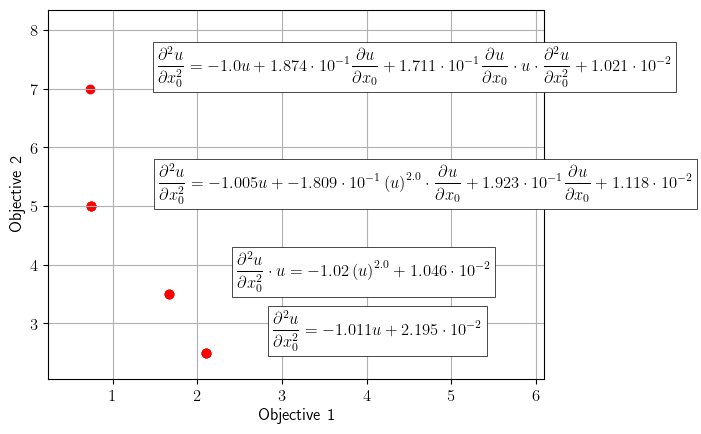

In [131]:
epde_search_obj.visualize_solutions()

Let's extract equations, that can be useful for system description: 

*Note*: during other example launches, the discovered equations may be different. To proceed, adopt getting equations by complexities, according to the Pareto frontier.

In [141]:
eq_compl_5 = epde_search_obj.get_equations_by_complexity(5)[0]
eq_compl_3_5 = epde_search_obj.get_equations_by_complexity(3.5)[0]
eq_compl_7 = epde_search_obj.get_equations_by_complexity(7)[0]

The Pareto frontier is concave, having the relatively simple yet very descriptive equation, matching the equation $u'' = -u + 0.2 u' - 0.2 u^2 u' + \delta$, $\delta << 1$ which we will consider as a useful equation-based model of the process.

Even though we already know, that it is very similar to the equation, from which we generated the data, we should still examine its predictive properties. Let's solve the equation with solver:

In [147]:
bop_u = get_ode_bop('u', grid_loc = t_test[0], value = x_test[0], term = [None], var = 0)
bop_dudt = get_ode_bop('dudt', grid_loc = t_test[0], value = y_test[0], term = [0], var = 0)

#get solution for equation with complexity 5
pred_u_compl_5 = epde_search_obj.predict(system=eq_compl_5, boundary_conditions=[bop_u(), bop_dudt()], 
                                   grid = [t_test,], strategy='autograd')
pred_u_compl_5 = pred_u_compl_5.reshape(pred_u_compl_5.size)

#get solution for equation with complexity 3.5
pred_u_compl_3_5 = epde_search_obj.predict(system=eq_compl_3_5, boundary_conditions=[bop_u(), bop_dudt()], 
                                   grid = [t_test,], strategy='autograd')
pred_u_compl_3_5 = pred_u_compl_3_5.reshape(pred_u_compl_3_5.size)

#get solution for equation with complexity 7
pred_u_compl_7 = epde_search_obj.predict(system=eq_compl_7, boundary_conditions=[bop_u(), bop_dudt()], 
                                   grid = [t_test,], strategy='autograd')
pred_u_compl_7 = pred_u_compl_7.reshape(pred_u_compl_7.size)

Using explicitly sent system of equations.
dimensionality is 1
grid.shape is (320,)
Shape of the grid for solver torch.Size([320, 1])
Grid is  <class 'torch.Tensor'> torch.Size([320, 1])
torch.Size([1])
[2023-10-27 18:55:25.204678] initial (min) loss is 114.25733184814453
[2023-10-27 18:55:25.338582] Print every 1000 step
Step = 0 loss = 114.257332 normalized loss line= -0.000000x+1.000000. There was 1 stop dings already.
[2023-10-27 18:57:06.004703] Print every 1000 step
Step = 1000 loss = 0.000560 normalized loss line= -0.002775x+1.563721. There was 1 stop dings already.
[2023-10-27 18:57:40.499169] No improvement in 100 steps
Step = 1356 loss = 0.000065 normalized loss line= 0.060959x+4.262471. There was 1 stop dings already.
[2023-10-27 18:57:50.585647] No improvement in 100 steps
Step = 1456 loss = 0.000622 normalized loss line= 0.017430x+-0.053238. There was 2 stop dings already.
[2023-10-27 18:58:00.498611] No improvement in 100 steps
Step = 1556 loss = 0.174487 normalized loss 

MAPE on the test dataset for eq with $C = 3.5$ is 1.0291776644268698
MAPE on the test dataset for eq with $C = 5$ is 0.1408898496016532
MAPE on the test dataset for eq with $C = 7$ is 0.45236988834056024


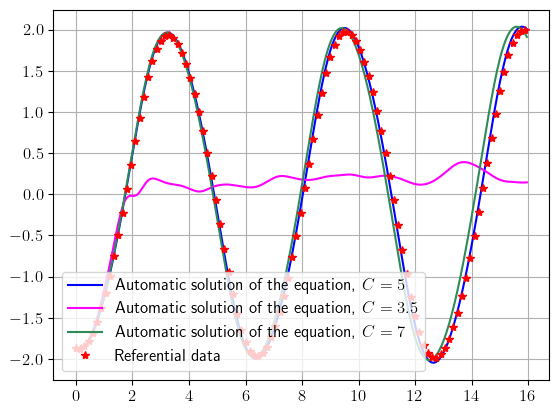

In [154]:
mae_compl_3_5 = np.mean(np.abs((pred_u_compl_3_5 - x_test)/x_test))
mae_compl_5 = np.mean(np.abs((pred_u_compl_5 - x_test)/x_test))
mae_compl_7 = np.mean(np.abs((pred_u_compl_7 - x_test)/x_test))

print(f'MAPE on the test dataset for eq with $C = 3.5$ is {mae_compl_3_5}')
print(f'MAPE on the test dataset for eq with $C = 5$ is {mae_compl_5}')
print(f'MAPE on the test dataset for eq with $C = 7$ is {mae_compl_7}')

plt.plot(t_test, pred_u_compl_5, color = 'b', label = 'Automatic solution of the equation, $C = 5$')
plt.plot(t_test, pred_u_compl_3_5, color = 'magenta', label = 'Automatic solution of the equation, $C = 3.5$')
plt.plot(t_test, pred_u_compl_7, color = 'seagreen', label = 'Automatic solution of the equation, $C = 7$')

plt.plot(t_test[::3], x_test[::3], '*', color = 'r', label = 'Referential data')
plt.grid()
plt.legend(loc = 'lower left')
plt.show()

Here, we can notice, that the "correct" governing equation, which closely matches the Van der Pol equation, has the lowest MAPE metric on the test dataset, even outperforming the equations with higher complexities. The equation with lower complexity can represent only the averaged values of the system. Thus, we can select the equation like $u'' = -u + 0.2 u' - 0.2 u^2 u' + \delta$ for system representation.

## Lotka-Volterra system